In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import random
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import squarify

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from weights_parser import WeightsParser

from models import LogisticRegressionWithSummaries_Wrapper, LogisticRegressionWithSummariesAndBottleneck_Wrapper

from custom_losses import custom_bce_horseshoe

from preprocess_helpers import preprocess_MIMIC_data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits

from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from itertools import combinations

from tqdm import tqdm
from time import sleep

## Load patient data & vasopressor target

In [2]:
X_np, Y_logits, changing_vars, data_cols = preprocess_MIMIC_data('data/X_vasopressor_LOS_6_600.p', 'data/y_vasopressor_LOS_6_600.p')
# X_np, Y_logits, changing_vars, data_cols = preprocess_MIMIC_data('data/X_death_early_vasopressor.p', 'data/y_death_early_vasopressor.p')
input_dim = X_np[0].shape[1]
changing_dim = len(changing_vars)

## Helper functions for model learning

In [3]:
# init thresholds C to 12

def init_cutoffs_to_twelve(d):
    return np.zeros(d) + 12

def init_cutoffs_to_zero(d):
    return np.zeros(d)

def init_cutoffs_to_twentyfour(d):
    return np.zeros(d) + 24

In [4]:
# Initialize all cutoffs to x
def init_cutoffs_to_x(d, x):
    return np.zeros(d) + x

# Initialize all cutoffs to a uniform random integer between 0 and (x - 1)
def init_cutoffs_randomly(d):
    return np.random.randint(6, size=d).astype('float')

In [5]:
# init the upper and lower thresholds to random values

def init_rand_upper_thresholds(d):
    return np.random.rand(d)

def init_rand_lower_thresholds(d):
    return np.random.rand(d) - 1

def init_zeros(d):
    return np.zeros(d)

In [6]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initializeData(r):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(X_np, Y_logits, test_size = 0.15, random_state = r, stratify = Y_logits)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_pt = Variable(tensor_wrap(X_np)).cuda()
    
    # initiazing datasets
    pos_prop = np.mean(np.array(Y_logits)[:, 1])

    p_weight = torch.Tensor([1 / (1 - pos_prop), 1 / pos_prop]).cuda()

    X_train_pt = Variable(tensor_wrap(X_train)).cuda()
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor)).cuda()

    X_val_pt = Variable(tensor_wrap(X_val)).cuda()
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor)).cuda()

    X_test_pt = Variable(tensor_wrap(X_test)).cuda()
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor)).cuda()

    batch_size = 128

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=True, num_workers=0)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader, val_loader, X_test, y_test, p_weight

In [7]:
def initializeModel(c):
#     vals_to_init = init_cutoffs_randomly(changing_dim * 9)
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                c,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None)
    logregbottleneck.cuda()
    return logregbottleneck

def initializeModelNoBottleneck():
    vals_to_init = init_cutoffs_randomly(changing_dim * 9)
    logreg = LogisticRegressionWithSummaries_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,        
                                                True,
                                                init_cutoffs_randomly, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=vals_to_init)
    logreg.cuda()
    return logreg

def getAUC(model, X_test, y_test):
    # get results of forward, do AUROC
    y_hat_test = []
    forwards = []

    for pat in X_test:
        # batch size of 1
        x = tensor_wrap([pat]).cuda()
        y_hat_test.append(model.sigmoid(model.forward(x))[:,1].item())
    print(np.array(y_hat_test))
    score = roc_auc_score(np.array(y_test)[:, 1], y_hat_test)
#     RocCurveDisplay.from_predictions(np.array(y_test)[:, 1], y_hat_test)
#     plt.show()
#     fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test)[:, 1], y_hat_test)
#     print(list(zip(fpr,thresholds)))
    
    return score

def getWeights(model):
    weights=logregbottleneck.model.bottleneck.weight.cpu().detach().numpy()
    return np.mean(np.absolute(weights), axis=1), weights

## Helper Function for Concept Meanings

In [8]:
summary_dict = {0:'mean', 1:'var', 2:'ever measured', 3:'mean of indicators', 4: 'var of indicators', 5:'# switches', 6:'slope', 7:'slope std err', 8:'first time measured', 9:'last time measured', 10:'hours above threshold', 11:'hours below threshold'}
def getConcept(c):
    if c < 66:
        # raw feature
        return data_cols[c]
    else:
        # summary statistic of feature
        c = c-66
        summary = c//28
        feature = c % 28
        return data_cols[feature], summary_dict[summary]

# LOS 6-600 Hours

## Investigate Randomness in Model

In [54]:
def set_seed(r):
    torch.backends.cudnn.deterministic = True
    random.seed(r)
    torch.manual_seed(r)
    torch.cuda.manual_seed(r)
    np.random.seed(r)

In [10]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
# logregbottleneck = initializeModel(3)
set_seed(0)

vals_to_init = init_cutoffs_to_zero(changing_dim * 9)
logregbottleneck_reg = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                            changing_dim,
                                                                            9,                     
                                                                            1,
                                                                            True,
                                                                            init_cutoffs_to_zero, 
                                                                            init_rand_lower_thresholds, 
                                                                            init_rand_upper_thresholds,
                                                                            cutoff_times_temperature=1.0,
                                                                            cutoff_times_init_values=None,
#                                                                             alpha = 0.001,
#                                                                             tau = 40,
                                                                            opt_lr = 0.001,
                                                                            opt_weight_decay = 0.001,
                                                                           l1_lambda=1e-04)
logregbottleneck_reg.cuda()

set_seed(0)

logregbottleneck_reg.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.1_optwd_0.pt", 
                     epochs=1000, 
                     save_every_n_epochs=10)

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


In [11]:
getAUC(logregbottleneck_reg.model, X_test, y_test)

0.7596759819847902

self.num_concepts
1
Loaded model from ./models/LOS-6-600/test.pt


0it [00:00, ?it/s]


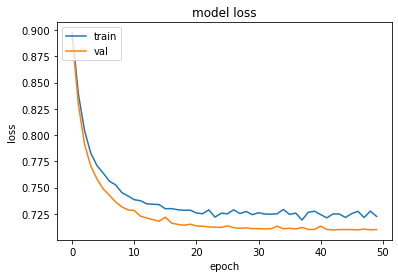

In [17]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
logregbottleneck = initializeModel(1)
logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/test.pt", 
                     epochs=500, 
                     save_every_n_epochs=10)
plt.plot(logregbottleneck.train_losses)
plt.plot(logregbottleneck.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Add Cosine-Similarity Regularization

In [10]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
logregbottleneck = initializeModel(3)

vals_to_init = init_cutoffs_randomly(changing_dim * 9)
logregbottleneck_reg = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                            changing_dim,
                                                                            9,                     
                                                                            3,
                                                                            True,
                                                                            init_cutoffs_randomly, 
                                                                            init_rand_lower_thresholds, 
                                                                            init_rand_upper_thresholds,
                                                                            cutoff_times_temperature=0.1,
                                                                            cutoff_times_init_values=vals_to_init,
                                                                            alpha = 0.001,
                                                                            tau = 40,
                                                                            opt_lr = 0.01,
                                                                            opt_weight_decay = 0.001,
                                                                           l1_lambda=1e-03)
logregbottleneck_reg.cuda()

logregbottleneck_reg.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/cos-sim/test.pt", 
                     epochs=1, 
                     save_every_n_epochs=10)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

in init bottleneck test
self.num_concepts
3
in init bottleneck test
self.num_concepts
3
loss before
tensor(1.2543, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(1.4083, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(1.1290, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(1.0487, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(2.2088, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(1.1458, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.9135, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(2.0929, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(1.0584, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(1.5801, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(1.0814, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.1117, device='cuda:0', grad_fn=

loss before
tensor(0.8390, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(0.9314, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(0.8904, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(0.9841, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(0.8679, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(0.9614, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(0.7846, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(0.8791, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(1.0268, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(1.1133, device='cuda:0', grad_fn=<AddBackward0>)
loss 

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


loss before
tensor(0.8702, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(1.0103, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(0.8417, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(0.9544, device='cuda:0', grad_fn=<AddBackward0>)
loss before
tensor(0.8252, device='cuda:0', grad_fn=<AddBackward0>)
cos sim
tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)
loss after
tensor(0.8917, device='cuda:0', grad_fn=<AddBackward0>)


In [31]:
concepts =np.arange(0,3)
combs = list(combinations(test_list, 2))
for comb in combs:
    print(F.cosine_similarity(logregbottleneck_reg.model.bottleneck.weight[comb[0]],logregbottleneck_reg.model.bottleneck.weight[comb[1]],dim=0))

tensor(-0.3797, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9819, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.3907, device='cuda:0', grad_fn=<DivBackward0>)


In [27]:
F.cosine_similarity(logregbottleneck_reg.model.bottleneck.weight[1],logregbottleneck_reg.model.bottleneck.weight[2],dim=0)

tensor(-0.3907, device='cuda:0', grad_fn=<DivBackward0>)

### Plot AUCs

In [28]:
# BASELINE: get top model from hyperparameter scan
for r in range(1,2):
    file = open('./models/old-models/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
        baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top1=sorted_baseline_rows[-1:]
    baseline_top1_auc=sorted_baseline_rows[-1:][:,4]

# BOTTLENECK: get top 5 models from hyperparameter scan
bottleneck_top1_all = []
bottleneck_top1_auc_all = []
for r in range(1,2):
    for c in range(1,9):
        file = open('./models/LOS-6-600/no-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_top1_all.append(sorted_bottleneck_rows[-1:])
        bottleneck_top1_auc_all.append(sorted_bottleneck_rows[-1:][:,3])
        
# BOTTLENECK W/ L1
bottleneckl1_top1_all = []
bottleneckl1_top1_auc_all = []
for r in range(1,2):
    for c in range(1,9):
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
            if (row[3]=='0.001'):
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneckl1_top1_all.append(bottleneck_rows[0])
        bottleneckl1_top1_auc_all.append(bottleneck_rows[0][4])

# BOTTLENECK w/ L1 + COS SIM
bottleneckcos_top1_all = []
bottleneckcos_top1_auc_all = []
for r in range(1,2):
    for c in range(1,9):
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
            bottleneck_rows.append(np.array(row).astype(float))
        print(bottleneck_rows)
#         bottleneckcos_top1_all.append(bottleneck_rows[0])
#         bottleneckcos_top1_auc_all.append(bottleneck_rows[0][5])
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,5])]
        bottleneckcos_top1_all.append(sorted_bottleneck_rows[-1:])
        bottleneckcos_top1_auc_all.append(sorted_bottleneck_rows[-1:][:,5])

[array([1.0000000e+00, 1.0000000e-03, 1.0000000e-03, 1.0000000e-03,
       1.0000000e+01, 7.3132067e-01]), array([1.        , 0.001     , 0.001     , 0.001     , 0.        ,
       0.72907189]), array([1.        , 0.001     , 0.001     , 0.001     , 1.        ,
       0.73039812]), array([1.        , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.72968623]), array([1.        , 0.001     , 0.001     , 0.001     , 0.01      ,
       0.73074057]), array([1.        , 0.001     , 0.001     , 0.001     , 0.1       ,
       0.72897849]), array([1.00000000e+00, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-04, 7.30713592e-01]), array([1.00000000e+00, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-05, 7.31093405e-01])]
[array([2.00000000e+00, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e+00, 7.31232462e-01]), array([2.00000000e+00, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e+01, 7.30356609e-01]), arra

In [31]:
bottleneckcos_top1_all

[array([[1.0000000e+00, 1.0000000e-03, 1.0000000e-03, 1.0000000e-03,
         1.0000000e+01, 7.3132067e-01]]),
 array([[2.00000000e+00, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
         1.00000000e+00, 7.31232462e-01]]),
 array([[3.00000000e+00, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
         1.00000000e-04, 7.30353496e-01]]),
 array([[4.00000000e+00, 1.00000000e-04, 0.00000000e+00, 1.00000000e-03,
         1.00000000e-05, 7.21656192e-01]]),
 array([[5.00000000e+00, 1.00000000e-04, 1.00000000e-03, 1.00000000e-03,
         1.00000000e-03, 7.19586938e-01]]),
 array([[6.00000000e+00, 1.00000000e-04, 1.00000000e-04, 1.00000000e-03,
         1.00000000e-01, 7.23420351e-01]]),
 array([[7.00000000e+00, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
         1.00000000e-01, 7.30948121e-01]]),
 array([[8.0000000e+00, 1.0000000e-04, 1.0000000e-04, 1.0000000e-03,
         0.0000000e+00, 7.2292016e-01]])]

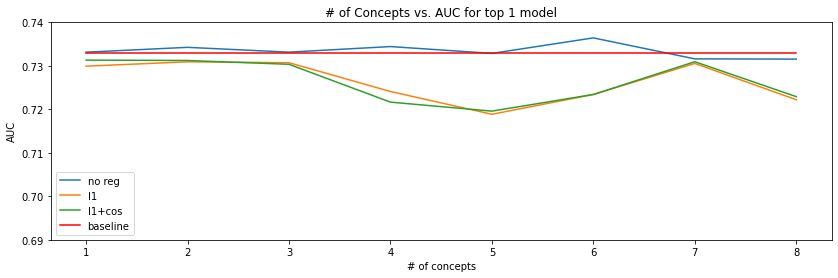

In [30]:
fig, (ax1) = plt.subplots(1, 1,figsize=(14,4))
# fig.suptitle('Across 3 train/test splits')

ax1.plot(np.arange(1,9), np.array(bottleneck_top1_auc_all)[:,0], label='no reg')
ax1.plot(np.arange(1,9), bottleneckl1_top1_auc_all, label='l1')
ax1.plot(np.arange(1,9), np.array(bottleneckcos_top1_auc_all)[:,0], label='l1+cos')
ax1.plot(np.arange(1,9), np.repeat(np.array(baseline_top1_auc),8), '-r', label='baseline')
ax1.plot
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_ylim([0.69, 0.74])
ax1.set_title("# of Concepts vs. AUC for top 1 model")
ax1.legend()

### Assign Concept Meanings

In [69]:
concept_weights_tot = []
concept_weights_tot_raw = []

train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
for r in range(1,2):
    concept_weights_aggr = []
    concept_weights_aggr_raw = []
    for c in range(1,9):
        concept_weights=[]
        concept_weights_raw=[]
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
#         for row in csvreader:
#             if (row[4]=="1.0"):
#                 bottleneck_rows.append(np.array(row).astype(float))
#         for row in bottleneck_rows:
        for row in bottleneckcos_top1_all[c-1]:
#             row=row[0]
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]

            # initialize model
            logregbottleneck = initializeModel(c)

            # load trained models
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1lambda_{}_cossim_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                 epochs=1000, 
                 save_every_n_epochs=10)

            # get weights
            weights, weights_raw = getWeights(logregbottleneck.model)
            concept_weights.append(weights)
            concept_weights_raw.append(weights_raw)

        # aggregate concept weights for each # of concepts
        concept_weights_aggr.append(concept_weights)
        concept_weights_aggr_raw.append(concept_weights_raw)
    
    # aggregate concept weights for each train/test split
    concept_weights_tot.append(concept_weights_aggr)
    concept_weights_tot_raw.append(concept_weights_aggr_raw)

in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.001_cossim_lambda_10.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.001_cossim_lambda_1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.001_cossim_lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.001_cossim_lambda_1e-05.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.001_cossim_lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.001_cossim_lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.001_cossim_lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.001_cossim_lambda_0.pt


0it [00:00, ?it/s]


In [70]:
concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)
concept_weights_tot_raw_sorted = []
top_5_features = []
top_5_feature_weights = []
for i in range(concept_weights_tot_raw_avg.shape[0]):
    concept_weights_tot_raw_sorted.append(np.argsort(-np.abs(concept_weights_tot_raw_avg[i]), axis=1))
for i in range(len(concept_weights_tot_raw_sorted)):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    top_5_features_concept = []
    top_5_feature_weights_concept = []
    for j in range(i+1):
        top_5_features_concept.append(concept_weights_tot_raw_sorted[i][j][:5])
        top_5_feature_weights_concept.append(concept_weights_tot_raw_avg[i][j][concept_weights_tot_raw_sorted[i][j][:5]])
        print(list(map(getConcept,concept_weights_tot_raw_sorted[i][j][:5])))
        for k in range(0,5):
                print(concept_weights_tot_raw_avg[i][j][concept_weights_tot_raw_sorted[i][j][k]])
    top_5_features.append(top_5_features_concept)
    top_5_feature_weights.append(top_5_feature_weights_concept)
    print("\n")

Top 5 features associated with 1 concepts:
[('spontaneousrr', 'var of indicators'), ('spo2', 'mean of indicators'), ('fio2', 'first time measured'), ('inr', 'hours below threshold'), ('inr', 'hours above threshold')]
0.5700224
0.5202944
-0.5182874
-0.41804975
-0.41742814


Top 5 features associated with 2 concepts:
['map_ind', ('po2', 'var of indicators'), ('pco2', 'var of indicators'), ('hr', 'last time measured'), ('spo2', 'last time measured')]
0.62304825
-0.3094682
-0.3089527
0.28693134
0.18595129
[('spontaneousrr', 'var of indicators'), ('fio2', 'first time measured'), ('spo2', 'mean of indicators'), ('inr', 'hours below threshold'), ('temp', 'first time measured')]
-0.6029412
0.5777195
-0.51054394
0.42618856
-0.41210553


Top 5 features associated with 3 concepts:
[('inr', 'hours below threshold'), ('inr', 'hours above threshold'), ('inr', 'var of indicators'), ('bicarbonate', 'slope std err'), 'magnesium_ind']
0.19132581
0.16886958
0.0046935
0.0038850498
-0.0037607474
[('spo2', 

/tmp/ipykernel_207017/3734059212.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)


Top 5 features associated with 1 concepts:


/tmp/ipykernel_207017/1245373654.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, j].set_xticklabels(concepts, rotation=45)


<Figure size 432x288 with 0 Axes>

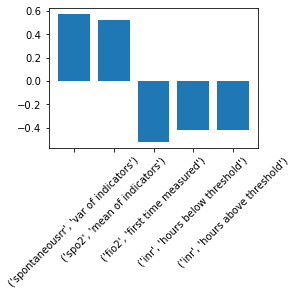

Top 5 features associated with 2 concepts:


<Figure size 432x288 with 0 Axes>

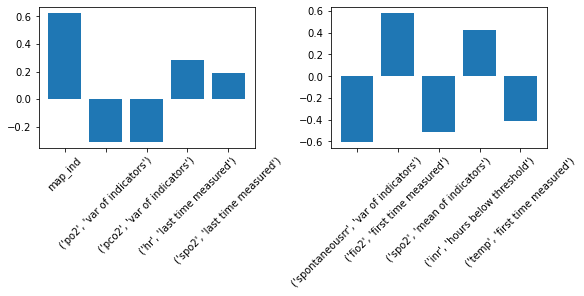

Top 5 features associated with 3 concepts:


<Figure size 432x288 with 0 Axes>

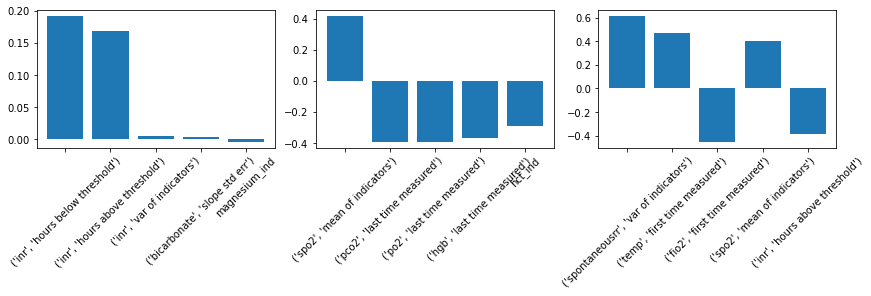

Top 5 features associated with 4 concepts:


<Figure size 432x288 with 0 Axes>

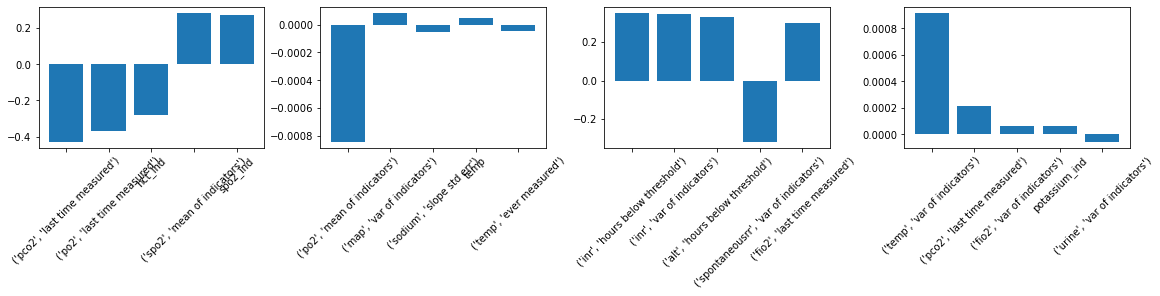

Top 5 features associated with 5 concepts:


/tmp/ipykernel_207017/1245373654.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, j-4].set_xticklabels(concepts, rotation=45)


<Figure size 432x288 with 0 Axes>

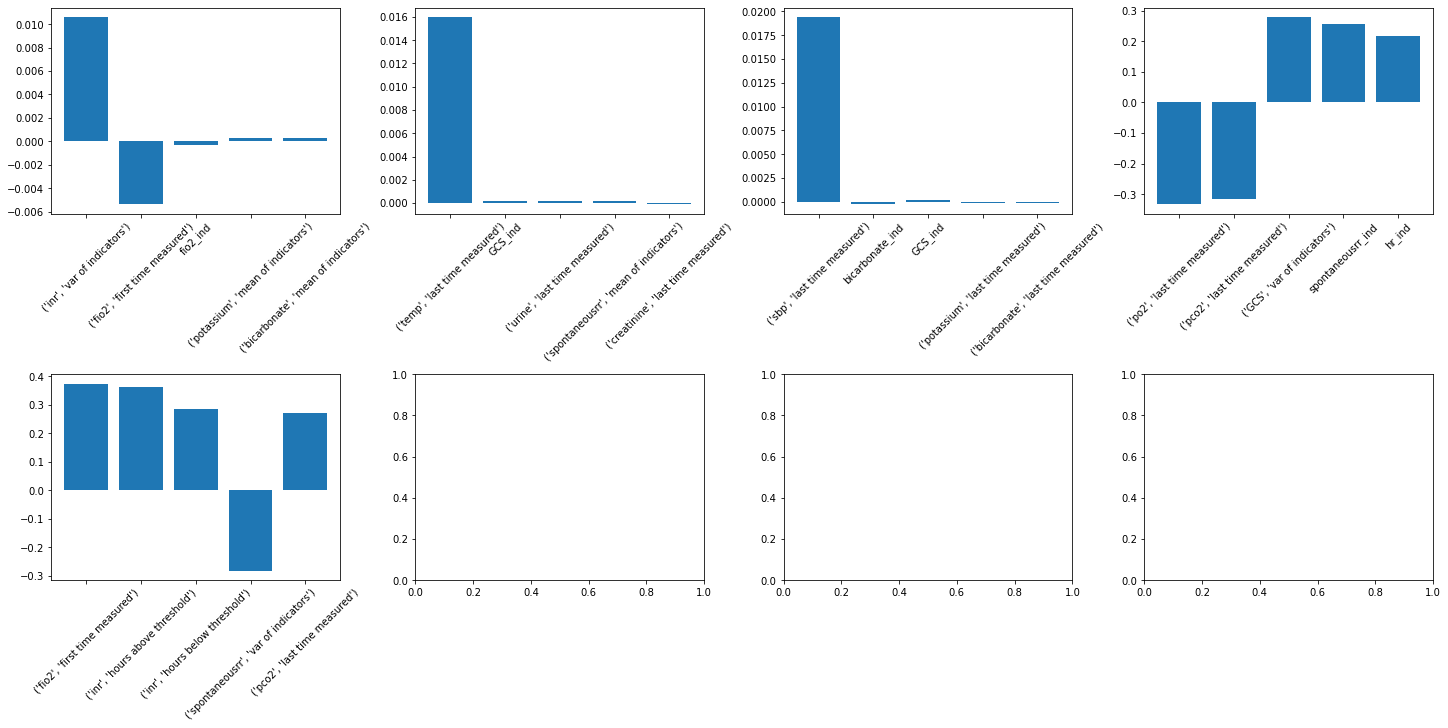

Top 5 features associated with 6 concepts:


<Figure size 432x288 with 0 Axes>

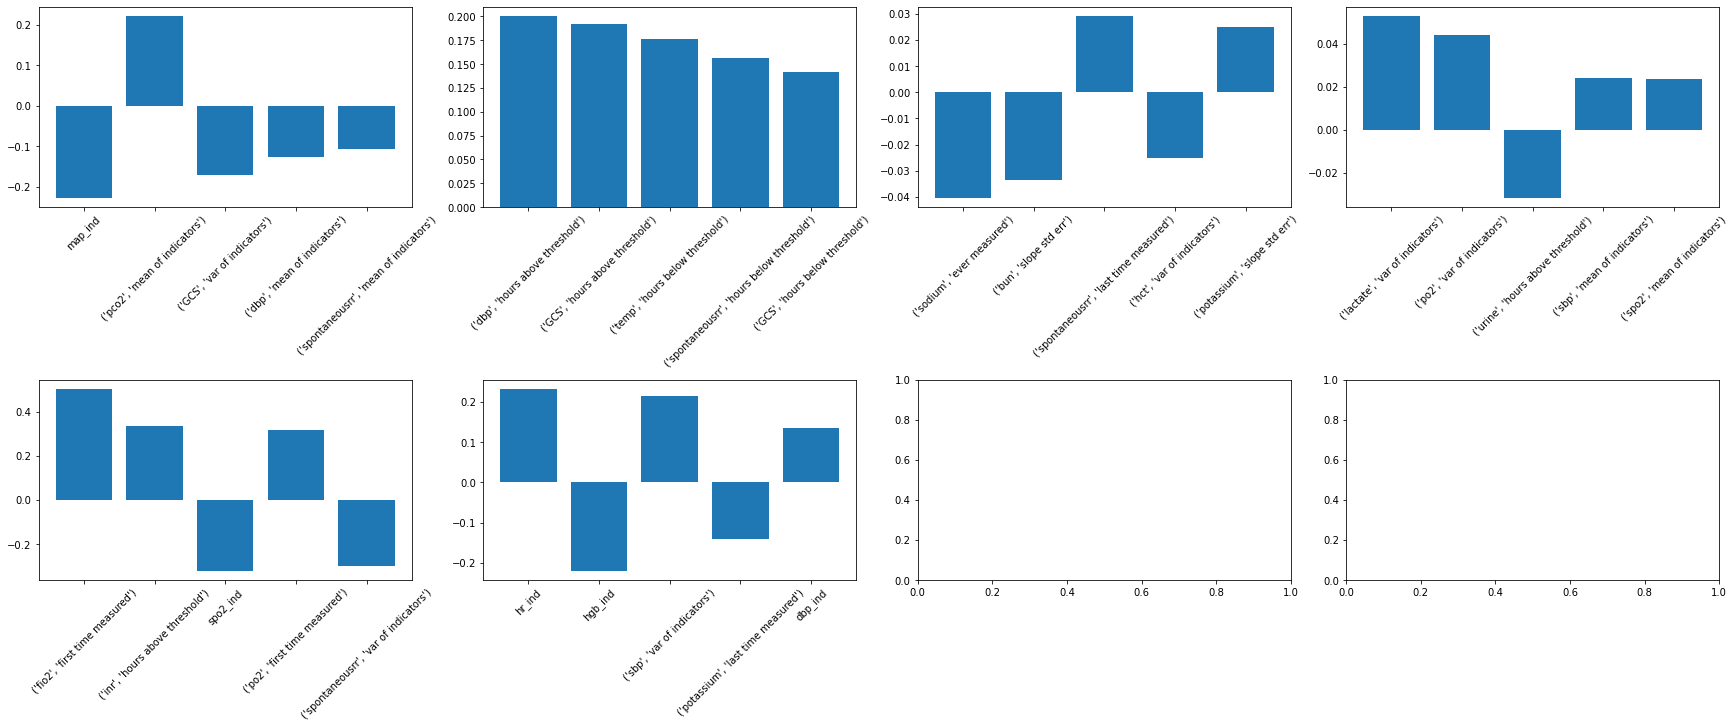

Top 5 features associated with 7 concepts:


<Figure size 432x288 with 0 Axes>

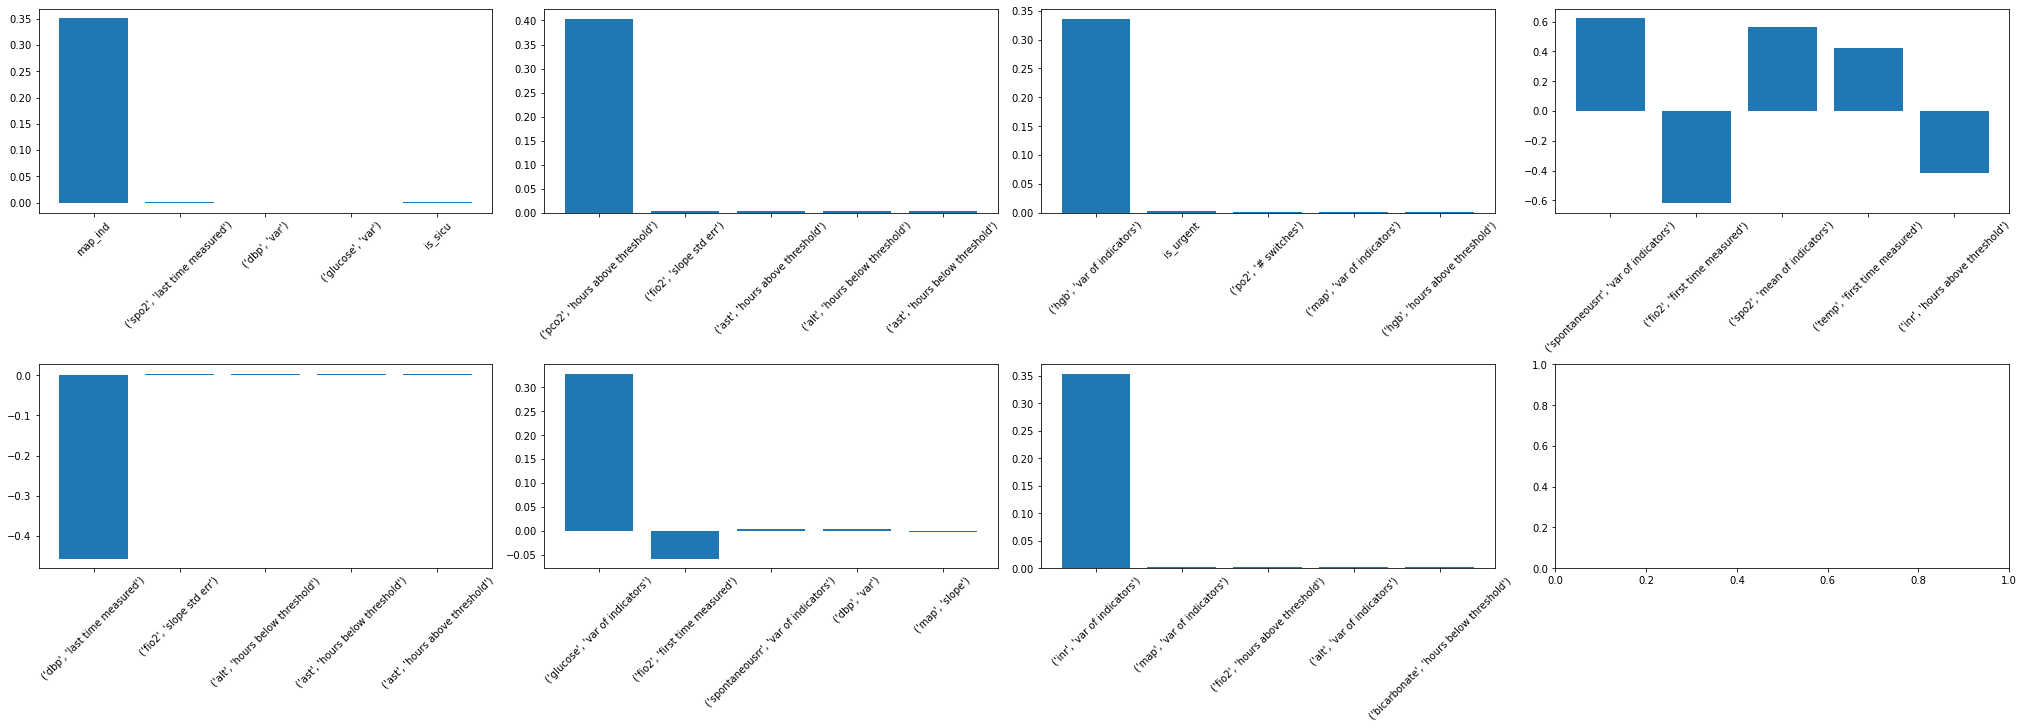

Top 5 features associated with 8 concepts:


<Figure size 432x288 with 0 Axes>

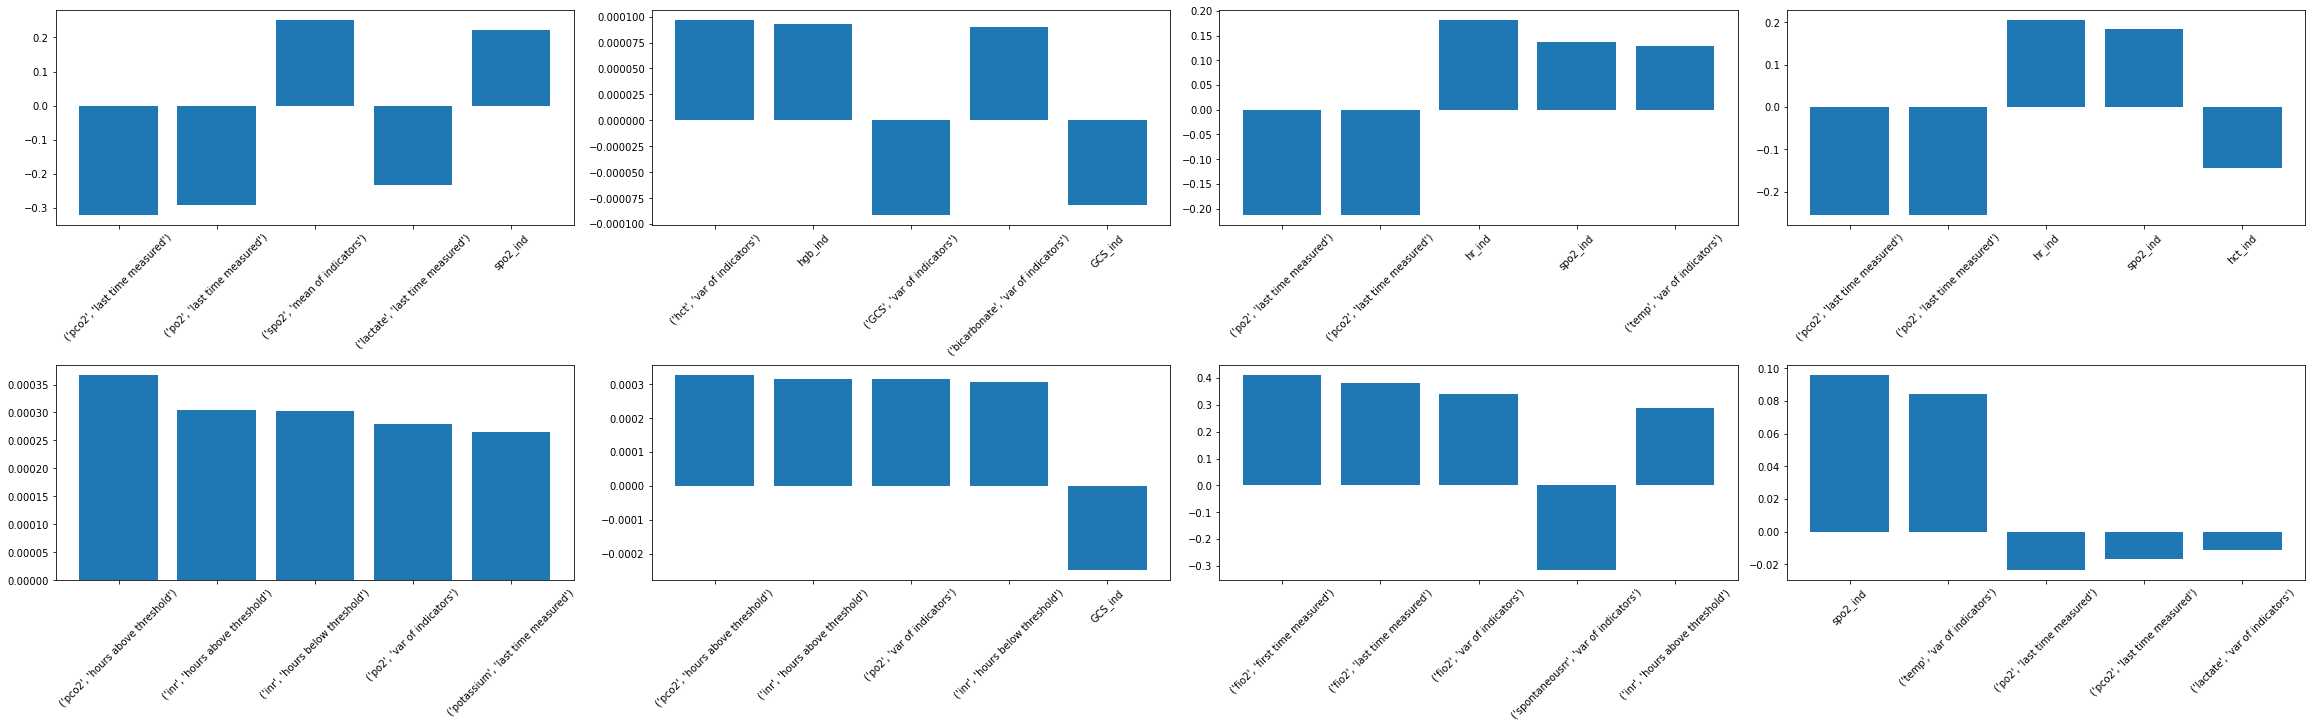

In [71]:
import matplotlib.pyplot as plt
    

for i in range(8):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    plt.clf()
    if (i < 4):
        fig, axs = plt.subplots(1, i+1,squeeze=False,figsize=(4*(i+1),4),constrained_layout=True)
    else:
        fig, axs = plt.subplots(2, 4,figsize=(4*(i+1),10),constrained_layout=True)
    for j in range(i+1):
        concepts = list(map(str,map(getConcept,concept_weights_tot_raw_sorted[i][j][:5])))
        weights = concept_weights_tot_raw_avg[i][j][concept_weights_tot_raw_sorted[i][j][:5]]
        if (j<4):
            axs[0, j].bar(concepts, weights)
            axs[0, j].set_xticklabels(concepts, rotation=45)
        else:
            axs[1, j-4].bar(concepts, weights)
            axs[1, j-4].set_xticklabels(concepts, rotation=45)
    plt.show()
    
    

## Check if concepts are accurate

In [11]:
def add_all_parsers(p, input_dim, changing_dim, str_type = 'linear'):
    if str_type == 'linear':
        p.add_shape(str(str_type) + '_time_23_', input_dim)
        
    p.add_shape(str(str_type) + '_mean_', changing_dim)
    p.add_shape(str(str_type) + '_var_', changing_dim)
    p.add_shape(str(str_type) + '_ever_measured_', changing_dim)
    p.add_shape(str(str_type) + '_mean_indicators_', changing_dim)
    p.add_shape(str(str_type) + '_var_indicators_', changing_dim)
    p.add_shape(str(str_type) + '_switches_', changing_dim)
    
    # slope_indicators are the same weights for all of the slope features.
    p.add_shape(str(str_type) + '_slope_', changing_dim)
    
    if str_type == 'linear':
        p.add_shape(str(str_type) + '_slope_stderr_', changing_dim)
        p.add_shape(str(str_type) + '_first_time_measured_', changing_dim)
        p.add_shape(str(str_type) + '_last_time_measured_', changing_dim)
        
    p.add_shape(str(str_type) + '_hours_above_threshold_', changing_dim)
    p.add_shape(str(str_type) + '_hours_below_threshold_', changing_dim)
        

##################################################################


class LogisticRegressionBottleneckOnly(nn.Module):
    def __init__(self, 
                 input_dim, 
                 changing_dim, 
                 num_cutoff_times, 
                 num_concepts,
                 differentiate_cutoffs,
                 init_cutoffs, 
                 init_lower_thresholds, 
                 init_upper_thresholds,
                 cutoff_times_temperature = 1.0,
                 cutoff_times_init_values = None,
                 thresholds_temperature = 0.1,
                 ever_measured_temperature = 0.1,
                 switch_temperature = 0.1,
                 time_len = 6,
                 
                 ):
        """Initializes the LogisticRegressionWithSummaries.
        
        Args:
            input_dim (int): number of input dimensions
            changing_dim (int): number of non-static input dimensions
            num_cutoff_tines (int): number of cutoff-time parameters
            differentiate_cutoffs (bool): indicator for whether cutoff-time parameters are learned
            init_cutoffs (function): function to initialize cutoff-time parameters
            init_lower_thresholds (function): function to initialize lower threshold parameters
            init_upper_thresholds (function): function to initialize upper threshold parameters
            cutoff_times_temperature (float): temperature used to calculate cutoff-time parameters
            thresholds_temperature (float): temperature used to calculate threshold summaries
            ever_measured_temperature (float): temperature used to calculate measurement indicator summaries
            switch_temperature (float): temperature used to calculate switch summaries
            time_len (int): number of time-steps in each trajectory
        """
        super(LogisticRegressionBottleneckOnly, self).__init__()
        
        print("in init")
        print("TEST1")

        self.time_len = time_len
        self.changing_dim = changing_dim
        self.num_cutoff_times = num_cutoff_times
        self.num_concepts = num_concepts
        
        self.sigmoid_for_weights = nn.Sigmoid()
        self.sigmoid_for_ever_measured = nn.Sigmoid()
        self.sigmoid_for_switches = nn.Sigmoid()
        
        self.upper_thresh_sigmoid = nn.Sigmoid()
        self.lower_thresh_sigmoid = nn.Sigmoid()
        
        self.sigmoid = nn.Sigmoid()
        
        num_total_c_weights = changing_dim * num_cutoff_times
        
        # Initialize cutoff_times to by default use all of the timesteps.
        self.cutoff_times = - 12 * torch.ones(1, num_total_c_weights).cuda()
      
            
        if differentiate_cutoffs: 
            cutoff_vals = init_cutoffs(num_total_c_weights)
            
            if cutoff_times_init_values is not None:
                cutoff_vals = cutoff_times_init_values
                
            self.cutoff_times = nn.Parameter(torch.tensor(cutoff_vals, requires_grad=True).reshape(1, num_total_c_weights).cuda())
            
        self.times = torch.tensor(np.transpose(np.tile(range(time_len), (changing_dim, 1)))).cuda()
        self.times = self.times.repeat(1, num_cutoff_times).cuda()

        self.weight_parser = WeightsParser()
        self.cs_parser = WeightsParser()
        add_all_parsers(self.weight_parser, input_dim, self.changing_dim)
        add_all_parsers(self.cs_parser, input_dim, self.changing_dim, 'cs')
        
        self.lower_thresholds = nn.Parameter(torch.tensor(init_lower_thresholds(changing_dim)).cuda())
        self.upper_thresholds = nn.Parameter(torch.tensor(init_upper_thresholds(changing_dim)).cuda())
        
        self.lower_thresholds.retain_grad()
        self.upper_thresholds.retain_grad()
        
        self.thresh_temperature = thresholds_temperature
        self.cutoff_times_temperature = cutoff_times_temperature
        self.ever_measured_temperature = ever_measured_temperature
        self.switch_temperature = switch_temperature
        
        # (input, mean_feats, var_feats, ever_measured, mean_ind, var_ind)
        self.linear = nn.Linear(self.num_concepts, 2)
    
    def encode_patient_batch(self, patient_batch, epsilon_denom=0.01):
        # print("in encode patient batch")
	# Computes the encoding (s, x) + (weighted_summaries) in the order defined in weight_parser.
        # Returns pre-sigmoid P(Y = 1 | patient_batch)
        temperatures = torch.tensor(np.full((1, self.cs_parser.num_weights), self.cutoff_times_temperature)).cuda()
        
        # Get changing variables
        batch_changing_vars = patient_batch[:, :, :self.changing_dim]
        batch_measurement_indicators = patient_batch[:, :, self.changing_dim: self.changing_dim * 2]
        batch_measurement_repeat = batch_measurement_indicators.repeat(1, 1, self.num_cutoff_times)
        
        weight_vector = self.sigmoid_for_weights((self.times - self.cutoff_times) / temperatures).reshape(1, self.time_len, self.cs_parser.num_weights)
        # Calculate weighted mean features
        
        # Sum of all weights across time-steps
        weight_norm = torch.sum(weight_vector * batch_measurement_repeat, dim=1)
        weight_mask = torch.sum(batch_measurement_indicators, dim=1)
        
        # MEAN FEATURES

        # Calculate \sum_t (w_t * x_t * m_t)
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_mean_']
        mean_weight_vector = weight_vector[:, :, start_i : end_i]
        
        weighted_average = torch.sum(mean_weight_vector * (batch_changing_vars * batch_measurement_indicators), dim=1)

        mean_feats = (weighted_average / (torch.sum(mean_weight_vector, dim=1) + epsilon_denom))
        
        # VARIANCE FEATURES
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_var_']
        var_weight_vector = weight_vector[:, :, start_i : end_i]
        
        x_mean = torch.mean(batch_measurement_indicators * batch_changing_vars, dim=1, keepdim=True)
        weighted_variance = torch.sum(batch_measurement_indicators * var_weight_vector * (batch_changing_vars - x_mean)**2, dim=1)        
        normalizing_term = torch.sum(batch_measurement_indicators * var_weight_vector, dim=1)**2 / (torch.sum(batch_measurement_indicators * var_weight_vector, dim=1)**2 + torch.sum(batch_measurement_indicators * var_weight_vector ** 2, dim=1) + epsilon_denom)
        
        var_feats = weighted_variance / (normalizing_term + epsilon_denom)
        

        # INDICATOR FOR EVER BEING MEASURED
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_ever_measured_']
        ever_measured_weight_vector = weight_vector[:, :, start_i : end_i]
        
        ever_measured_feats = self.sigmoid_for_ever_measured( torch.sum(ever_measured_weight_vector * batch_measurement_indicators, dim=1) / (self.ever_measured_temperature * torch.sum(ever_measured_weight_vector, dim=1) + epsilon_denom)) - 0.5
        
        
        # MEAN OF INDICATOR SEQUENCE
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_mean_indicators_']
        mean_ind_weight_vector = weight_vector[:, :, start_i : end_i]
        
        weighted_ind_average = torch.sum(mean_ind_weight_vector * batch_measurement_indicators, dim=1)
        mean_ind_feats = weighted_ind_average / (torch.sum(mean_ind_weight_vector, dim=1) + epsilon_denom)
        
        # VARIANCE OF INDICATOR SEQUENCE
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_var_indicators_']
        var_ind_weight_vector = weight_vector[:, :, start_i : end_i]
                
        x_mean_ind = torch.mean(batch_measurement_indicators, dim=1, keepdim=True)
        weighted_variance_ind = torch.sum(var_ind_weight_vector * (batch_measurement_indicators - x_mean_ind)**2, dim=1)        
        normalizing_term = torch.sum(var_ind_weight_vector, dim=1)**2 / (torch.sum(var_ind_weight_vector, dim=1)**2 + torch.sum(var_ind_weight_vector ** 2, dim=1) + epsilon_denom)
        
        var_ind_feats = weighted_variance_ind / (normalizing_term + epsilon_denom)
        
        
        # COUNT OF SWITCHES
        # Compute the number of times the indicators switch from missing to measured, or vice-versa.
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_switches_']
        switches_weight_vector = weight_vector[:, :, start_i : end_i][:, :-1, :]
        
        # Calculate m_{n t + 1} - m_{ n t}
        # Sum w_t + sigmoids of each difference
        later_times = batch_changing_vars[:, 1:, :]
        earlier_times = batch_changing_vars[:, :-1, :]
        
        switch_feats = torch.sum(switches_weight_vector * torch.abs(later_times - earlier_times), dim=1) / (torch.sum(switches_weight_vector, dim=1) + epsilon_denom)
        
        # FIRST TIME MEASURED
        # LAST TIME MEASURED
        
        # For each variable in the batch, compute the first time it was measured.
        # Set equal to -1 if never measured.
        
        # For each feature, calculate the first time it was measured
        # Index of the second dimension of the indicators

        mask_max_values, mask_max_indices = torch.max(batch_measurement_indicators, dim=1)
        # if the max-mask is zero, there is no nonzero value in the row
        mask_max_indices[mask_max_values == 0] = -1
        
        first_time_feats = mask_max_indices / float(batch_measurement_indicators.shape[1])
        
        # Last time measured is the last index of the max.
        # https://discuss.pytorch.org/t/how-to-reverse-a-torch-tensor/382
        flipped_batch_measurement_indicators = torch.flip(batch_measurement_indicators, [1])
        
        mask_max_values, mask_max_indices = torch.max(flipped_batch_measurement_indicators, dim=1)
        # if the max-mask is zero, there is no nonzero value in the row
        mask_max_indices[mask_max_values == 0] = batch_measurement_indicators.shape[1]
        
        last_time_feats = (float(batch_measurement_indicators.shape[1]) - mask_max_indices) / float(batch_measurement_indicators.shape[1])
        
        # SLOPE OF L2
        # STANDARD ERROR OF L2     
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_slope_']
        slope_weight_vector = weight_vector[:, :, start_i : end_i]
        
        # Zero out the batch_changing_vars so that they are zero if the features are not measured.
        linreg_y = batch_changing_vars * batch_measurement_indicators
        
        # The x-values for this linear regression are the times.
        # Zero them out so that they are zero if the features are not measured.
        linreg_x = torch.tensor(np.transpose(np.tile(range(self.time_len), (self.changing_dim, 1)))).cuda()
        linreg_x = linreg_x.repeat(linreg_y.shape[0], 1, 1) * batch_measurement_indicators
        
        # Now, compute the slope and standard error.
        weighted_x = torch.unsqueeze(torch.sum(slope_weight_vector * linreg_x, dim = 1) / (torch.sum(slope_weight_vector, dim = 1) + epsilon_denom), 1)
        weighted_y = torch.unsqueeze(torch.sum(slope_weight_vector * linreg_y, dim = 1) / (torch.sum(slope_weight_vector, dim = 1) + epsilon_denom), 1)
        
        slope_num = torch.sum(slope_weight_vector * (linreg_x - weighted_x) * (linreg_y - weighted_y), dim=1)
        slope_den = torch.sum(slope_weight_vector * (linreg_x - weighted_x)**2, dim =1)
        
        slope_feats = slope_num / (slope_den + epsilon_denom)
        
        # If the denominator is zero, set the feature equal to 0.
        var_denom = torch.sum(slope_weight_vector * (linreg_x - weighted_x)**2, dim=1)
        slope_stderr_feats = 1 / (var_denom + epsilon_denom)
        
        slope_stderr_feats = torch.where(var_denom > 0, slope_stderr_feats, var_denom)
        
        # HOURS ABOVE THRESHOLD
        # HOURS BELOW THRESHOLD
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_hours_above_threshold_']
        above_thresh_weight_vector = weight_vector[:, :, start_i : end_i]
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_hours_below_threshold_']
        below_thresh_weight_vector = weight_vector[:, :, start_i : end_i]
            
        upper_features = self.upper_thresh_sigmoid((batch_changing_vars - self.upper_thresholds)/self.thresh_temperature)
        lower_features = self.lower_thresh_sigmoid((self.lower_thresholds - batch_changing_vars)/self.thresh_temperature)
                
        # (batch, timestep, features)
        # sum upper_features and lower_features across timesteps
        above_threshold_feats = torch.sum(batch_measurement_indicators * above_thresh_weight_vector * upper_features, dim=1) / (torch.sum(batch_measurement_indicators * above_thresh_weight_vector, dim=1) + epsilon_denom)
        below_threshold_feats = torch.sum(batch_measurement_indicators * below_thresh_weight_vector * lower_features, dim=1) / (torch.sum(batch_measurement_indicators * below_thresh_weight_vector, dim=1) + epsilon_denom)
        
        # feats_time_23 = patient_batch[:, 23, :]
        feats_time_5 = patient_batch[:, 5, :]

        cat = torch.cat((feats_time_5.float(), mean_feats.float(), var_feats.float(), ever_measured_feats.float(), mean_ind_feats.float(), var_ind_feats.float(), switch_feats.float(), slope_feats.float(), slope_stderr_feats.float(), first_time_feats.float(), last_time_feats.float(), above_threshold_feats.float(), below_threshold_feats.float()), axis=1)
#         print("cat top 5 features")
#         print(torch.tensor(top_5_features[self.num_concepts-1][0]).cuda())
#         print(torch.tensor(top_5_features[self.num_concepts-1][0]).cuda().type())
#         print(torch.index_select(cat, 1, torch.tensor(top_5_features[self.num_concepts-1][0]).cuda()))
        
        bottleneck_feats=torch.tensor([]).cuda()
        for c in range(self.num_concepts):
            feats = torch.index_select(cat, 1, torch.tensor(top_5_features[self.num_concepts-1][c]).cuda())
            feats_mult_weights = torch.matmul(feats,torch.tensor(top_5_feature_weights[self.num_concepts-1][c]).cuda())
            if c == 0:
                bottleneck_feats=feats_mult_weights.reshape(feats_mult_weights.shape[0],1)
            else:
                bottleneck_feats = torch.cat((bottleneck_feats, feats_mult_weights.reshape(feats_mult_weights.shape[0],1)), 1)
#         print(bottleneck_feats.shape)
        
        return bottleneck_feats
    
    def forward(self, patient_batch, epsilon_denom=0.01):
        return self.linear(self.encode_patient_batch(patient_batch, epsilon_denom))

class LogisticRegressionBottleneckOnly_Wrapper(nn.Module):
    """
    Wrapper class to track training for a LogisticRegressionWithSummaries.
    """

    def __init__(self, 
             input_dim, 
             changing_dim, 
             num_cutoff_times,
             num_concepts,
             differentiate_cutoffs,
             init_cutoffs, 
             init_lower_thresholds, 
             init_upper_thresholds, 
             cutoff_times_temperature = 1.0,
             alpha = 1e-4,
             tau = 10.,
             opt_lr = 1e-4,
             opt_weight_decay = 0.,
             cutoff_times_init_values = None,
            ):
        super(LogisticRegressionBottleneckOnly_Wrapper, self).__init__()

        self.input_dim = input_dim
        self.changing_dim = changing_dim
        self.num_concepts = num_concepts

        self.model = LogisticRegressionBottleneckOnly(input_dim, 
                                                changing_dim, 
                                                num_cutoff_times,
                                                num_concepts,
                                                differentiate_cutoffs,                         
                                                init_cutoffs, 
                                                init_lower_thresholds, 
                                                init_upper_thresholds,
                                                cutoff_times_temperature,
                                                cutoff_times_init_values)

        self.alpha = alpha
        self.tau = tau

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr= opt_lr, weight_decay = opt_weight_decay)
        
    def _load_model(self, path, print_=True):
        """
        Args:
            path (str): filepath to the model
        """
        try:
            checkpoint = torch.load(path)
        except:
            return
        self.model.load_state_dict(checkpoint['model_state_dict'])
        if print_:
            print("Loaded model from " + path)
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.curr_epoch = checkpoint['epoch']
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        sleep(0.5)

    def fit(self, train_loader, val_loader, p_weight, save_model_path, epochs=10000, save_every_n_epochs=100):
        """
        
        Args:
            train_loader (torch.DataLoader): 
            val_tensor (torch.DataLoader):
            p_weight (tensor): weight parameter used to calculate BCE loss 
            save_model_path (str): filepath to save the model progress
            epochs (int): number of epochs to train
        """
        self.loss_func = custom_bce_horseshoe
        self.train_losses = []
        self.val_losses = []
        self.curr_epoch = -1
        
        self._load_model(save_model_path)
        
        epoch_loss = 0
        
        for epoch in tqdm(range(self.curr_epoch+1, epochs)):
            if (epoch % save_every_n_epochs) == (-1 % save_every_n_epochs):
                # Append loss to loss array
                epoch_loss = epoch_loss / num_points
                
                self.train_losses.append(epoch_loss)
                
                # Calculate validation set loss
                val_loss = 0
                for batch, data in enumerate(val_loader):
                    Xb, yb = data
           
                    # Forward pass.
                    self.model.zero_grad()
                    output = self.model(Xb)

                    val_loss = binary_cross_entropy_with_logits(output, yb, pos_weight = p_weight) / Xb.shape[0]
              
                self.val_losses.append(val_loss.item())
                
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(),
                            'train_losses': self.train_losses,
                            'val_losses': self.val_losses,
                            }, save_model_path)
            
            epoch_loss = 0
            num_points = 0
            for batch, data in enumerate(train_loader):

                Xb, yb = data
                num_points += Xb.shape[0]

                # Forward pass.
                # print("making forward pass")
                self.model.zero_grad()
                output = self.model(Xb)

#                 print("about to calculate loss")
#                 print(output)
                
                loss = binary_cross_entropy_with_logits(output, yb, pos_weight = p_weight)

                loss.backward()

                epoch_loss += loss.item()

                # update all parameters
                self.optimizer.step()

In [91]:
top_5_features[1]

[array([320, 355, 380, 274, 351]), array([157, 184, 291, 341, 298])]

In [12]:
aucs=[]
r=1
for c in range(1,11):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
    logregbottleneck = initializeModel(c)

    vals_to_init = init_cutoffs_randomly(changing_dim * 9)
    
    file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    bottleneck_row = []
    for row in csvreader:
        bottleneck_row = np.array(row).astype(float)
        # format hyperparameters for csv reader
        bottleneck_row=[int(el) if el >= 1 else el for el in bottleneck_row]
        bottleneck_row=[0 if el == 0 else el for el in bottleneck_row]
    print(bottleneck_row)
    logregbottleneck = LogisticRegressionBottleneckOnly_Wrapper(input_dim, 
                                                                changing_dim,
                                                                9,                     
                                                                c,
                                                                True,
                                                                init_cutoffs_randomly, 
                                                                init_rand_lower_thresholds, 
                                                                init_rand_upper_thresholds,
                                                                cutoff_times_temperature=0.1,
                                                                cutoff_times_init_values=vals_to_init,
                                                                alpha = bottleneck_row[1],
                                                                tau = bottleneck_row[2],
                                                                opt_lr = bottleneck_row[3],
                                                                opt_weight_decay = bottleneck_row[4])
    logregbottleneck.cuda()

    logregbottleneck.fit(train_loader, val_loader, p_weight, 
                         save_model_path = "./models/LOS-6-600/cos-sim/check/bottleneckonly_r{}_c{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(r, bottleneck_row[0],bottleneck_row[1],bottleneck_row[2],bottleneck_row[3],bottleneck_row[4],bottleneck_row[5]), 
                         epochs=1000, 
                         save_every_n_epochs=10)
    auc = getAUC(logregbottleneck.model,X_test,y_test)
    print("auc")
    print(auc)
    aucs.append(auc)

in init bottleneck test
self.num_concepts
1
[1, 0.01, 10, 0.001, 0.001, 0.001, 0.7299601922725688]
in init
TEST1
Loaded model from ./models/LOS-6-600/cos-sim/check/bottleneckonly_r1_c1_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


NameError: name 'top_5_features' is not defined

In [17]:
top_5_features[9]

[array([ 48,  43,  54, 368,  46]),
 array([262, 288, 264, 289, 366]),
 array([262, 272, 204, 196, 198]),
 array([264, 265,  46,  48,  54]),
 array([288, 262, 264, 285, 327]),
 array([284, 262, 194, 377, 390]),
 array([284, 264, 273, 194, 330]),
 array([264, 176, 369, 173, 201]),
 array([264, 288, 273,  43, 176]),
 array([172, 302, 284, 173,  53])]

## Investigate L1 Regularization

In [59]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
# logregbottleneck = initializeModel(1)

# vals_to_init = init_cutoffs_randomly(changing_dim * 9)
logregbottleneck_reg = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                            changing_dim,
                                                                            9,                     
                                                                            2,
                                                                            True,
                                                                            init_cutoffs_randomly, 
                                                                            init_rand_lower_thresholds, 
                                                                            init_rand_upper_thresholds,
                                                                            cutoff_times_temperature=0.1,
#                                                                             cutoff_times_init_values=vals_to_init,
#                                                                             alpha = 0.01,
#                                                                             tau = 10,
                                                                            opt_lr = 0.0001,
                                                                            opt_weight_decay = 0,
                                                                           l1_lambda=1)
logregbottleneck_reg.cuda()
set_seed(3)
logregbottleneck_reg.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_1.pt", 
                     epochs=1000, 
                     save_every_n_epochs=10)

getAUC(logregbottleneck_reg.model,X_test,y_test)

self.num_concepts
2
l1_lambda
1
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52545518 0.52544689 0.52546257 ... 0.52545726 0.52545524 0.52545345]


0.43621735268235173

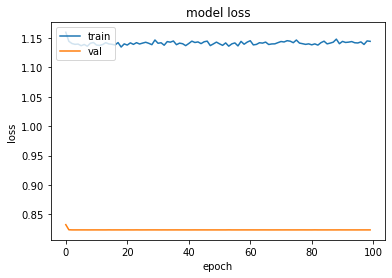

In [29]:
plt.plot(logregbottleneck_reg.train_losses)
plt.plot(logregbottleneck_reg.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# sum(np.array(y_test)[:, 1]==1)
getAUC(logregbottleneck_reg.model,X_test,y_test)

[0.5247153  0.52472222 0.52472544 ... 0.52471989 0.5247227  0.52472043]


0.4826801102495558

In [10]:
concept_weights_tot = []
concept_weights_tot_raw = []

train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
for r in range(1,2):
    concept_weights_aggr = []
    concept_weights_aggr_raw = []
    
    concept_weights=[]
    concept_weights_raw=[]
    # initialize model
    logregbottleneck = initializeModel(1)

    # load trained models
    logregbottleneck.fit(train_loader, val_loader, p_weight, 
         save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r1_c1_alpha_0.01_tau_10_optlr_0.001_optwd_0.001_l1lambda_0.001.pt", 
         epochs=1000, 
         save_every_n_epochs=10)

    # get weights
    weights, weights_raw = getWeights(logregbottleneck.model)
    concept_weights.append(weights)
    concept_weights_raw.append(weights_raw)

    # aggregate concept weights for each # of concepts
    concept_weights_aggr.append(concept_weights)
    concept_weights_aggr_raw.append(concept_weights_raw)
    
    # aggregate concept weights for each train/test split
    concept_weights_tot.append(concept_weights_aggr)
    concept_weights_tot_raw.append(concept_weights_aggr_raw)

in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_alpha_0.01_tau_10_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


In [12]:
concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)
concept_weights_tot_raw_sorted = []
for i in range(concept_weights_tot_raw_avg.shape[0]):
    concept_weights_tot_raw_sorted.append(np.argsort(-concept_weights_tot_raw_avg[i], axis=1))
for i in range(len(concept_weights_tot_raw_sorted)):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    for j in range(i+1):
#         print(concept_weights_tot_raw_sorted[i][j][:5])
        print(list(map(getConcept,concept_weights_tot_raw_sorted[i][j][:5])))
        for k in range(1,6):
                print(concept_weights_tot_raw_avg[i][j][concept_weights_tot_raw_sorted[i][j][402-k]])
    print("\n")

Top 5 features associated with 1 concepts:
[('po2', 'var of indicators'), ('pco2', 'var of indicators'), ('bilirubin_total', 'slope std err'), ('glucose', 'slope std err'), ('inr', 'var of indicators')]
-0.47697383
-0.0015238178
-0.000649938
-0.00062802405
-0.0006041629




### Test concepts with 0 weights

In [281]:
def add_all_parsers(p, input_dim, changing_dim, str_type = 'linear'):
    if str_type == 'linear':
        p.add_shape(str(str_type) + '_time_23_', input_dim)
        
    p.add_shape(str(str_type) + '_mean_', changing_dim)
    p.add_shape(str(str_type) + '_var_', changing_dim)
    p.add_shape(str(str_type) + '_ever_measured_', changing_dim)
    p.add_shape(str(str_type) + '_mean_indicators_', changing_dim)
    p.add_shape(str(str_type) + '_var_indicators_', changing_dim)
    p.add_shape(str(str_type) + '_switches_', changing_dim)
    
    # slope_indicators are the same weights for all of the slope features.
    p.add_shape(str(str_type) + '_slope_', changing_dim)
    
    if str_type == 'linear':
        p.add_shape(str(str_type) + '_slope_stderr_', changing_dim)
        p.add_shape(str(str_type) + '_first_time_measured_', changing_dim)
        p.add_shape(str(str_type) + '_last_time_measured_', changing_dim)
        
    p.add_shape(str(str_type) + '_hours_above_threshold_', changing_dim)
    p.add_shape(str(str_type) + '_hours_below_threshold_', changing_dim)
    
class LogisticRegressionWithSummariesAndBottleneck(nn.Module):
    def __init__(self, 
                 input_dim, 
                 changing_dim, 
                 num_cutoff_times, 
                 num_concepts,
                 differentiate_cutoffs,
                 init_cutoffs, 
                 init_lower_thresholds, 
                 init_upper_thresholds,
                 cutoff_times_temperature = 1.0,
                 cutoff_times_init_values = None,
                 thresholds_temperature = 0.1,
                 ever_measured_temperature = 0.1,
                 switch_temperature = 0.1,
                 time_len = 6
                 ):
        """Initializes the LogisticRegressionWithSummariesAndBottleneck.
        
        Args:
            input_dim (int): number of input dimensions
            changing_dim (int): number of non-static input dimensions
            num_cutoff_tines (int): number of cutoff-time parameters
            differentiate_cutoffs (bool): indicator for whether cutoff-time parameters are learned
            init_cutoffs (function): function to initialize cutoff-time parameters
            init_lower_thresholds (function): function to initialize lower threshold parameters
            init_upper_thresholds (function): function to initialize upper threshold parameters
            cutoff_times_temperature (float): temperature used to calculate cutoff-time parameters
            thresholds_temperature (float): temperature used to calculate threshold summaries
            ever_measured_temperature (float): temperature used to calculate measurement indicator summaries
            switch_temperature (float): temperature used to calculate switch summaries
            time_len (int): number of time-steps in each trajectory
            num_concepts (int): number of concepts in bottleneck layer
        """
        super(LogisticRegressionWithSummariesAndBottleneck, self).__init__()

        self.time_len = time_len
        self.changing_dim = changing_dim
        self.num_cutoff_times = num_cutoff_times
        self.num_concepts = num_concepts
        print("self.num_concepts")
        print(self.num_concepts)
        
        self.sigmoid_for_weights = nn.Sigmoid()
        self.sigmoid_for_ever_measured = nn.Sigmoid()
        self.sigmoid_for_switches = nn.Sigmoid()
        
        self.upper_thresh_sigmoid = nn.Sigmoid()
        self.lower_thresh_sigmoid = nn.Sigmoid()
        
        self.sigmoid = nn.Sigmoid()
        
        num_total_c_weights = changing_dim * num_cutoff_times
        
        # Initialize cutoff_times to by default use all of the timesteps.
        self.cutoff_times = - 12 * torch.ones(1, num_total_c_weights).cuda()
      
            
        if differentiate_cutoffs: 
            cutoff_vals = init_cutoffs(num_total_c_weights)
            
            if cutoff_times_init_values is not None:
                cutoff_vals = cutoff_times_init_values
                
            self.cutoff_times = nn.Parameter(torch.tensor(cutoff_vals, requires_grad=True).reshape(1, num_total_c_weights).cuda())
        
        # print("cutoff_vals")
        # print(cutoff_vals)
            
        self.times = torch.tensor(np.transpose(np.tile(range(time_len), (changing_dim, 1)))).cuda()
        self.times = self.times.repeat(1, num_cutoff_times).cuda()

        self.weight_parser = WeightsParser()
        self.cs_parser = WeightsParser()
        add_all_parsers(self.weight_parser, input_dim, self.changing_dim)
        add_all_parsers(self.cs_parser, input_dim, self.changing_dim, 'cs')
        
        self.lower_thresholds = nn.Parameter(torch.tensor(init_lower_thresholds(changing_dim)).cuda())
        self.upper_thresholds = nn.Parameter(torch.tensor(init_upper_thresholds(changing_dim)).cuda())
        
        self.lower_thresholds.retain_grad()
        self.upper_thresholds.retain_grad()
        
#         print("self.lower_thresholds")
#         print(self.lower_thresholds)
        
#         print("self.upper_thresholds")
#         print(self.upper_thresholds)
        
        self.thresh_temperature = thresholds_temperature
        self.cutoff_times_temperature = cutoff_times_temperature
        self.ever_measured_temperature = ever_measured_temperature
        self.switch_temperature = switch_temperature
        
        # bottleneck layer
        # (input, mean_feats, var_feats, ever_measured, mean_ind, var_ind)
        self.bottleneck = nn.Linear(self.weight_parser.num_weights,self.num_concepts)
        self.sigmoid_bottleneck = nn.Sigmoid()
        
        # prediction task
        self.linear = nn.Linear(self.num_concepts, 2)
        
        with torch.no_grad():
            self.bottleneck.weight[self.num_concepts-1].fill_(0.) 
            self.bottleneck.bias[self.num_concepts-1].fill_(0.)
#             self.model.linear.bias.fill_(0.)
        
#         self.bottleneck.bias.requires_grad_(False)
        
#         print("self.bottleneck.weight after ")
#         print(self.bottleneck.weight)
        
#         print("self.bottleneck.bias after")
#         print(self.bottleneck.bias)
    
    def encode_patient_batch(self, patient_batch, epsilon_denom=0.01):
        # print("in encode patient batch")
	# Computes the encoding (s, x) + (weighted_summaries) in the order defined in weight_parser.
        # Returns pre-sigmoid P(Y = 1 | patient_batch)
        temperatures = torch.tensor(np.full((1, self.cs_parser.num_weights), self.cutoff_times_temperature)).cuda()
        
        # Get changing variables
        batch_changing_vars = patient_batch[:, :, :self.changing_dim]
        batch_measurement_indicators = patient_batch[:, :, self.changing_dim: self.changing_dim * 2]
        batch_measurement_repeat = batch_measurement_indicators.repeat(1, 1, self.num_cutoff_times)
        
        weight_vector = self.sigmoid_for_weights((self.times - self.cutoff_times) / temperatures).reshape(1, self.time_len, self.cs_parser.num_weights)
        # Calculate weighted mean features
        
        # Sum of all weights across time-steps
        weight_norm = torch.sum(weight_vector * batch_measurement_repeat, dim=1)
        weight_mask = torch.sum(batch_measurement_indicators, dim=1)
        
        # MEAN FEATURES

        # Calculate \sum_t (w_t * x_t * m_t)
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_mean_']
        mean_weight_vector = weight_vector[:, :, start_i : end_i]
        
        weighted_average = torch.sum(mean_weight_vector * (batch_changing_vars * batch_measurement_indicators), dim=1)

        mean_feats = (weighted_average / (torch.sum(mean_weight_vector, dim=1) + epsilon_denom))
        
        # VARIANCE FEATURES
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_var_']
        var_weight_vector = weight_vector[:, :, start_i : end_i]
        
        x_mean = torch.mean(batch_measurement_indicators * batch_changing_vars, dim=1, keepdim=True)
        weighted_variance = torch.sum(batch_measurement_indicators * var_weight_vector * (batch_changing_vars - x_mean)**2, dim=1)        
        normalizing_term = torch.sum(batch_measurement_indicators * var_weight_vector, dim=1)**2 / (torch.sum(batch_measurement_indicators * var_weight_vector, dim=1)**2 + torch.sum(batch_measurement_indicators * var_weight_vector ** 2, dim=1) + epsilon_denom)
        
        var_feats = weighted_variance / (normalizing_term + epsilon_denom)
        

        # INDICATOR FOR EVER BEING MEASURED
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_ever_measured_']
        ever_measured_weight_vector = weight_vector[:, :, start_i : end_i]
        
        ever_measured_feats = self.sigmoid_for_ever_measured( torch.sum(ever_measured_weight_vector * batch_measurement_indicators, dim=1) / (self.ever_measured_temperature * torch.sum(ever_measured_weight_vector, dim=1) + epsilon_denom)) - 0.5
        
        
        # MEAN OF INDICATOR SEQUENCE
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_mean_indicators_']
        mean_ind_weight_vector = weight_vector[:, :, start_i : end_i]
        
        weighted_ind_average = torch.sum(mean_ind_weight_vector * batch_measurement_indicators, dim=1)
        mean_ind_feats = weighted_ind_average / (torch.sum(mean_ind_weight_vector, dim=1) + epsilon_denom)
        
        # VARIANCE OF INDICATOR SEQUENCE
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_var_indicators_']
        var_ind_weight_vector = weight_vector[:, :, start_i : end_i]
                
        x_mean_ind = torch.mean(batch_measurement_indicators, dim=1, keepdim=True)
        weighted_variance_ind = torch.sum(var_ind_weight_vector * (batch_measurement_indicators - x_mean_ind)**2, dim=1)        
        normalizing_term = torch.sum(var_ind_weight_vector, dim=1)**2 / (torch.sum(var_ind_weight_vector, dim=1)**2 + torch.sum(var_ind_weight_vector ** 2, dim=1) + epsilon_denom)
        
        var_ind_feats = weighted_variance_ind / (normalizing_term + epsilon_denom)
        
        
        # COUNT OF SWITCHES
        # Compute the number of times the indicators switch from missing to measured, or vice-versa.
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_switches_']
        switches_weight_vector = weight_vector[:, :, start_i : end_i][:, :-1, :]
        
        # Calculate m_{n t + 1} - m_{ n t}
        # Sum w_t + sigmoids of each difference
        later_times = batch_changing_vars[:, 1:, :]
        earlier_times = batch_changing_vars[:, :-1, :]
        
        switch_feats = torch.sum(switches_weight_vector * torch.abs(later_times - earlier_times), dim=1) / (torch.sum(switches_weight_vector, dim=1) + epsilon_denom)
        
        # FIRST TIME MEASURED
        # LAST TIME MEASURED
        
        # For each variable in the batch, compute the first time it was measured.
        # Set equal to -1 if never measured.
        
        # For each feature, calculate the first time it was measured
        # Index of the second dimension of the indicators

        mask_max_values, mask_max_indices = torch.max(batch_measurement_indicators, dim=1)
        # if the max-mask is zero, there is no nonzero value in the row
        mask_max_indices[mask_max_values == 0] = -1
        
        first_time_feats = mask_max_indices / float(batch_measurement_indicators.shape[1])
        
        # Last time measured is the last index of the max.
        # https://discuss.pytorch.org/t/how-to-reverse-a-torch-tensor/382
        flipped_batch_measurement_indicators = torch.flip(batch_measurement_indicators, [1])
        
        mask_max_values, mask_max_indices = torch.max(flipped_batch_measurement_indicators, dim=1)
        # if the max-mask is zero, there is no nonzero value in the row
        mask_max_indices[mask_max_values == 0] = batch_measurement_indicators.shape[1]
        
        last_time_feats = (float(batch_measurement_indicators.shape[1]) - mask_max_indices) / float(batch_measurement_indicators.shape[1])
        
        # SLOPE OF L2
        # STANDARD ERROR OF L2     
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_slope_']
        slope_weight_vector = weight_vector[:, :, start_i : end_i]
        
        # Zero out the batch_changing_vars so that they are zero if the features are not measured.
        linreg_y = batch_changing_vars * batch_measurement_indicators
        
        # The x-values for this linear regression are the times.
        # Zero them out so that they are zero if the features are not measured.
        linreg_x = torch.tensor(np.transpose(np.tile(range(self.time_len), (self.changing_dim, 1)))).cuda()
        linreg_x = linreg_x.repeat(linreg_y.shape[0], 1, 1) * batch_measurement_indicators
        
        # Now, compute the slope and standard error.
        weighted_x = torch.unsqueeze(torch.sum(slope_weight_vector * linreg_x, dim = 1) / (torch.sum(slope_weight_vector, dim = 1) + epsilon_denom), 1)
        weighted_y = torch.unsqueeze(torch.sum(slope_weight_vector * linreg_y, dim = 1) / (torch.sum(slope_weight_vector, dim = 1) + epsilon_denom), 1)
        
        slope_num = torch.sum(slope_weight_vector * (linreg_x - weighted_x) * (linreg_y - weighted_y), dim=1)
        slope_den = torch.sum(slope_weight_vector * (linreg_x - weighted_x)**2, dim =1)
        
        slope_feats = slope_num / (slope_den + epsilon_denom)
        
        # If the denominator is zero, set the feature equal to 0.
        var_denom = torch.sum(slope_weight_vector * (linreg_x - weighted_x)**2, dim=1)
        slope_stderr_feats = 1 / (var_denom + epsilon_denom)
        
        slope_stderr_feats = torch.where(var_denom > 0, slope_stderr_feats, var_denom)
        
        # HOURS ABOVE THRESHOLD
        # HOURS BELOW THRESHOLD
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_hours_above_threshold_']
        above_thresh_weight_vector = weight_vector[:, :, start_i : end_i]
        
        start_i, end_i = self.cs_parser.idxs_and_shapes['cs_hours_below_threshold_']
        below_thresh_weight_vector = weight_vector[:, :, start_i : end_i]
            
        upper_features = self.upper_thresh_sigmoid((batch_changing_vars - self.upper_thresholds)/self.thresh_temperature)
        lower_features = self.lower_thresh_sigmoid((self.lower_thresholds - batch_changing_vars)/self.thresh_temperature)
                
        # (batch, timestep, features)
        # sum upper_features and lower_features across timesteps
        above_threshold_feats = torch.sum(batch_measurement_indicators * above_thresh_weight_vector * upper_features, dim=1) / (torch.sum(batch_measurement_indicators * above_thresh_weight_vector, dim=1) + epsilon_denom)
        below_threshold_feats = torch.sum(batch_measurement_indicators * below_thresh_weight_vector * lower_features, dim=1) / (torch.sum(batch_measurement_indicators * below_thresh_weight_vector, dim=1) + epsilon_denom)
        
        # feats_time_23 = patient_batch[:, 23, :]     
        feats_time_5 = patient_batch[:, 5, :] 

        cat = torch.cat((feats_time_5.float(), mean_feats.float(), var_feats.float(), ever_measured_feats.float(), mean_ind_feats.float(), var_ind_feats.float(), switch_feats.float(), slope_feats.float(), slope_stderr_feats.float(), first_time_feats.float(), last_time_feats.float(), above_threshold_feats.float(), below_threshold_feats.float()), axis=1)

        return cat
    
    def forward(self, patient_batch, epsilon_denom=0.01):
        # print("in forward bottleneck")
        # Encodes the patient_batch, then computes the forward.
        bottleneck = self.bottleneck(self.encode_patient_batch(patient_batch, epsilon_denom))
        # print("bottleneck")
        # print(bottleneck)
        sigmoid_bottleneck = self.sigmoid_bottleneck(bottleneck)
        # print("sigmoid_bottleneck")
        # print(sigmoid_bottleneck)
        output = self.linear(sigmoid_bottleneck)
        # print("output")
        # print(output)
        return output

class LogisticRegressionWithSummariesAndBottleneck_Wrapper(nn.Module):
    """
    Wrapper class to track training for a LogisticRegressionWithSummaries.
    """

    def __init__(self, 
                 input_dim, 
                 changing_dim, 
                 num_cutoff_times,
                 num_concepts,
                 differentiate_cutoffs,
                 init_cutoffs, 
                 init_lower_thresholds, 
                 init_upper_thresholds, 
                 cutoff_times_temperature = 1.0,
                 alpha = 1e-4,
                 tau = 10.,
                 opt_lr = 1e-4,
                 opt_weight_decay = 0.,
                 cutoff_times_init_values = None,
                 l1_lambda=0.,
                 cos_sim_lambda=0.,
                ):
        """Initializes the LogisticRegressionWithSummaries with training hyperparameters.
        
        Args:
            input_dim (int): number of input dimensions
            changing_dim (int): number of non-static input dimensions
            num_cutoff_tines (int): number of cutoff-time parameters
            init_cutoffs (function): function to initialize cutoff-time parameters
            init_lower_thresholds (function): function to initialize lower threshold parameters
            init_upper_thresholds (function): function to initialize upper threshold parameters
            time_len (int): number of time-steps in each trajectory
            -- 
            alpha (float): multiplicative coefficient of the horseshoe loss term
            tau (float): constant used to calculate horseshoe loss term
            opt_lr (float): learning rate for the optimizer
            opt_weight_decay (float): weight decay for the optimizer
            num_concepts (int): number of concepts in bottleneck layer
            l1_lambda (float): lambda value for L1 regularization
            cos_sim_lambda (float): lambda value for cosine similarity regularization
            
        """
        super(LogisticRegressionWithSummariesAndBottleneck_Wrapper, self).__init__()
        
        self.input_dim = input_dim
        self.changing_dim = changing_dim
        self.num_cutoff_times = num_cutoff_times
        self.num_concepts = num_concepts
        self.differentiate_cutoffs = differentiate_cutoffs
        self.init_cutoffs = init_cutoffs 
        self.init_lower_thresholds = init_lower_thresholds
        
        self.model = LogisticRegressionWithSummariesAndBottleneck(input_dim, 
                                                changing_dim, 
                                                num_cutoff_times,
                                                num_concepts,
                                                differentiate_cutoffs,                         
                                                init_cutoffs, 
                                                init_lower_thresholds, 
                                                init_upper_thresholds,
                                                cutoff_times_temperature,
                                                cutoff_times_init_values)
        
        # self.alpha = alpha
        # self.tau = tau
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr= opt_lr, weight_decay = opt_weight_decay)
        
        self.l1_lambda=l1_lambda
        self.cos_sim_lambda = cos_sim_lambda
        
        print("l1_lambda")
        print(l1_lambda)
        print("cos_sim_lambda")
        print(cos_sim_lambda)
        
    def _load_model(self, path, print_=True):
        """
        Args:
            path (str): filepath to the model
        """
        try:
            checkpoint = torch.load(path)
        except:
            return
        self.model.load_state_dict(checkpoint['model_state_dict'])
        if print_:
            print("Loaded model from " + path)
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.curr_epoch = checkpoint['epoch']
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        sleep(0.5)

    # def tensor_wrap(x, klass=torch.Tensor):
    #     return x if 'torch' in str(type(x)) else klass(x)

    def fit(self, train_loader, val_loader, p_weight, save_model_path, epochs=10000, save_every_n_epochs=100):
        """
        
        Args:
            train_loader (torch.DataLoader): 
            val_tensor (torch.DataLoader):
            p_weight (tensor): weight parameter used to calculate BCE loss 
            save_model_path (str): filepath to save the model progress
            epochs (int): number of epochs to train
        """
        
        self.loss_func = custom_bce_horseshoe
        self.train_losses = []
        self.val_losses = []
        self.curr_epoch = -1
        
        self._load_model(save_model_path)
        
        epoch_loss = 0
        
        for epoch in tqdm(range(self.curr_epoch+1, epochs)):
            if (epoch % save_every_n_epochs) == (-1 % save_every_n_epochs):
                epoch_loss = epoch_loss / num_batches
                
                self.train_losses.append(epoch_loss)
                
                # Calculate validation set loss
                val_loss = 0
                num_batches_val = 0
                for batch, data in enumerate(val_loader):
                    Xb, yb = data
                    num_batches_val += 1
           
                    # Forward pass.
                    self.model.zero_grad()
                    output = self.model(Xb)

                    # val_loss = self.loss_func(output, yb, self.model.linear.weight, p_weight) / Xb.shape[0]
                    val_loss += binary_cross_entropy_with_logits(output, yb, pos_weight = p_weight) 
                
                self.val_losses.append(val_loss.item()/num_batches_val)
                
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(),
                            'train_losses': self.train_losses,
                            'val_losses': self.val_losses,
                            }, save_model_path)
            
            epoch_loss = 0
            # num_points = 0
            num_batches = 0
            for batch, data in enumerate(train_loader):

                Xb, yb = data
                # num_points += Xb.shape[0]
                num_batches +=1

                # Forward pass.
                # print("making forward pass")
                self.model.zero_grad()
                output = self.model(Xb)

                # print("about to calculate loss")
                # print(output)
                
                # loss = self.loss_func(output, yb, self.model.linear.weight, p_weight)
                loss = binary_cross_entropy_with_logits(output, yb, pos_weight = p_weight)
#                 print("loss before")
#                 print(loss)
                
                L1_reg = torch.norm(self.model.bottleneck.weight, 1)
                
                loss = loss + self.l1_lambda * L1_reg 
                
#                 print("L1 reg")
#                 print(L1_reg)
                
                if (self.num_concepts !=1):
                    cos_sim = torch.tensor(0.,requires_grad=True).cuda()
                    concepts=np.arange(0,self.num_concepts)
                    combs = list(combinations(concepts, 2))
                    for comb in combs:
                        cos_sim=cos_sim+torch.abs(F.cosine_similarity(self.model.bottleneck.weight[comb[0]],self.model.bottleneck.weight[comb[1]],dim=0)).cuda()

                    # print("cos sim")
                    # print(cos_sim)
                    loss = loss + self.cos_sim_lambda * cos_sim

                # print("loss after")
                # print(loss)
                loss.backward()

                epoch_loss += loss.item()
                
                # don't let weight update
                self.model.bottleneck.weight.grad[self.num_concepts-1].fill_(0.) 
                self.model.bottleneck.bias.grad[self.num_concepts-1].fill_(0.)
#                 self.model.linear.bias.grad.fill_(0.)


                # update all parameters
                self.optimizer.step()
            

#             for name, param in self.model.named_parameters():
#                 if name == "bottleneck.bias":
#                     print(param)    

In [282]:
set_seed(1)
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)

logregbottleneck_reg = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                            changing_dim,
                                                                            9,                     
                                                                            3,
                                                                            True,
                                                                            init_cutoffs_randomly, 
                                                                            init_rand_lower_thresholds, 
                                                                            init_rand_upper_thresholds,
                                                                            cutoff_times_temperature=0.1,
                                                                            opt_lr = 0.0001,
                                                                            opt_weight_decay = 0,
                                                                           l1_lambda=0)
logregbottleneck_reg.cuda()
set_seed(1)
logregbottleneck_reg.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/test0weight.pt", 
                     epochs=100, 
                     save_every_n_epochs=10)

getAUC(logregbottleneck_reg.model,X_test,y_test)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

self.num_concepts
3
l1_lambda
0
cos_sim_lambda
0.0


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


[0.45558351 0.60228169 0.60220838 ... 0.50713515 0.3893989  0.40233424]


0.677730710478689

## Plot AUC vs. Reg hyperparam vs. # non-zero features (correct)

In [35]:
# Get top model's hyperparameters to run L1 regularization analysis on

# BASELINE: get top model from hyperparameter scan
for r in range(1,2):
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
        baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top1=sorted_baseline_rows[-1:]
    baseline_top1_auc=sorted_baseline_rows[-1:][:,4]
    
# BOTTLENECK: get top 5 models from hyperparameter scan
# bottleneck_top1_all = []
# bottleneck_top1_auc_all = []
# for r in range(1,2):
#     bottleneck_top5 = []
#     bottleneck_top5_aucs = []
#     for c in range(1,11):
#         file = open('./models/LOS-6-600/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
#         csvreader = csv.reader(file)
#         header = []
#         header = next(csvreader)
#         bottleneck_rows = []
#         for row in csvreader:
#                 bottleneck_rows.append(np.array(row).astype(float))
#         bottleneck_rows = np.array(bottleneck_rows)
#         sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,5])]
#         bottleneck_top1_all.append(sorted_bottleneck_rows[-1:])
#         bottleneck_top1_auc_all.append(sorted_bottleneck_rows[-1:][:,5])

In [36]:
baseline_top1

array([[1.00000000e-02, 1.00000000e+00, 1.00000000e-04, 1.00000000e-04,
        7.32105202e-01]])

In [62]:
# BOTTLENECK: get models from hyperparameter scan

bottleneck_top1_reg_all = []
bottleneck_top1_aucs_reg_all = []
for r in range(1,4):
    bottleneck_top1_reg = []
    bottleneck_top1_aucs_reg = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_top1_reg.append(sorted_bottleneck_rows[1:])
        bottleneck_top1_aucs_reg.append(sorted_bottleneck_rows[1:,4])
    bottleneck_top1_reg_all.append(bottleneck_top1_reg)
    bottleneck_top1_aucs_reg_all.append(bottleneck_top1_aucs_reg)

In [86]:
np.mean(bottleneck_top1_aucs_reg_all,axis=0)

IndexError: index 7 is out of bounds for axis 1 with size 7

### Plots by concept

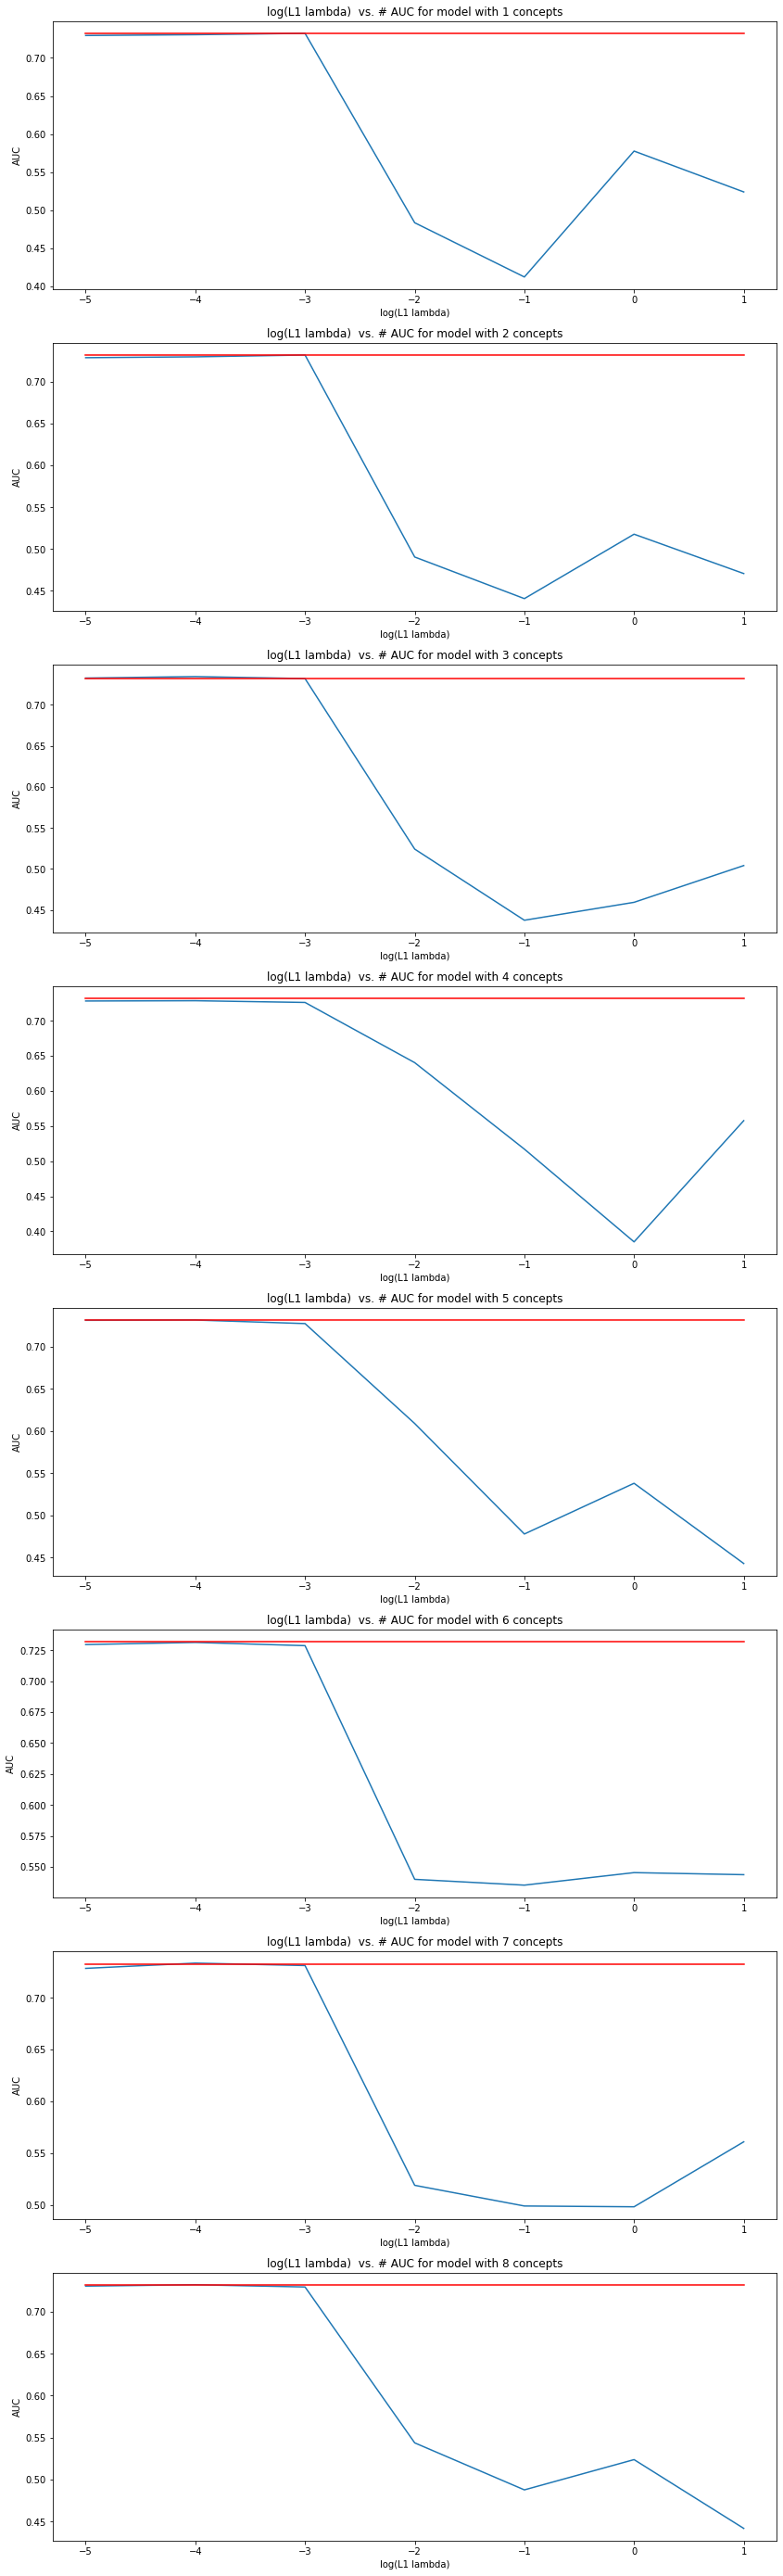

In [75]:
fig, axs = plt.subplots(8, 1,figsize=(14,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for c in range(1,9):
    axs[c-1].plot(np.log10(arr_l1_lambda),np.mean(bottleneck_top1_aucs_reg_all,axis=0)[c-1])
    axs[c-1].plot(np.arange(-5,2), np.repeat(baseline_top1_auc[0],7), '-r', label='baseline auc')
    axs[c-1].set_xlabel("log(L1 lambda)")
    axs[c-1].set_ylabel("AUC")
    axs[c-1].set_title("log(L1 lambda)  vs. # AUC for model with " + str(c)+" concepts")

### Plots by regularization strength

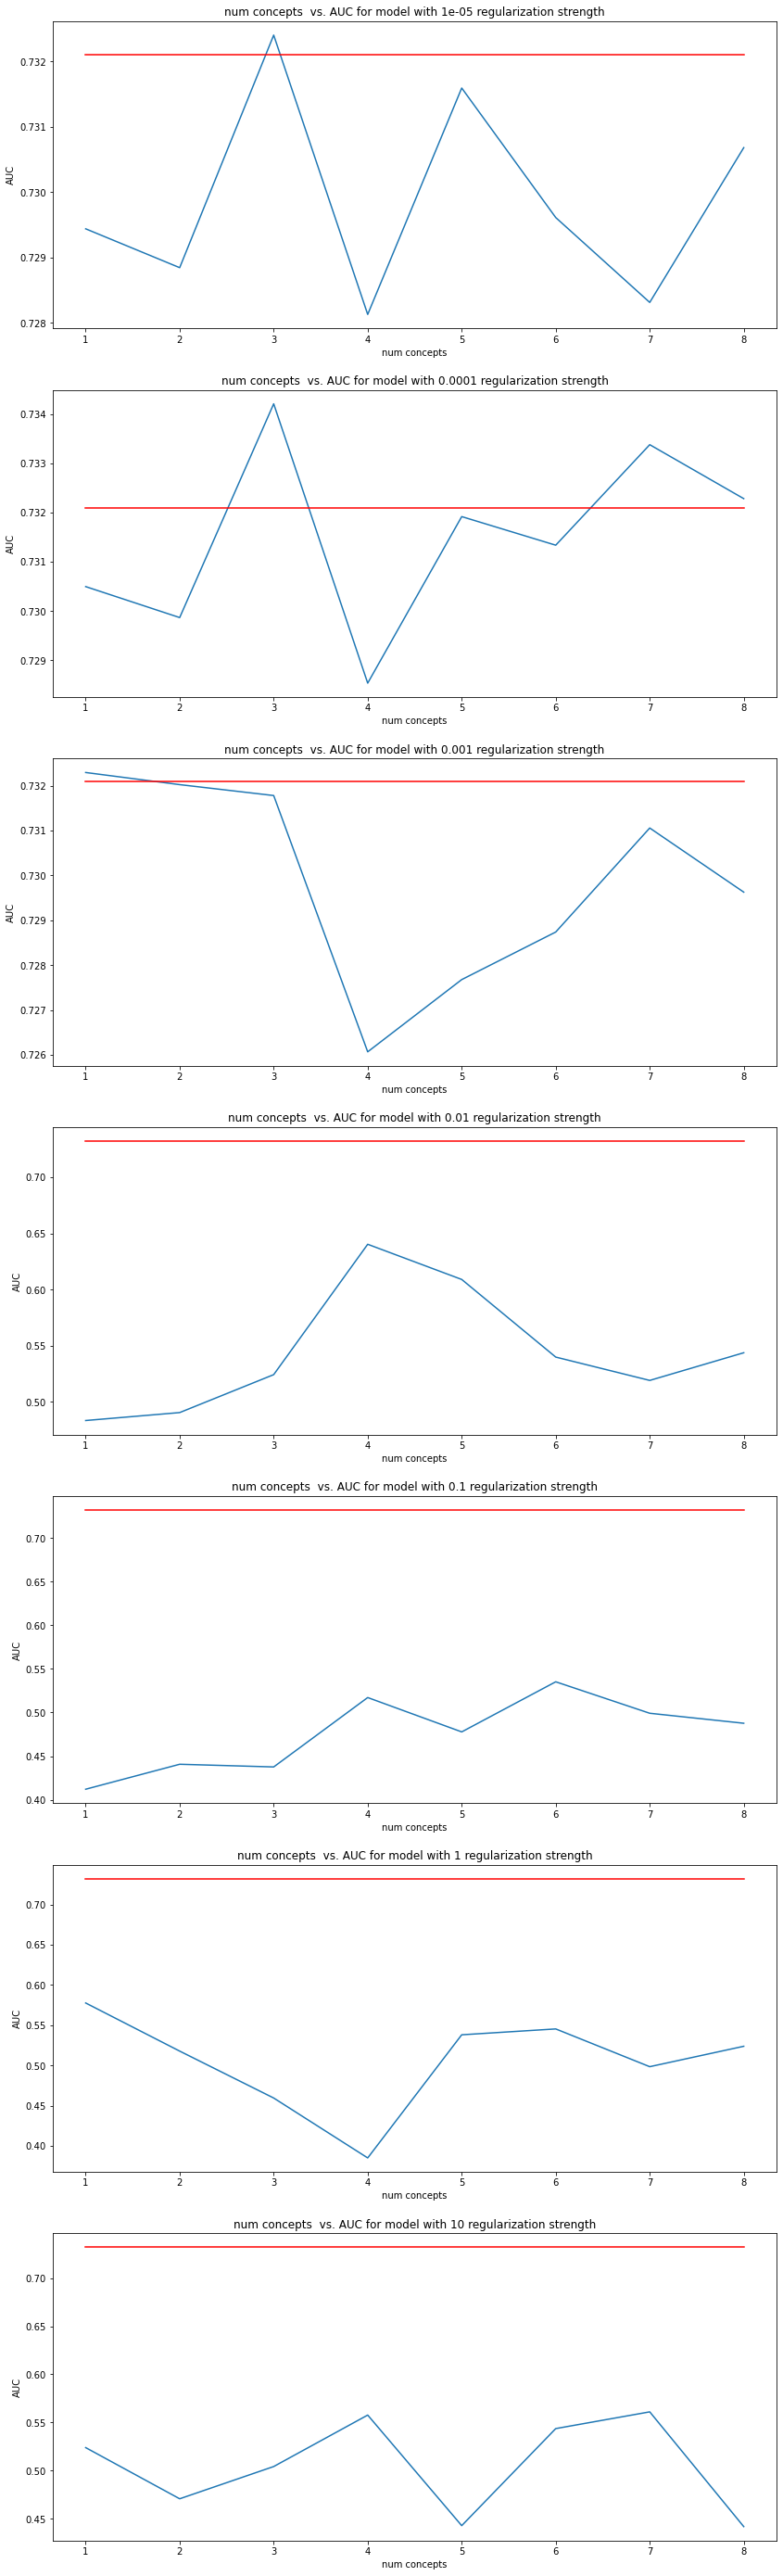

In [87]:
fig, axs = plt.subplots(7, 1,figsize=(14,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for l in range(7):
    axs[l].plot(np.arange(1,9),np.mean(bottleneck_top1_aucs_reg_all,axis=0)[:,l])
    axs[l].plot(np.arange(1,9), np.repeat(baseline_top1_auc[0],8), '-r', label='baseline auc')
# ax1.plot(arr_l1_lambda, np.repeat(baseline_top1_auc[0],6), '-r', label='baseline auc')
    axs[l].set_xlabel("num concepts")
    axs[l].set_ylabel("AUC")
    axs[l].set_title("num concepts  vs. AUC for model with " + str(arr_l1_lambda[l])+" regularization strength")

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


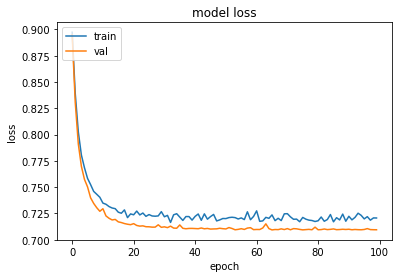

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


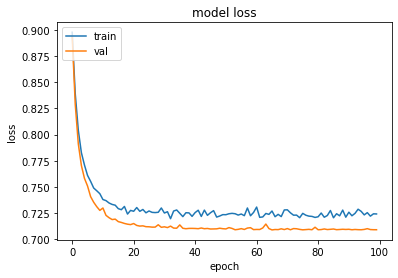

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


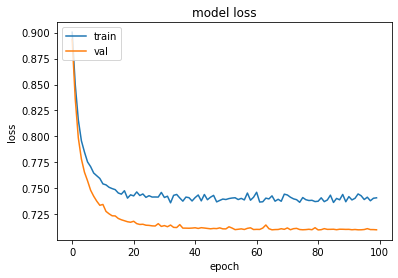

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


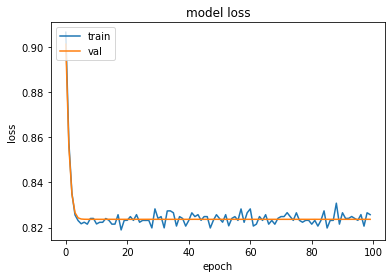

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


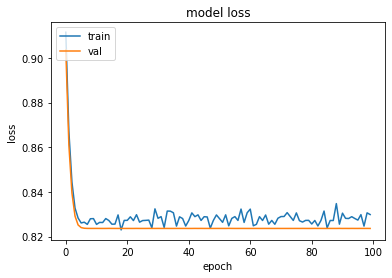

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


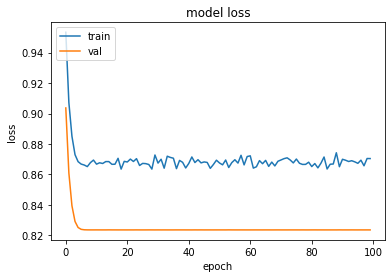

self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


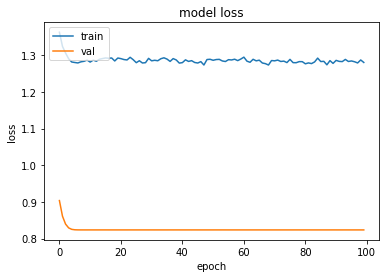

self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


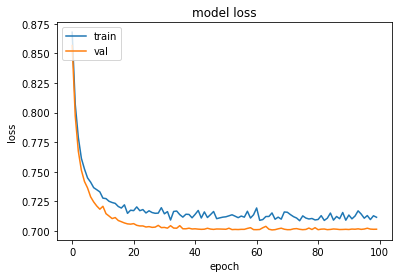

self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


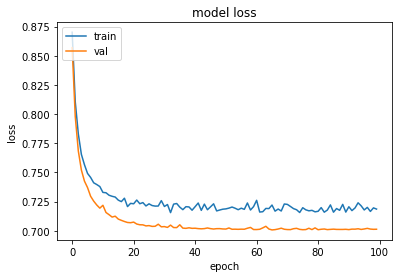

self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


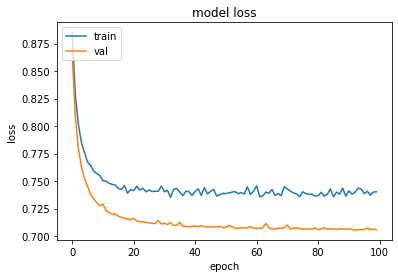

self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


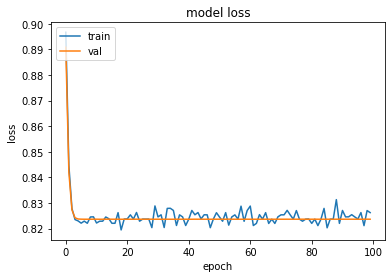

self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


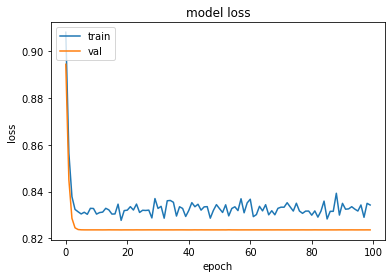

self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


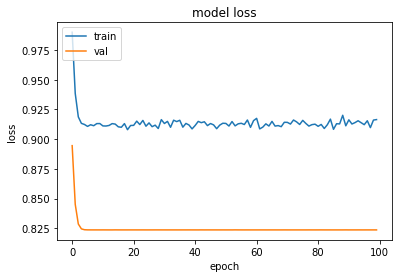

self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


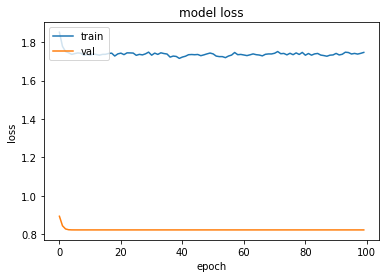

self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


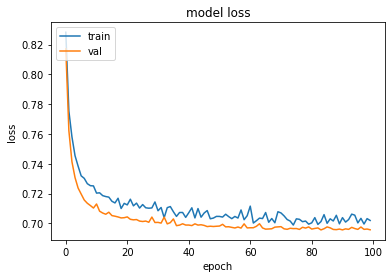

self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


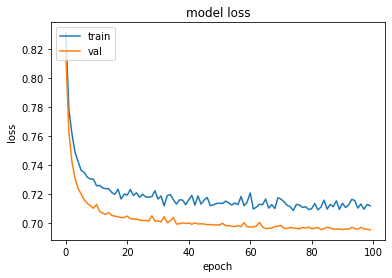

self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


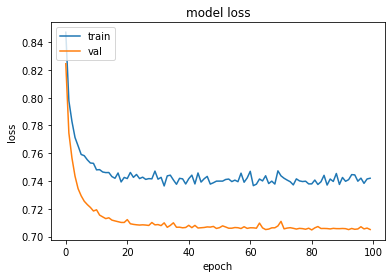

self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


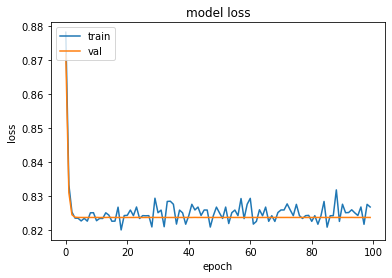

self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


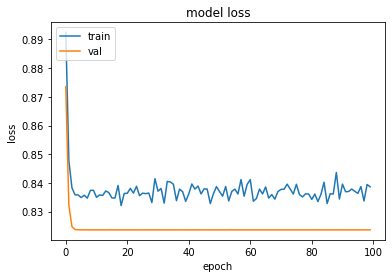

self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


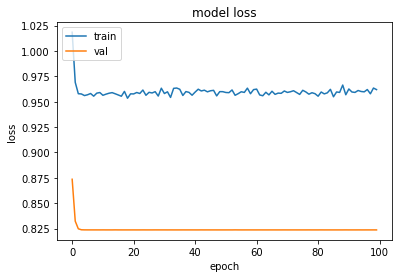

self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


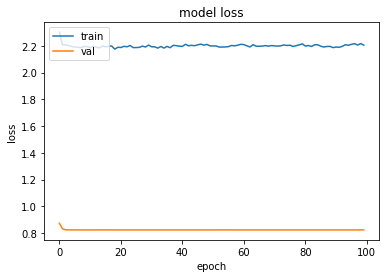

self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_1e-05.pt


0it [00:00, ?it/s]


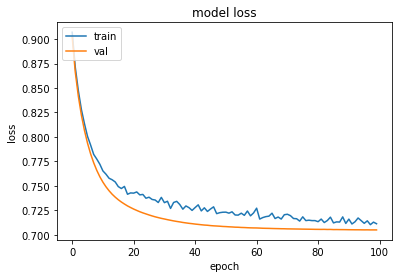

self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.0001.pt


0it [00:00, ?it/s]


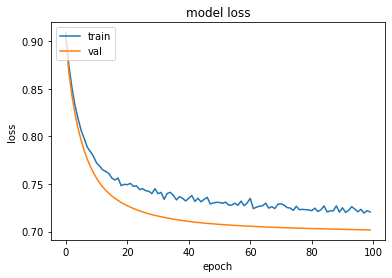

self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.001.pt


0it [00:00, ?it/s]


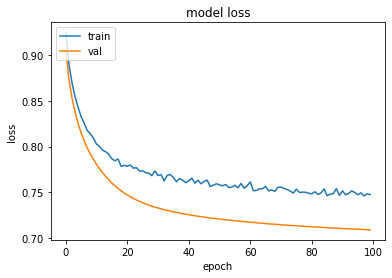

self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


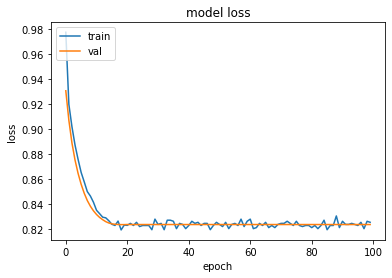

self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.1.pt


0it [00:00, ?it/s]


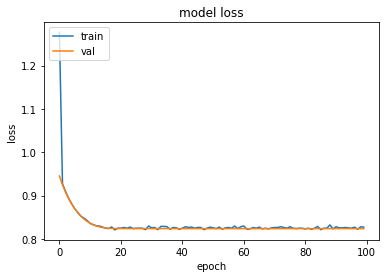

self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_1.pt


0it [00:00, ?it/s]


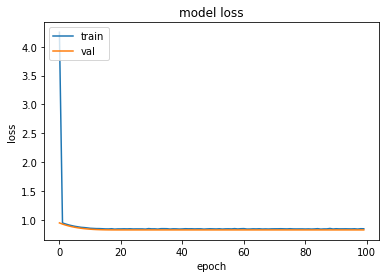

self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_10.pt


0it [00:00, ?it/s]


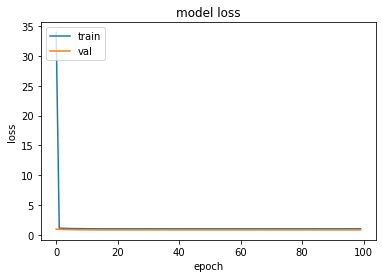

self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


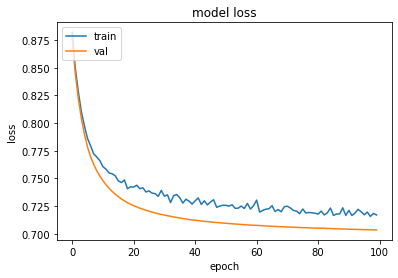

self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


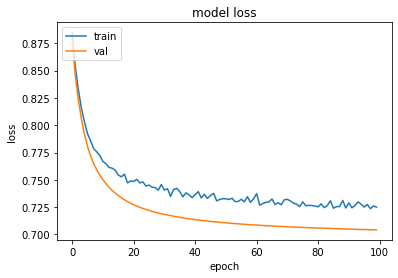

self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


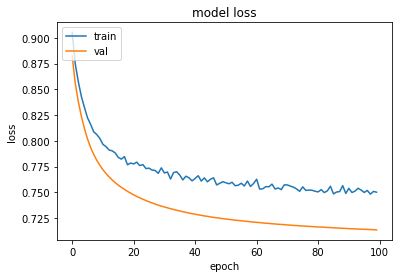

self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


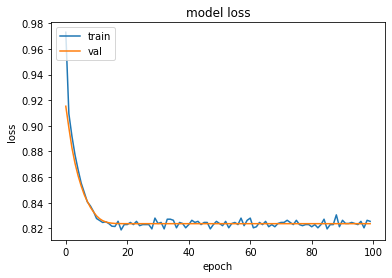

self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


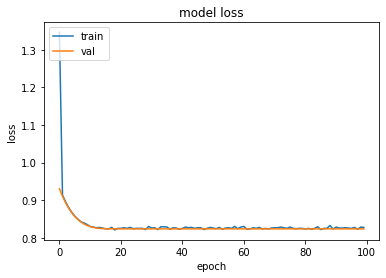

self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


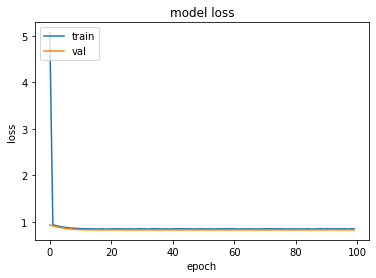

self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


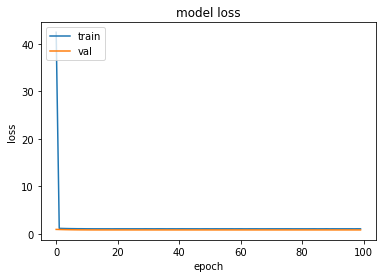

self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


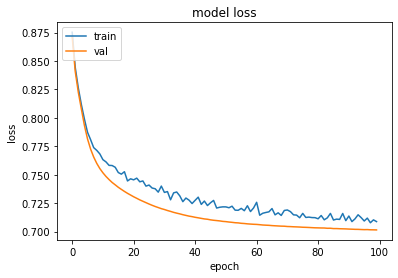

self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


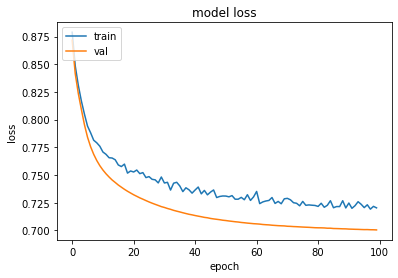

self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


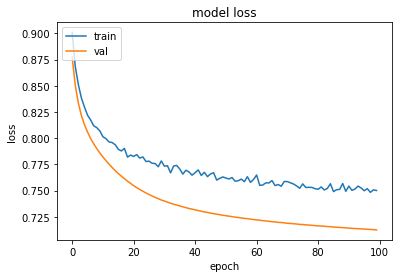

self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


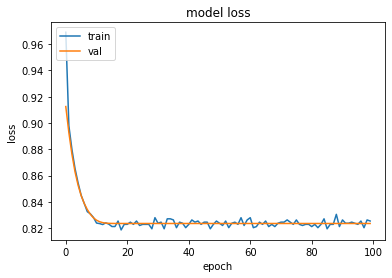

self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


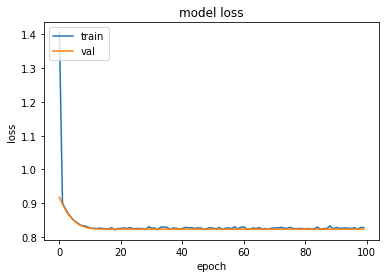

self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


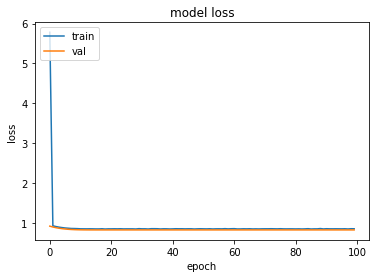

self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


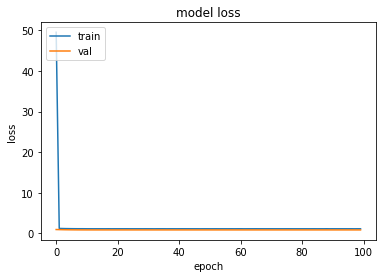

self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


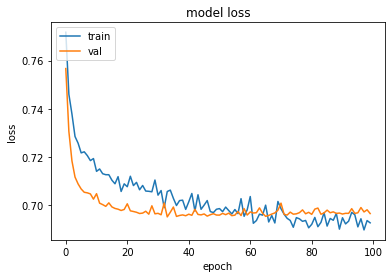

self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


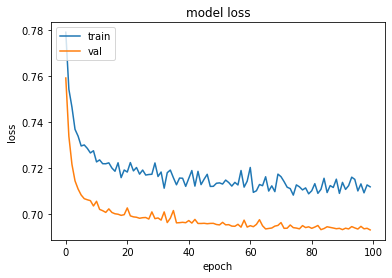

self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


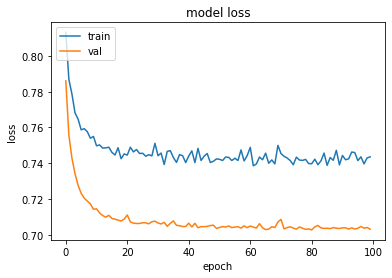

self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


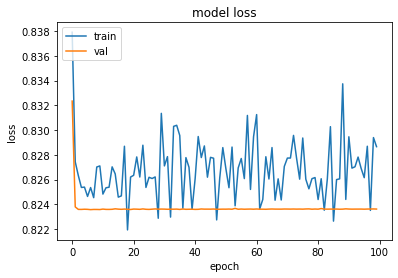

self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


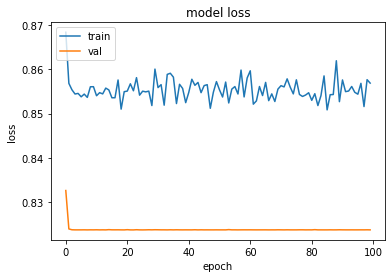

self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


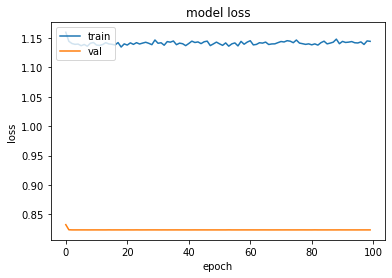

self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


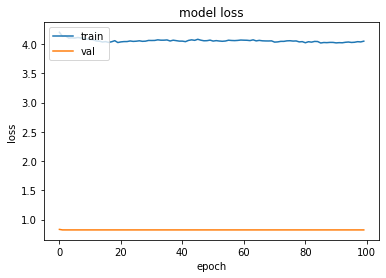

self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


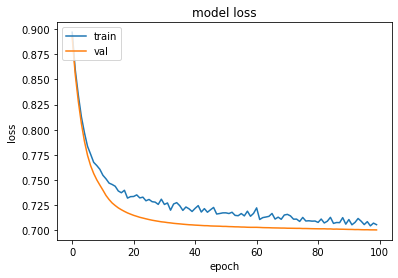

self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


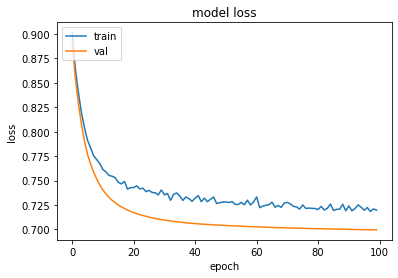

self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


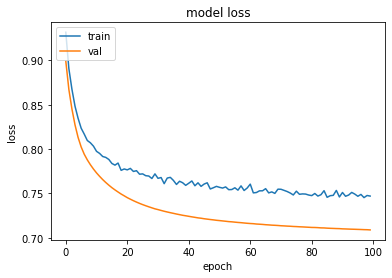

self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


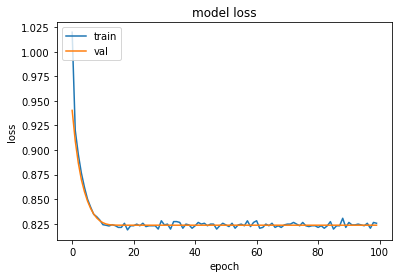

self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


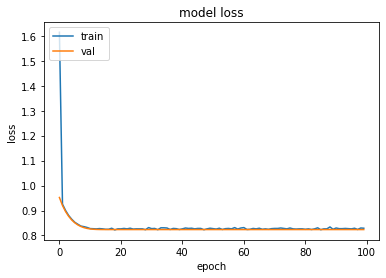

self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


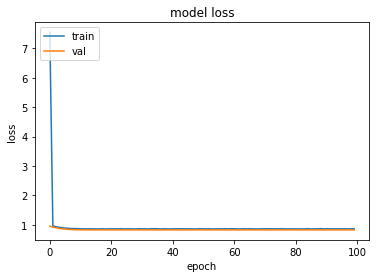

self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


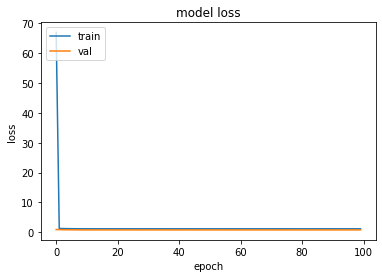

In [96]:
for r in range(1,2):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    num_non_zeroes = []
    num_non_zeroes_by_concept=[]
    raw_sum = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(row)
        non_zeroes = []
        non_zeroes_by_concept=[]
        lambdas = []
        raw_sum_by_concept = []
        for row in bottleneck_top1_reg_all[0][c-1]:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]

            # initialize model
            logregbottleneck = initializeModel(c)
            
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1lambda_{}.pt".format(r, row[0],row[1],row[2],row[3]), 
                 epochs=1000, 
                 save_every_n_epochs=10)
            plt.plot(logregbottleneck.train_losses)
            plt.plot(logregbottleneck.val_losses)
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper left')
            plt.show()
            for name, param in logregbottleneck.named_parameters():
                if "bottleneck.weight" in name:
                    bottleneck_weights = param
#             print(row)
#             print(torch.sum(sum(bottleneck_weights<=1e-5)))
            non_zeroes.append(torch.sum(bottleneck_weights>=1e-5).cpu())
            non_zeroes_by_concept.append(torch.sum(bottleneck_weights>=1e-5,axis=1).cpu())
            lambdas.append(row[3])
            raw_sum_by_concept.append(torch.norm(bottleneck_weights,1).cpu().detach().numpy())
        non_zeroes = [x for _,x in zip(np.array(lambdas)*-1,non_zeroes)]
        num_non_zeroes.append(non_zeroes)
        num_non_zeroes_by_concept.append(non_zeroes_by_concept)
        raw_sum.append(raw_sum_by_concept)
            

### lambda vs. abs value of feature weights

In [95]:
raw_sum

[[array(33.21118, dtype=float32),
  array(26.227394, dtype=float32),
  array(11.346272, dtype=float32),
  array(0.05288614, dtype=float32),
  array(0.04454377, dtype=float32),
  array(0.0414293, dtype=float32),
  array(0.04326519, dtype=float32)],
 [array(61.8577, dtype=float32),
  array(43.51249, dtype=float32),
  array(14.06147, dtype=float32),
  array(0.09990877, dtype=float32),
  array(0.08973619, dtype=float32),
  array(0.09060943, dtype=float32),
  array(0.09242848, dtype=float32)],
 [array(86.00018, dtype=float32),
  array(58.341957, dtype=float32),
  array(15.393903, dtype=float32),
  array(0.14732343, dtype=float32),
  array(0.13189474, dtype=float32),
  array(0.13472833, dtype=float32),
  array(0.1397165, dtype=float32)],
 [array(125.565216, dtype=float32),
  array(65.08093, dtype=float32),
  array(16.68952, dtype=float32),
  array(0.02578328, dtype=float32),
  array(0.01941443, dtype=float32),
  array(0.01854776, dtype=float32),
  array(0.01875393, dtype=float32)],
 [array(8

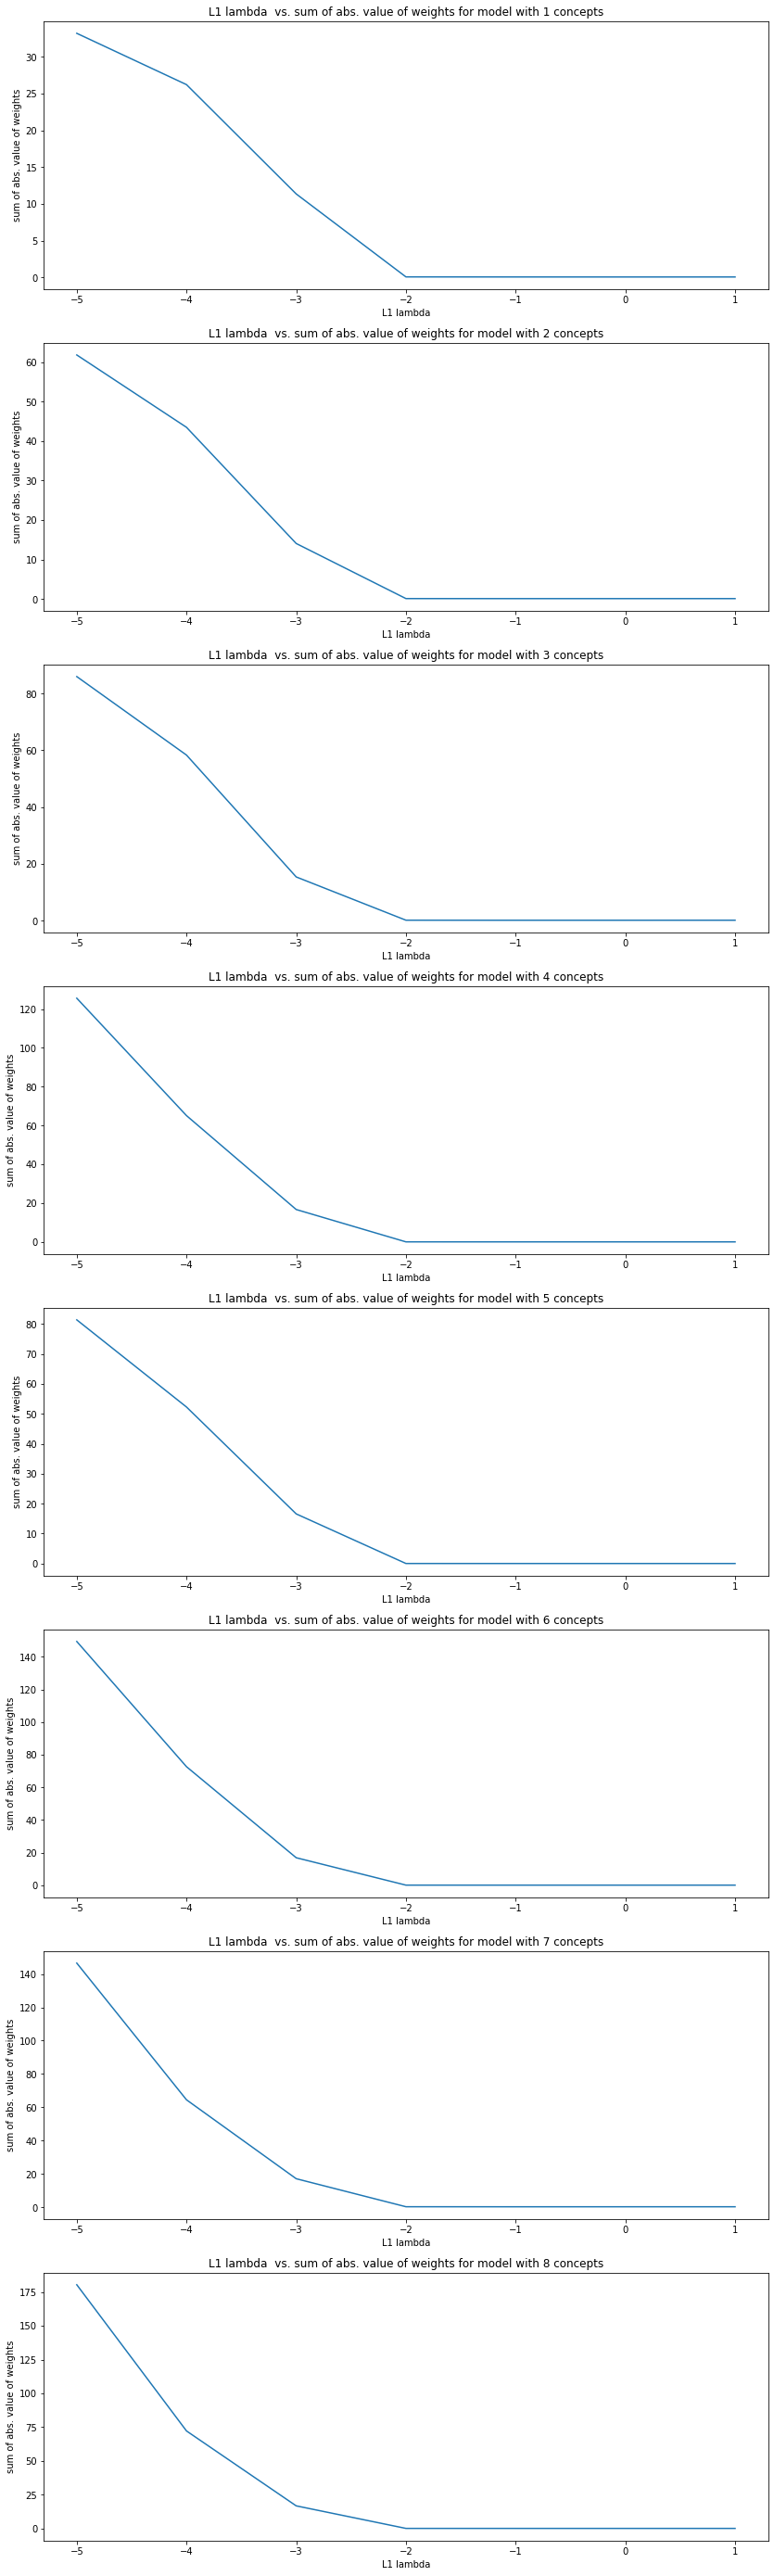

In [94]:
fig, axs = plt.subplots(8, 1,figsize=(14,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for c in range(1,9):
    axs[c-1].plot(np.log10(arr_l1_lambda),raw_sum[c-1])
# ax1.plot(arr_l1_lambda, np.repeat(baseline_top1_auc[0],6), '-r', label='baseline auc')
    axs[c-1].set_xlabel("L1 lambda")
    axs[c-1].set_ylabel("sum of abs. value of weights")
    axs[c-1].set_title("L1 lambda  vs. sum of abs. value of weights for model with " + str(c)+" concepts")

### lambda vs. # of non-zero feature weights

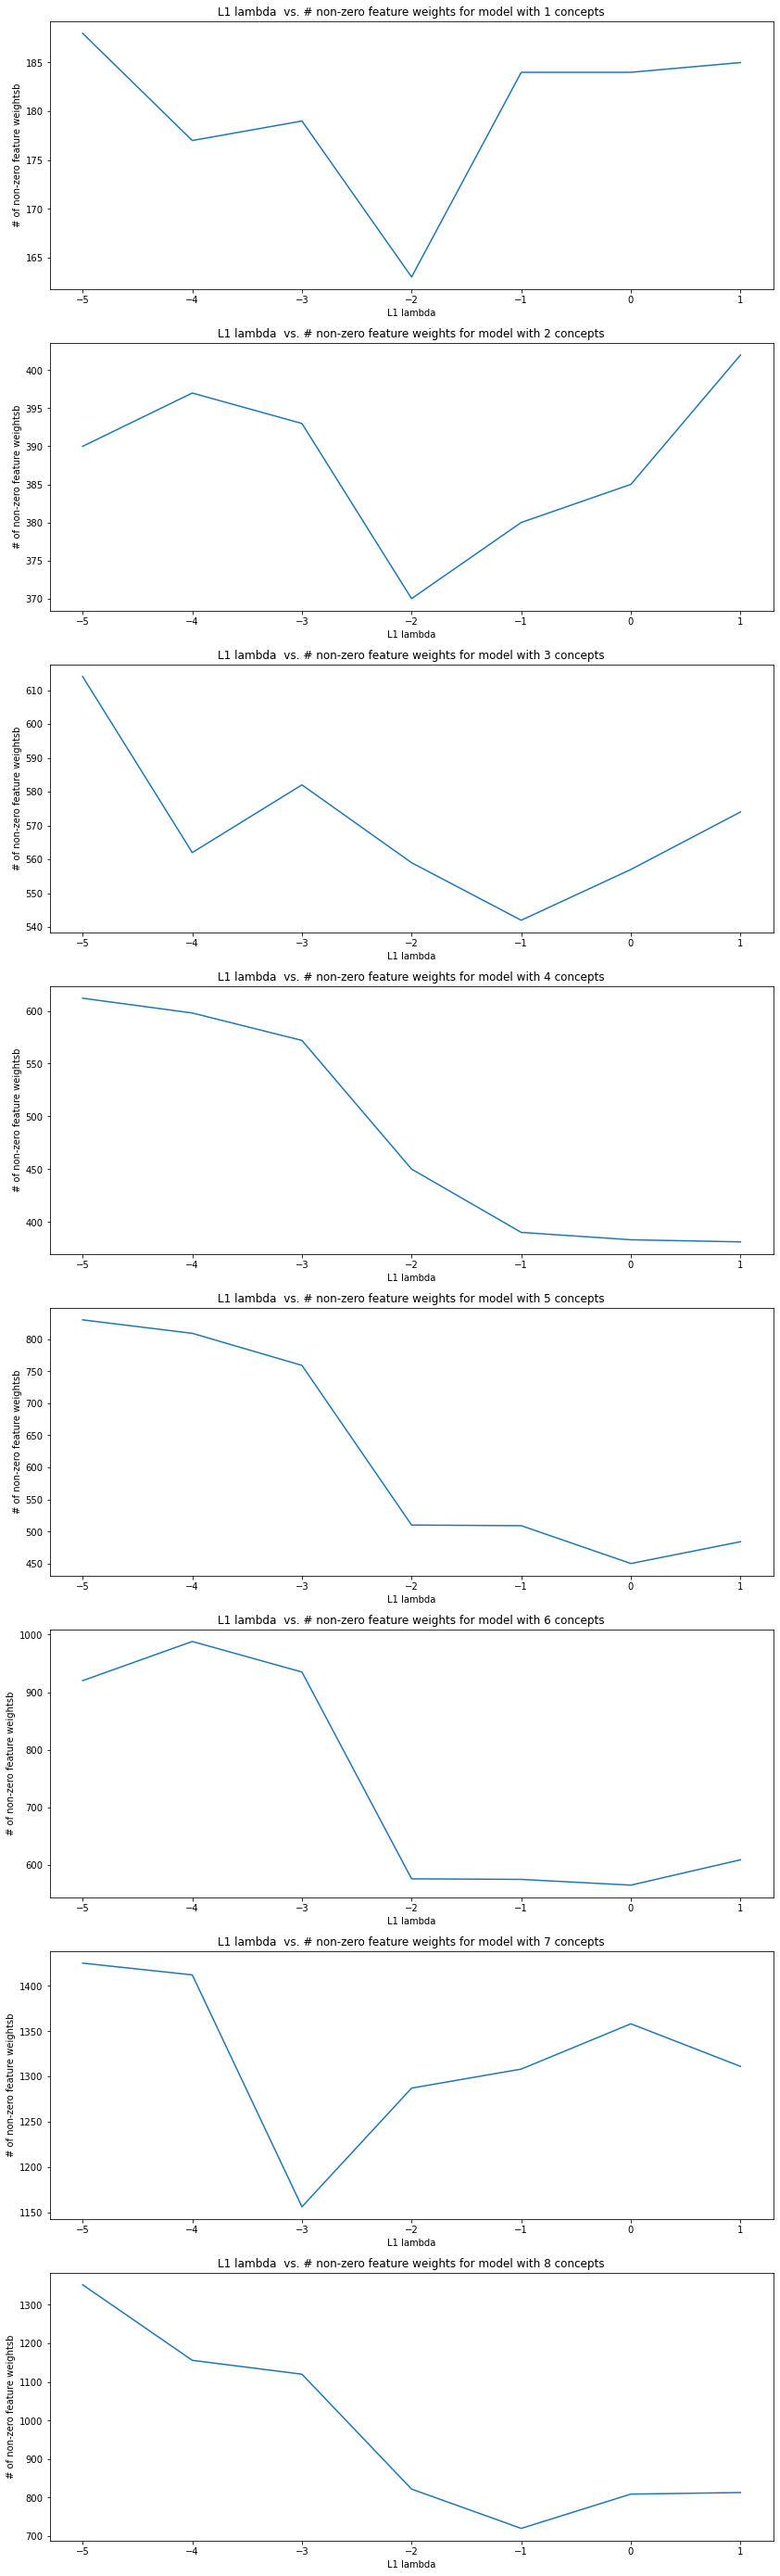

In [39]:
fig, axs = plt.subplots(8, 1,figsize=(14,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for c in range(1,9):
    axs[c-1].plot(np.log10(arr_l1_lambda),num_non_zeroes[c-1])
# ax1.plot(arr_l1_lambda, np.repeat(baseline_top1_auc[0],6), '-r', label='baseline auc')
    axs[c-1].set_xlabel("L1 lambda")
    axs[c-1].set_ylabel("# of non-zero feature weightsb")
    axs[c-1].set_title("L1 lambda  vs. # non-zero feature weights for model with " + str(c)+" concepts")

### # non-zero feature weights vs. AUC

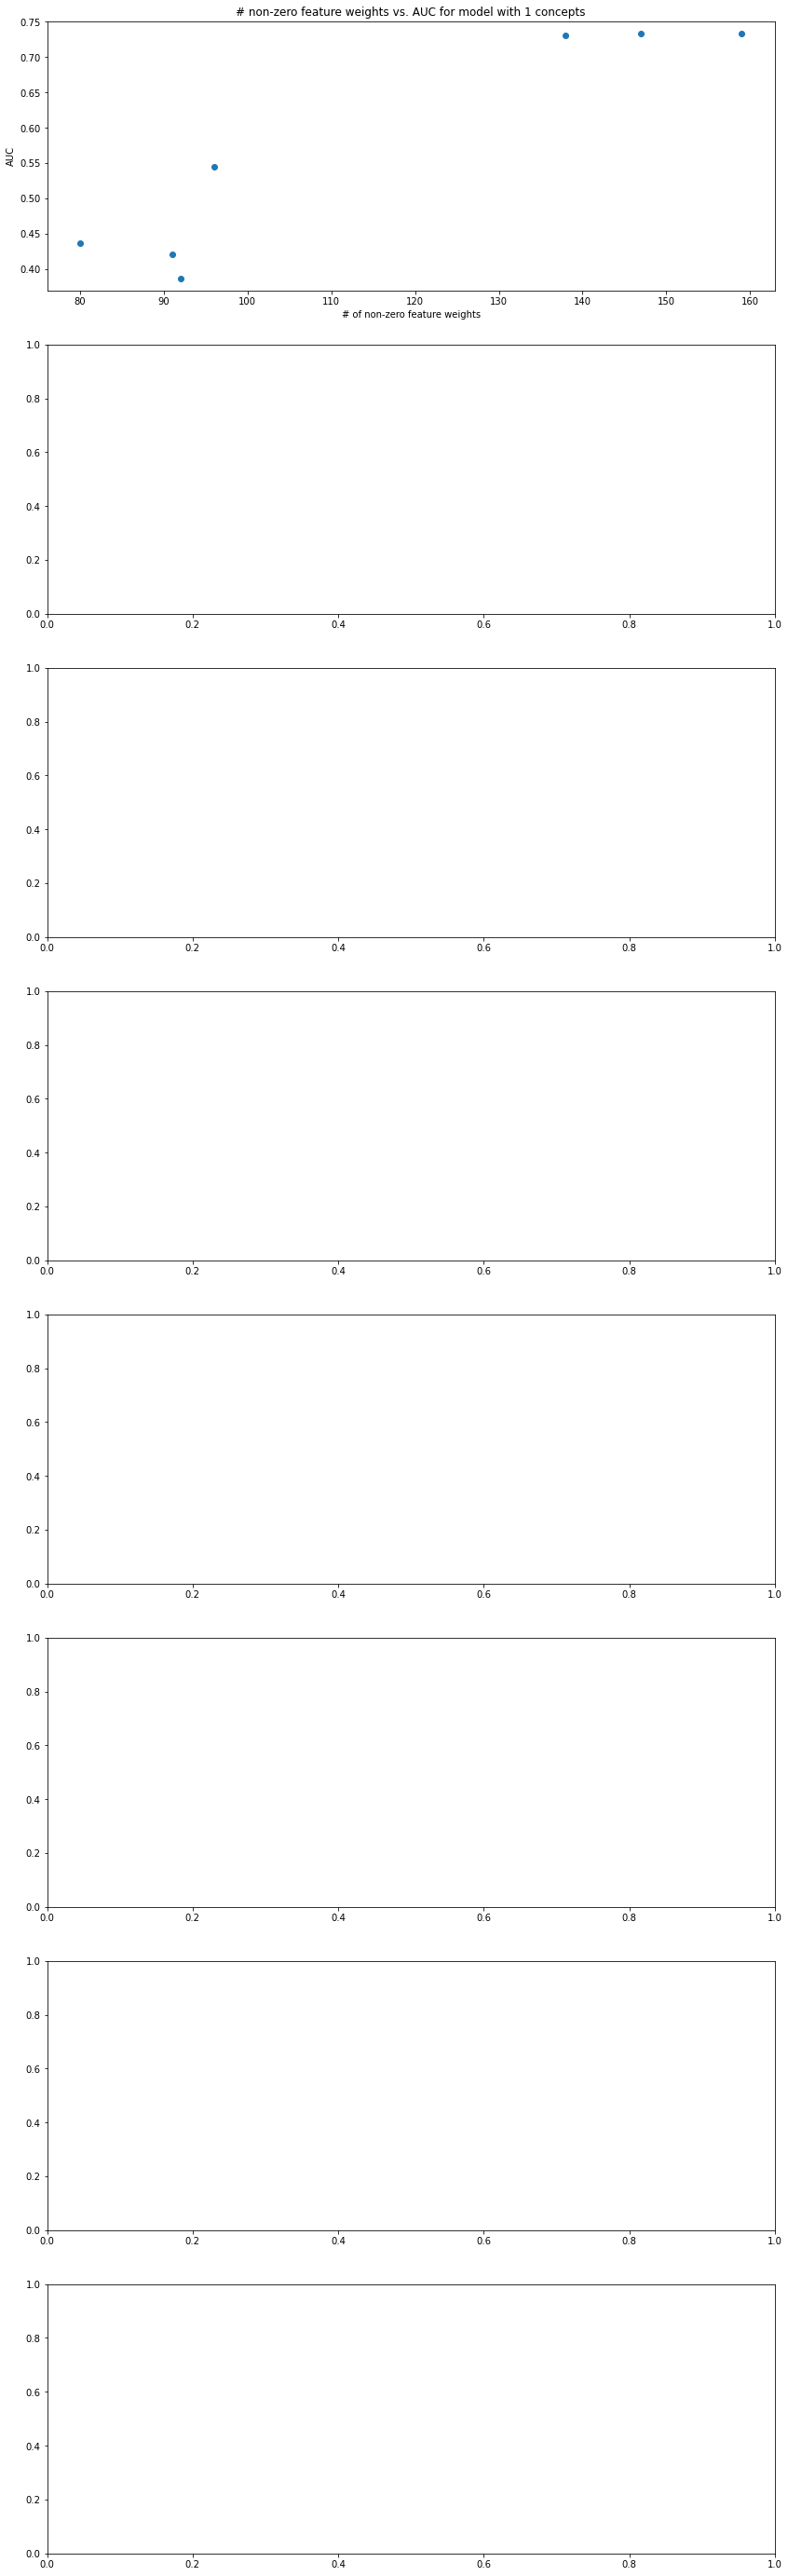

In [15]:
fig, axs = plt.subplots(8, 1,figsize=(14,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for c in range(1,2):
    axs[c-1].scatter(num_non_zeroes[c-1],np.array(bottleneck_top1_aucs_reg_all)[0,c-1,:])
# ax1.plot(arr_l1_lambda, np.repeat(baseline_top1_auc[0],6), '-r', label='baseline auc')
    axs[c-1].set_xlabel("# of non-zero feature weights")
    axs[c-1].set_ylabel("AUC")
    axs[c-1].set_title("# non-zero feature weights vs. AUC for model with " + str(c)+" concepts")

In [ ]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
logregbottleneck = initializeModel(1)
logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/test.pt", 
                     epochs=500, 
                     save_every_n_epochs=10)


## Plots with saved models

In [96]:
aucs_all = []

for r in range(1,4):
    auc_per_run = []
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    for c in range(1,9):
        auc_per_concept=[]
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_rows = bottleneck_rows[1:]
        for row in bottleneck_rows:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]

            # initialize model
            logregbottleneck = initializeModel(c)

            # load trained models
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1lambda_{}.pt".format(r, c,row[1],row[2],row[3]), 
                 epochs=1000, 
                 save_every_n_epochs=10)

            # get auc
            auc = getAUC(logregbottleneck.model,X_test,y_test)
            auc_per_concept.append(auc)
        auc_per_run.append(auc_per_concept)
    aucs_all.append(auc_per_run)

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.31396598 0.54338634 0.30729213 ... 0.42285225 0.24622478 0.32187045]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.31769165 0.5492397  0.312089   ... 0.44593927 0.24566817 0.32524073]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.33639479 0.53951961 0.35378313 ... 0.54882103 0.24507639 0.33105126]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52509451 0.52508259 0.52508634 ... 0.52508241 0.52509719 0.52509135]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52512699 0.52512354 0.5251193  ... 0.52512318 0.52512479 0.52512473]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52512014 0.52511996 0.52512163 ... 0.52511728 0.52512485 0.52512497]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52512938 0.52512878 0.52512926 ... 0.52513325 0.52512884 0.52513129]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.27451852 0.57911372 0.26959854 ... 0.51114482 0.18678567 0.33853567]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.28847766 0.58555561 0.28734231 ... 0.52479541 0.19174263 0.33941722]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.31822094 0.55590981 0.33320135 ... 0.55013669 0.1964981  0.32185411]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.5249331  0.52492541 0.52495104 ... 0.52493751 0.52492648 0.52493048]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52496636 0.52496332 0.52494186 ... 0.52496755 0.52494705 0.52495205]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52493632 0.52493578 0.52492696 ... 0.52495265 0.52493906 0.52493995]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52495128 0.52495259 0.52496862 ... 0.52496082 0.52495623 0.5249573 ]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.25144583 0.60315233 0.20723628 ... 0.44327265 0.12085865 0.33817264]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.26310393 0.60375011 0.24574742 ... 0.4567475  0.12836243 0.33054021]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.31767547 0.56796414 0.3394551  ... 0.56054205 0.18667427 0.32260659]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52484053 0.52482182 0.5248338  ... 0.52482772 0.52484185 0.52483767]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52484894 0.5248456  0.52484053 ... 0.5248366  0.5248456  0.52484906]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52485788 0.52484405 0.52484798 ... 0.52484554 0.52485424 0.52485061]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.5248614  0.52484858 0.52485472 ... 0.5248608  0.52486324 0.52485895]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.28038591 0.61549777 0.39060074 ... 0.43261409 0.18345365 0.38339177]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.30675268 0.60927963 0.34524232 ... 0.50074196 0.18586802 0.35817295]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.36844885 0.63308936 0.42460996 ... 0.64271516 0.22539911 0.3503578 ]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52577966 0.52584857 0.52582455 ... 0.52585214 0.52577531 0.52579045]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52574611 0.52575308 0.52574611 ... 0.52575374 0.52574092 0.52574128]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52573884 0.52573878 0.52574199 ... 0.52573955 0.5257383  0.52573794]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52574134 0.5257377  0.52574009 ... 0.52573758 0.52574015 0.52573967]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.29770023 0.63599515 0.33914584 ... 0.53691167 0.18205434 0.3444775 ]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.31276956 0.63388336 0.33239424 ... 0.55666804 0.18801543 0.33851257]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.36709866 0.63670301 0.43394661 ... 0.61487317 0.23084192 0.35347641]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52570516 0.52574903 0.52573508 ... 0.52575892 0.52570623 0.52571708]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52566832 0.52567375 0.52567095 ... 0.52567571 0.52566993 0.52567142]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52566075 0.52565932 0.52565747 ... 0.52566057 0.52566016 0.52565998]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52566361 0.52565938 0.52565885 ... 0.52565986 0.52566648 0.52566683]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.27967978 0.59310788 0.31518281 ... 0.47926989 0.14186791 0.35497519]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.30507329 0.59200704 0.29854903 ... 0.54528326 0.15147218 0.34498069]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.37212655 0.62971932 0.41665149 ... 0.62093675 0.21312715 0.35764799]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52572477 0.52577609 0.52575523 ... 0.52578133 0.5257268  0.5257386 ]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52567577 0.52568495 0.52568513 ... 0.52568489 0.52567846 0.52568054]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52567643 0.52567148 0.52567136 ... 0.52567339 0.52567416 0.52567291]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52567589 0.52567953 0.52568221 ... 0.52567381 0.5256803  0.52567834]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.22896072 0.65053236 0.2294066  ... 0.38069174 0.09343703 0.29982844]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.26092476 0.63250053 0.24601267 ... 0.47856724 0.1471355  0.33442324]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.32981178 0.58842534 0.35076037 ... 0.5960747  0.17565034 0.3258003 ]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52469993 0.52470958 0.52471215 ... 0.52470505 0.52470052 0.52469897]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52470791 0.52470917 0.52469403 ... 0.52471763 0.52470624 0.5247072 ]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52472711 0.52473789 0.5247333  ... 0.5247339  0.52472246 0.52472287]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.5247153  0.52472222 0.52472544 ... 0.52471989 0.5247227  0.52472043]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.29545575 0.57639164 0.32623383 ... 0.46521726 0.13193719 0.34538624]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.33217508 0.58408684 0.30242029 ... 0.50927234 0.15203176 0.33682182]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.36772978 0.62105525 0.41459748 ... 0.60865021 0.21400218 0.35242563]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52567345 0.52572429 0.5257045  ... 0.52573109 0.52567279 0.52568364]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52562314 0.52562505 0.52562362 ... 0.52562642 0.52562332 0.52562433]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52562261 0.5256229  0.52562159 ... 0.52562243 0.5256241  0.52562284]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.5256207  0.52562648 0.52562559 ... 0.52562708 0.52562112 0.52562249]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.46778965 0.60937572 0.46823114 ... 0.63137019 0.26948375 0.41239789]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.46180305 0.61314356 0.47318983 ... 0.63319707 0.27219912 0.42815623]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.43256989 0.5949164  0.46985123 ... 0.64727801 0.30174634 0.49009326]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52509916 0.52510136 0.52510118 ... 0.52510029 0.52510369 0.52510238]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52512413 0.52512795 0.52512938 ... 0.5251292  0.52513039 0.52512711]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52513003 0.52513337 0.52513373 ... 0.52512997 0.52513242 0.52513003]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52513075 0.5251236  0.52512574 ... 0.52512991 0.52512538 0.52512503]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.51526552 0.64508539 0.48757154 ... 0.57988667 0.27591097 0.39986652]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.49977234 0.63434976 0.47392088 ... 0.59504277 0.26250184 0.42584154]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.41716099 0.59155262 0.48111364 ... 0.64099932 0.29696396 0.49278796]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52518243 0.52518791 0.52519065 ... 0.52519614 0.5252046  0.52519017]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52517015 0.52517313 0.52517313 ... 0.52517635 0.52516395 0.52517223]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52516794 0.52517635 0.52516866 ... 0.52515632 0.52515262 0.5251478 ]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52517521 0.52517897 0.52518213 ... 0.5251689  0.52517748 0.52517909]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.49437928 0.670349   0.55975467 ... 0.61644888 0.30639228 0.41510886]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.49372947 0.64891922 0.52364194 ... 0.6243372  0.286055   0.41566151]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.4128612  0.58787102 0.48601601 ... 0.63725811 0.30141515 0.49912238]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.5253188  0.52530938 0.52532059 ... 0.52533877 0.5253337  0.52537835]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52533311 0.52530932 0.52532566 ... 0.52530813 0.52533317 0.52532631]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52530754 0.52530855 0.52531332 ... 0.52530265 0.52530241 0.52531469]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52529567 0.52527386 0.52529204 ... 0.52530152 0.52528197 0.52529532]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.0001_optwd_0_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.46682698 0.69070345 0.51526576 ... 0.73122007 0.2761848  0.52602881]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.0001_optwd_0_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.4569349  0.64917374 0.54100573 ... 0.72205722 0.26935133 0.55478936]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.0001_optwd_0_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.42171118 0.60067612 0.54460371 ... 0.64980143 0.33619303 0.56837136]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.45447889 0.61618596 0.55728799 ... 0.56045151 0.4159115  0.57011795]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.0001_optwd_0_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52561516 0.5256117  0.52561021 ... 0.52561253 0.52561373 0.52561468]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.0001_optwd_0_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52561188 0.52561224 0.52561426 ... 0.52561253 0.52560884 0.52561355]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.0001_optwd_0_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52561545 0.5256145  0.52561545 ... 0.52561325 0.52561343 0.52561945]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.47450346 0.65096104 0.50818795 ... 0.66763711 0.28126261 0.51603121]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.46611053 0.6421544  0.50989985 ... 0.66978097 0.28730744 0.52587324]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.44039506 0.58991045 0.53626388 ... 0.64653575 0.34248531 0.57429904]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52539831 0.52538544 0.52537698 ... 0.52539551 0.5254069  0.52544147]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52534372 0.52534801 0.52534848 ... 0.52534753 0.52534539 0.52534604]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52533907 0.52534032 0.52534252 ... 0.52534527 0.52534193 0.52534652]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52535236 0.52534902 0.52534956 ... 0.52535284 0.52535224 0.52535677]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.47580415 0.68767166 0.49419808 ... 0.62032062 0.27037311 0.4764114 ]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.47345269 0.66087604 0.5047909  ... 0.70838857 0.27076355 0.50398171]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.43369234 0.58969355 0.53841937 ... 0.66031492 0.34606016 0.56271905]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52549547 0.52549428 0.52548569 ... 0.5254916  0.52549833 0.52552241]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52548909 0.52549231 0.52548891 ... 0.5254879  0.52548629 0.5254904 ]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52549368 0.52549297 0.52549404 ... 0.52549058 0.52549249 0.52549189]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52548045 0.52548367 0.52548319 ... 0.52548379 0.52548087 0.52548677]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.48723602 0.67188585 0.55836618 ... 0.45843455 0.3383466  0.42117292]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.49638167 0.65748602 0.5259738  ... 0.54990721 0.31045869 0.43579942]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.41739041 0.58362103 0.4850398  ... 0.633717   0.2975308  0.49735922]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52587658 0.52588046 0.52588654 ... 0.52590203 0.5258863  0.52589768]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52586216 0.52585727 0.52585453 ... 0.52586353 0.5258466  0.52584863]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52587146 0.5258556  0.5258733  ... 0.52588016 0.52587634 0.5258714 ]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52586842 0.52586347 0.52586997 ... 0.52586955 0.52587575 0.52587718]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.47475916 0.725725   0.52119201 ... 0.66888016 0.32017079 0.43073583]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.45920992 0.68118912 0.52414405 ... 0.69239116 0.31206587 0.4757117 ]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.43840951 0.58921939 0.53637612 ... 0.6596033  0.34966287 0.55084521]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52543694 0.52542448 0.525428   ... 0.52543539 0.52544272 0.52546018]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52541208 0.52541357 0.52541643 ... 0.52541727 0.52541357 0.52541429]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52541482 0.52542228 0.52542204 ... 0.52542138 0.52542043 0.52541196]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52541292 0.5254159  0.52541417 ... 0.5254162  0.52541631 0.52541453]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.27467504 0.37785885 0.46156964 ... 0.47058517 0.28868085 0.35882512]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.27787825 0.39595783 0.46781689 ... 0.4746289  0.29115391 0.37363181]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.29066154 0.41857401 0.46963483 ... 0.48443314 0.29331487 0.44028661]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52567178 0.52569866 0.52567357 ... 0.52566481 0.52566642 0.52564073]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52568042 0.52568281 0.52566808 ... 0.52568817 0.52567703 0.52568108]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52567071 0.52567357 0.52566922 ... 0.52567679 0.52566624 0.52567744]
self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52567649 0.5256778  0.52566838 ... 0.52567393 0.52567416 0.52567106]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.21262407 0.32051688 0.44830263 ... 0.50517368 0.26797548 0.36892027]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.22089165 0.35555291 0.45618445 ... 0.50538421 0.26528624 0.3748064 ]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.2687256  0.44138929 0.46830663 ... 0.50380939 0.275994   0.46045738]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52545589 0.5254634  0.52545613 ... 0.52544498 0.52546489 0.52545249]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52544159 0.52544272 0.52544671 ... 0.52544028 0.52543753 0.52544373]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52545893 0.52545393 0.52544403 ... 0.52544832 0.52544504 0.52544945]
self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52546215 0.52545124 0.52545631 ... 0.52545637 0.52545506 0.52544916]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.21514261 0.36638212 0.45100242 ... 0.49714759 0.3025369  0.42568421]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.21531242 0.3859067  0.46243623 ... 0.50133288 0.28159153 0.41442454]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.26905504 0.44788364 0.47194764 ... 0.50372314 0.27669677 0.46984449]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52530825 0.52531064 0.52530819 ... 0.52530694 0.52530783 0.52531034]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52529931 0.52529639 0.52529949 ... 0.52530897 0.52529913 0.52530652]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52532876 0.52532572 0.52532011 ... 0.5253123  0.52532876 0.52532196]
self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52532911 0.52533293 0.52531916 ... 0.52532893 0.52532619 0.52532661]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.28520152 0.46245429 0.52603322 ... 0.53553194 0.3053925  0.50350964]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.28820857 0.44520169 0.53338182 ... 0.53870481 0.29912099 0.51136804]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.31701812 0.48897564 0.504076   ... 0.54177123 0.30850902 0.51362991]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52415091 0.52885801 0.52415508 ... 0.52673423 0.52416885 0.52414614]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52599919 0.52599579 0.52599978 ... 0.52599698 0.52599537 0.52599448]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0_l1lambda_1.pt


0it [00:00, ?it/s]


[0.5259912  0.52599221 0.52599388 ... 0.52599096 0.52599233 0.52599293]
self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52599347 0.52599335 0.52599478 ... 0.5259909  0.52598995 0.52599132]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.27954972 0.47269532 0.53322953 ... 0.51861459 0.29998982 0.47646374]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.28124142 0.47161931 0.53945017 ... 0.51867056 0.29365766 0.48446801]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.32459161 0.50402993 0.50765306 ... 0.52064902 0.3316479  0.48980024]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.49258307 0.58284819 0.4921172  ... 0.54477698 0.4921861  0.49214509]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52593136 0.52593029 0.52593035 ... 0.52593076 0.52592432 0.52592957]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52593809 0.52593905 0.52593863 ... 0.52593458 0.52593964 0.52593714]
self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52592695 0.52593005 0.52592885 ... 0.5259307  0.52593178 0.52593225]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.23661543 0.47018757 0.56816006 ... 0.50873291 0.3068828  0.47442916]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.23699704 0.45877078 0.56068403 ... 0.52064353 0.27590534 0.48541972]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.30175239 0.48216221 0.51684213 ... 0.54724777 0.33126691 0.50182092]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52598101 0.52599102 0.52598149 ... 0.52598339 0.52598518 0.52597725]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.5259878  0.52598673 0.52598965 ... 0.52598059 0.52598464 0.52598554]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52598661 0.52598953 0.52598679 ... 0.52598637 0.52598679 0.52598679]
self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52598113 0.52597946 0.52598369 ... 0.52598131 0.52598363 0.52598411]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.22259079 0.33191004 0.46166438 ... 0.48467016 0.26437947 0.3868123 ]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.21705258 0.43556702 0.46037924 ... 0.46893871 0.28579086 0.44711643]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.27153283 0.4494321  0.47393757 ... 0.50255412 0.27768302 0.47697333]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52496237 0.52497    0.52497298 ... 0.52496421 0.52496904 0.52495837]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.52498817 0.52498841 0.52498674 ... 0.524984   0.52498376 0.5249871 ]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.001_optwd_0.001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52498031 0.52498317 0.52498198 ... 0.5249815  0.52498251 0.52497965]
self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.001_optwd_0.001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52497518 0.52497363 0.52497691 ... 0.5249812  0.52498156 0.52497768]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.0001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


[0.24252141 0.48498443 0.55606908 ... 0.51818877 0.30047998 0.4780148 ]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


[0.25656474 0.46249935 0.56160498 ... 0.52695066 0.2819427  0.49375308]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


[0.31894928 0.49153551 0.51029003 ... 0.51742965 0.32850319 0.4950307 ]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.01.pt


0it [00:00, ?it/s]


[0.52599353 0.52599472 0.52599472 ... 0.52599061 0.52599567 0.52598798]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.1.pt


0it [00:00, ?it/s]


[0.5259949  0.52599281 0.52599424 ... 0.52599782 0.52599388 0.52599597]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.0001_l1lambda_1.pt


0it [00:00, ?it/s]


[0.52599806 0.52599722 0.52599806 ... 0.5259977  0.5259974  0.52599925]
self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.0001_l1lambda_10.pt


0it [00:00, ?it/s]


[0.52600044 0.5260008  0.52600074 ... 0.52600068 0.526003   0.52600127]


In [242]:
np.mean(aucs_all,axis=0).shape

(8, 7)

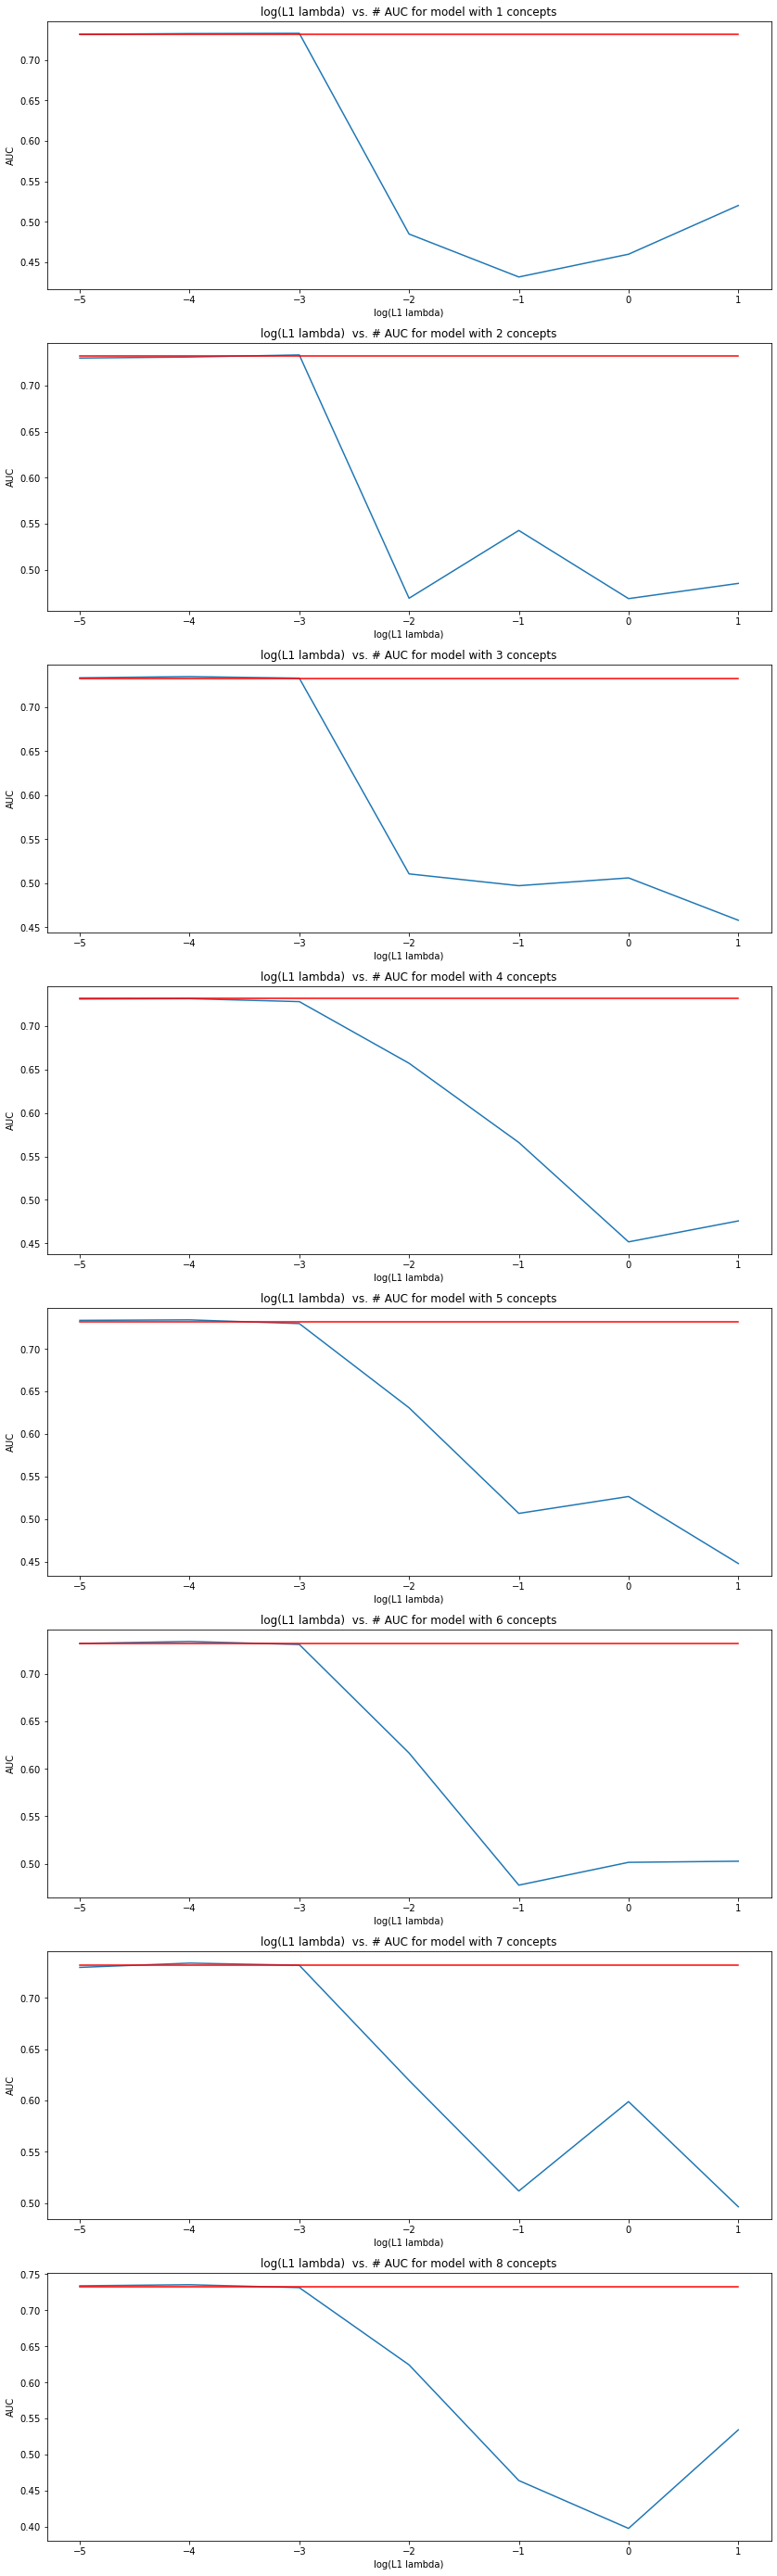

In [243]:
fig, axs = plt.subplots(8, 1,figsize=(14,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for c in range(1,9):
    axs[c-1].plot(np.log10(arr_l1_lambda),np.mean(aucs_all,axis=0)[c-1])
    axs[c-1].plot(np.arange(-5,2), np.repeat(baseline_top1_auc[0],7), '-r', label='baseline auc')
    axs[c-1].set_xlabel("log(L1 lambda)")
    axs[c-1].set_ylabel("AUC")
    axs[c-1].set_title("log(L1 lambda)  vs. # AUC for model with " + str(c)+" concepts")

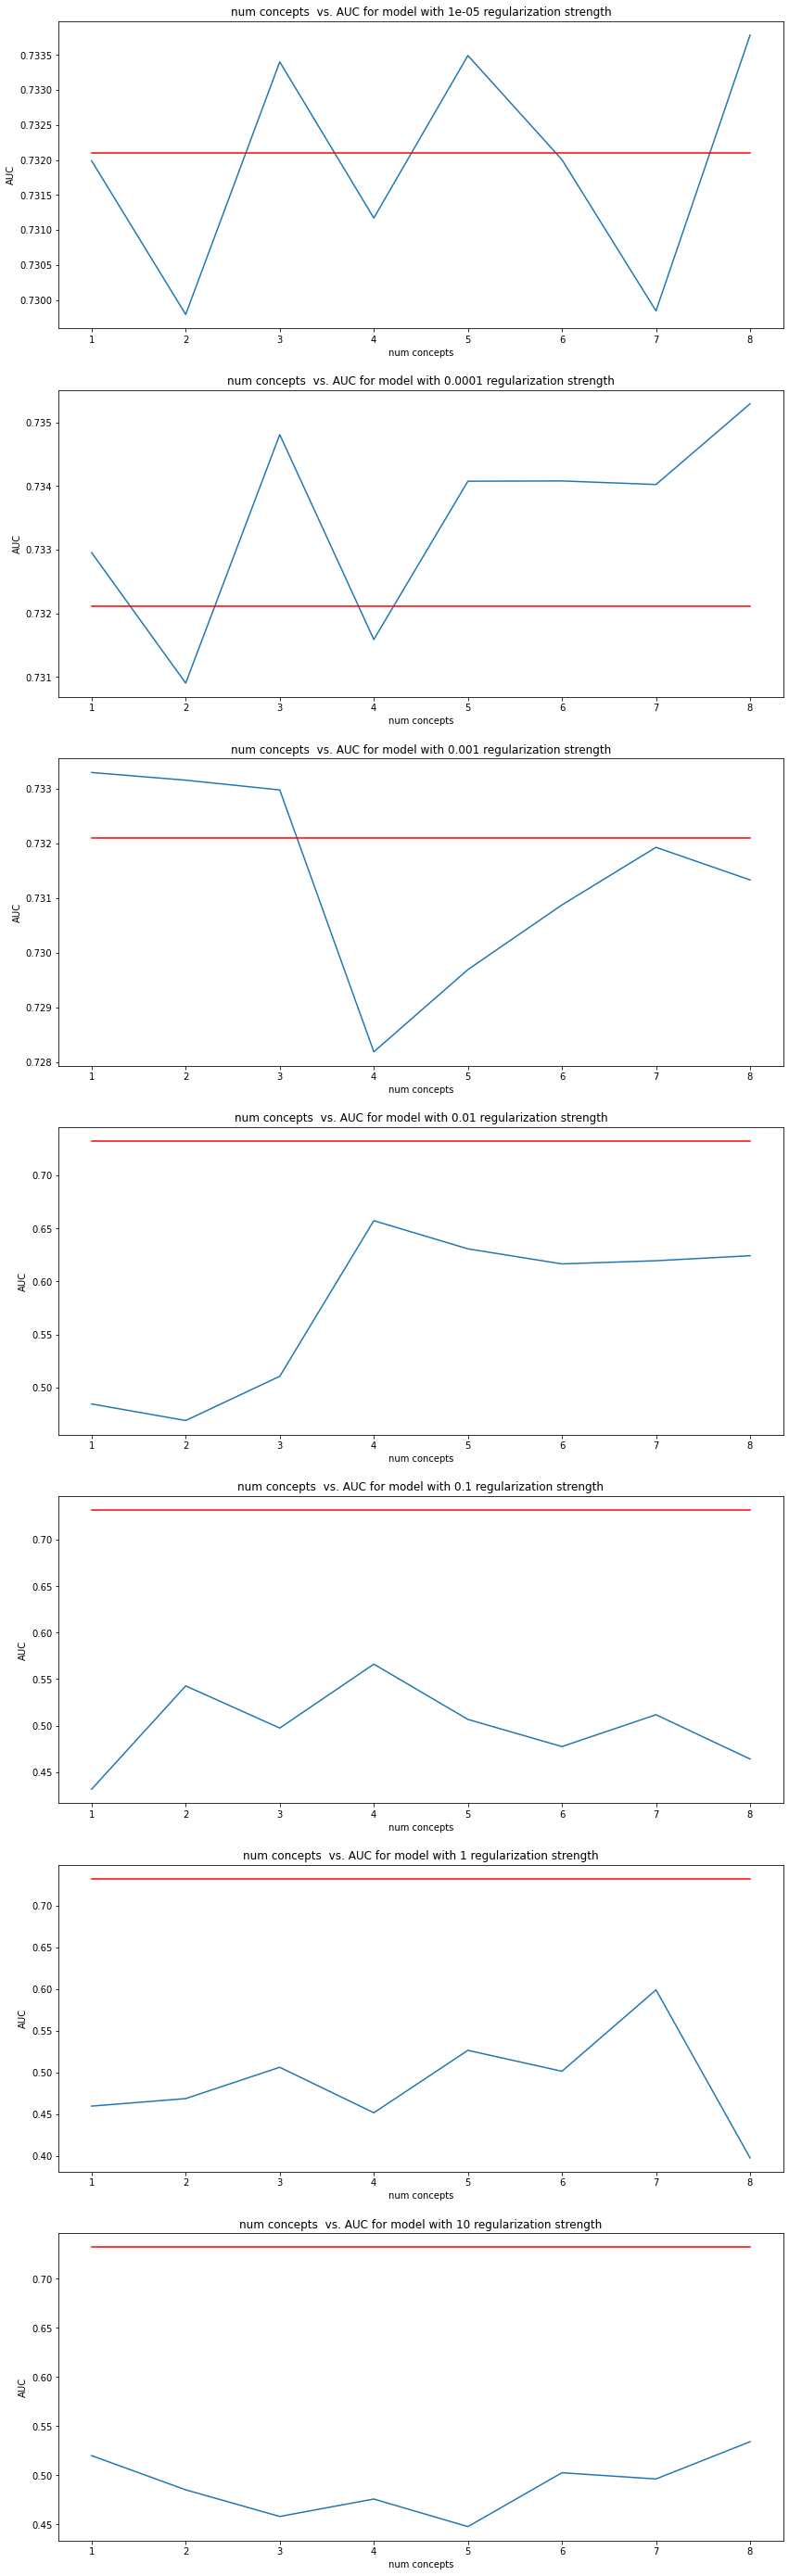

In [244]:
fig, axs = plt.subplots(7, 1,figsize=(14,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for l in range(7):
    axs[l].plot(np.arange(1,9),np.mean(aucs_all,axis=0)[:,l])
    axs[l].plot(np.arange(1,9), np.repeat(baseline_top1_auc[0],8), '-r', label='baseline auc')
# ax1.plot(arr_l1_lambda, np.repeat(baseline_top1_auc[0],6), '-r', label='baseline auc')
    axs[l].set_xlabel("num concepts")
    axs[l].set_ylabel("AUC")
    axs[l].set_title("num concepts  vs. AUC for model with " + str(arr_l1_lambda[l])+" regularization strength")

## Look at concept meanings with L1

In [72]:
concept_weights_tot = []
concept_weights_tot_raw = []

train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
for r in range(1,2):
    concept_weights_aggr = []
    concept_weights_aggr_raw = []
    for c in range(1,9):
        concept_weights=[]
        concept_weights_raw=[]
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
            if row[3]=="0.001":
                bottleneck_rows.append(np.array(row).astype(float))
        for row in bottleneck_rows:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]

            # initialize model
            logregbottleneck = initializeModel(c)

            # load trained models
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1lambda_{}.pt".format(r, row[0],row[1],row[2],row[3]), 
                 epochs=1000, 
                 save_every_n_epochs=10)

            # get weights
            weights, weights_raw = getWeights(logregbottleneck.model)
            concept_weights.append(weights)
            concept_weights_raw.append(weights_raw)

        # aggregate concept weights for each # of concepts
        concept_weights_aggr.append(concept_weights)
        concept_weights_aggr_raw.append(concept_weights_raw)
    
    # aggregate concept weights for each train/test split
    concept_weights_tot.append(concept_weights_aggr)
    concept_weights_tot_raw.append(concept_weights_aggr_raw)

in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1lambda_0.001.pt


0it [00:00, ?it/s]


In [27]:
summary_dict = {0:'mean', 1:'var', 2:'ever measured', 3:'mean of indicators', 4: 'var of indicators', 5:'# switches', 6:'slope', 7:'slope std err', 8:'first time measured', 9:'last time measured', 10:'hours above threshold', 11:'hours below threshold'}
def getConcept(c):
    if c < 66:
        # raw feature
        return data_cols[c]
    else:
        # summary statistic of feature
        c = c-66
        summary = c//28
        feature = c % 28
        return data_cols[feature], summary_dict[summary]

In [74]:
concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)
concept_weights_tot_raw_sorted = []
for i in range(concept_weights_tot_raw_avg.shape[0]):
    concept_weights_tot_raw_sorted.append(np.argsort(-np.abs(concept_weights_tot_raw_avg[i]), axis=1))
for i in range(len(concept_weights_tot_raw_sorted)):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    for j in range(i+1):
#         print(concept_weights_tot_raw_sorted[i][j][:5])
        print(list(map(getConcept,concept_weights_tot_raw_sorted[i][j][:5])))
        for k in range(0,5):
                print(concept_weights_tot_raw_avg[i][j][concept_weights_tot_raw_sorted[i][j][k]])
    print("\n")

Top 5 features associated with 1 concepts:
[('spontaneousrr', 'var of indicators'), ('fio2', 'first time measured'), ('spo2', 'mean of indicators'), ('inr', 'hours above threshold'), ('inr', 'hours below threshold')]
-0.57879597
0.5471497
-0.51935273
0.4094883
0.40621054


Top 5 features associated with 2 concepts:
[('inr', 'ever measured'), ('GCS', 'first time measured'), ('inr', 'mean of indicators'), ('dbp', 'first time measured'), ('spo2', 'first time measured')]
-0.0030081687
-0.0029218136
-0.0028224497
-0.002817286
-0.0026067537
[('spontaneousrr', 'var of indicators'), ('spo2', 'mean of indicators'), ('fio2', 'first time measured'), ('inr', 'hours above threshold'), ('inr', 'hours below threshold')]
0.5611029
0.5258783
-0.52434295
-0.4117172
-0.40934497


Top 5 features associated with 3 concepts:
[('spontaneousrr', 'var of indicators'), ('spo2', 'mean of indicators'), ('fio2', 'first time measured'), ('temp', 'first time measured'), ('inr', 'hours below threshold')]
0.5659155
0.

/tmp/ipykernel_207017/4270394113.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)


Top 5 features associated with 1 concepts:


/tmp/ipykernel_207017/2079392315.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, j].set_xticklabels(concepts, rotation=45)


<Figure size 432x288 with 0 Axes>

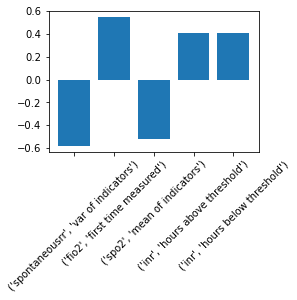

Top 5 features associated with 2 concepts:


<Figure size 432x288 with 0 Axes>

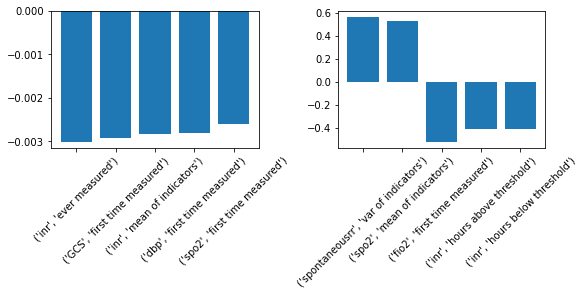

Top 5 features associated with 3 concepts:


<Figure size 432x288 with 0 Axes>

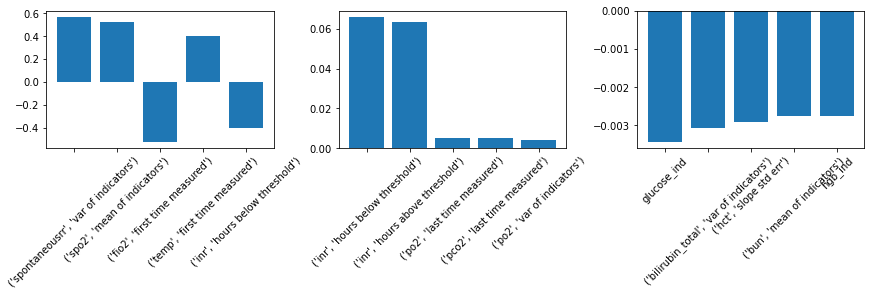

Top 5 features associated with 4 concepts:


<Figure size 432x288 with 0 Axes>

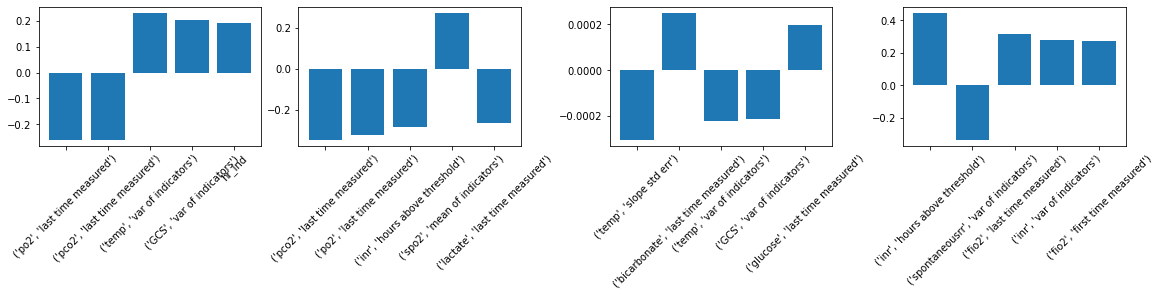

Top 5 features associated with 5 concepts:


/tmp/ipykernel_207017/2079392315.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, j-4].set_xticklabels(concepts, rotation=45)


<Figure size 432x288 with 0 Axes>

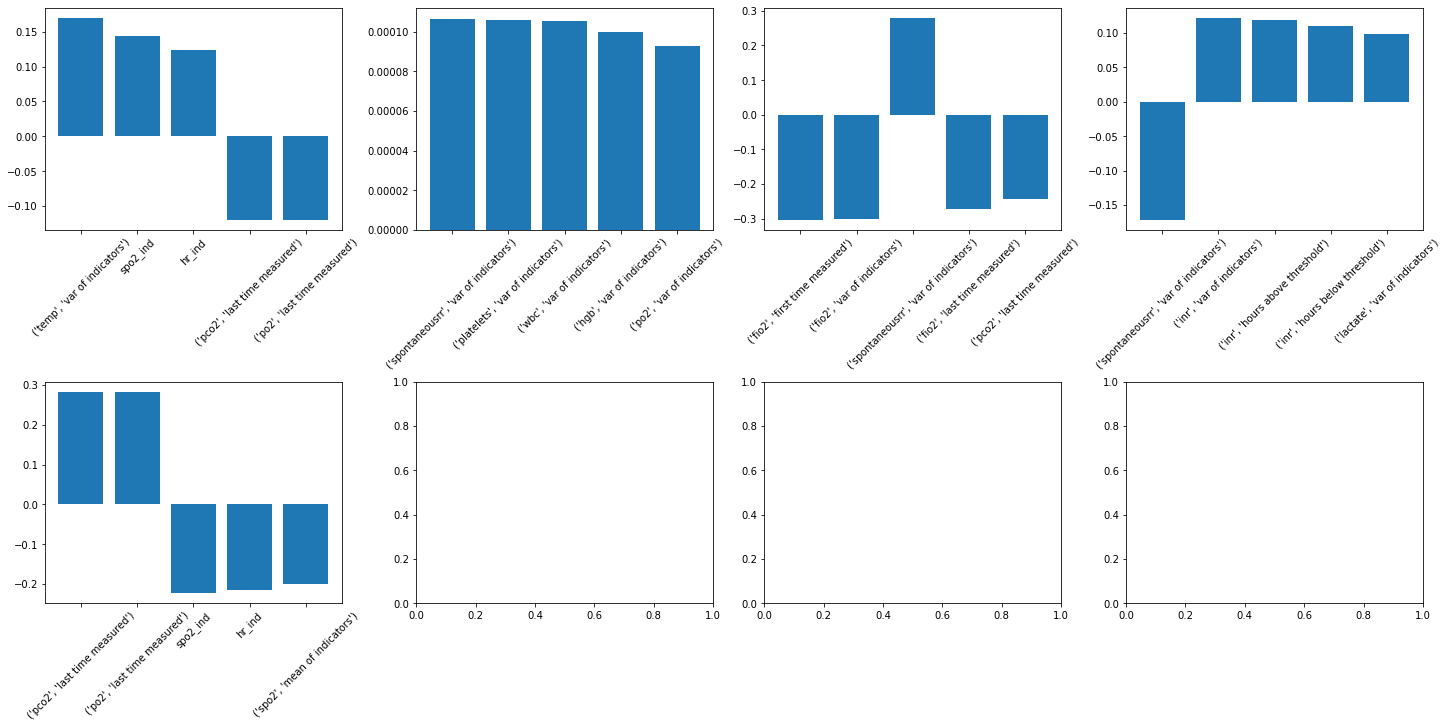

Top 5 features associated with 6 concepts:


<Figure size 432x288 with 0 Axes>

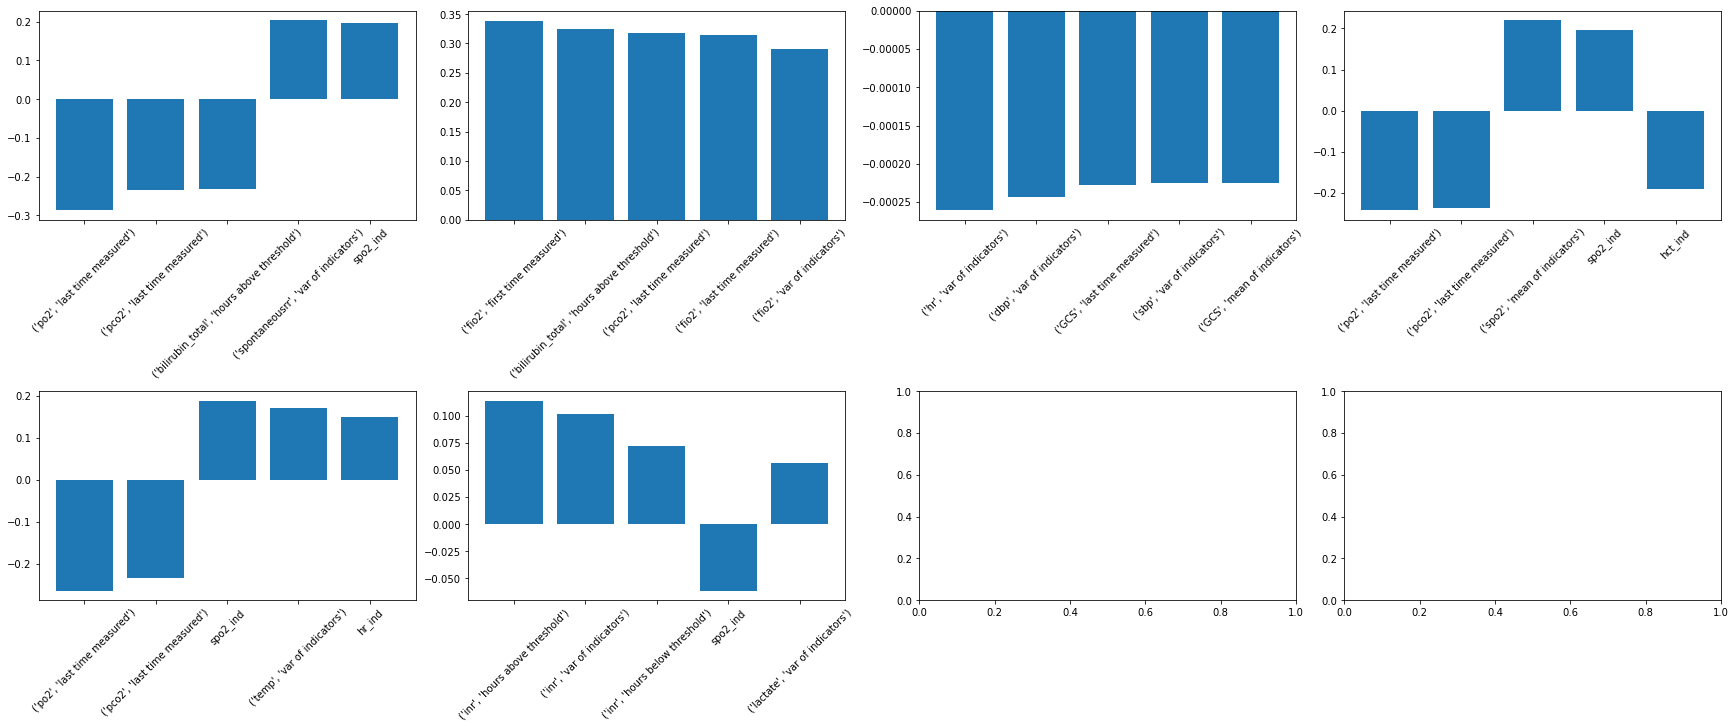

Top 5 features associated with 7 concepts:


<Figure size 432x288 with 0 Axes>

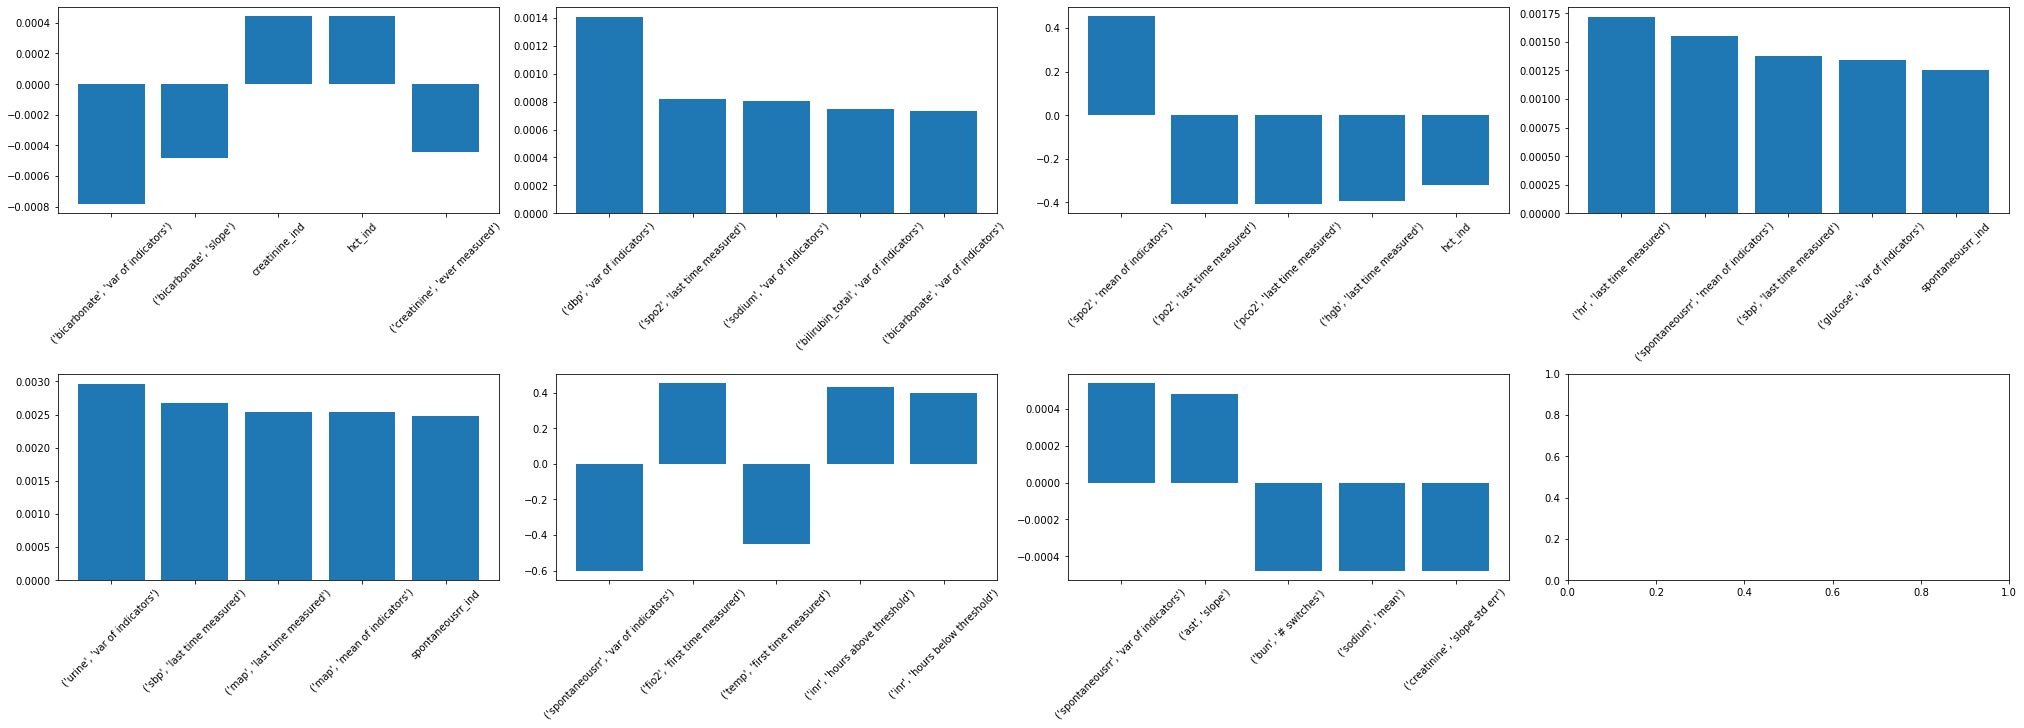

Top 5 features associated with 8 concepts:


<Figure size 432x288 with 0 Axes>

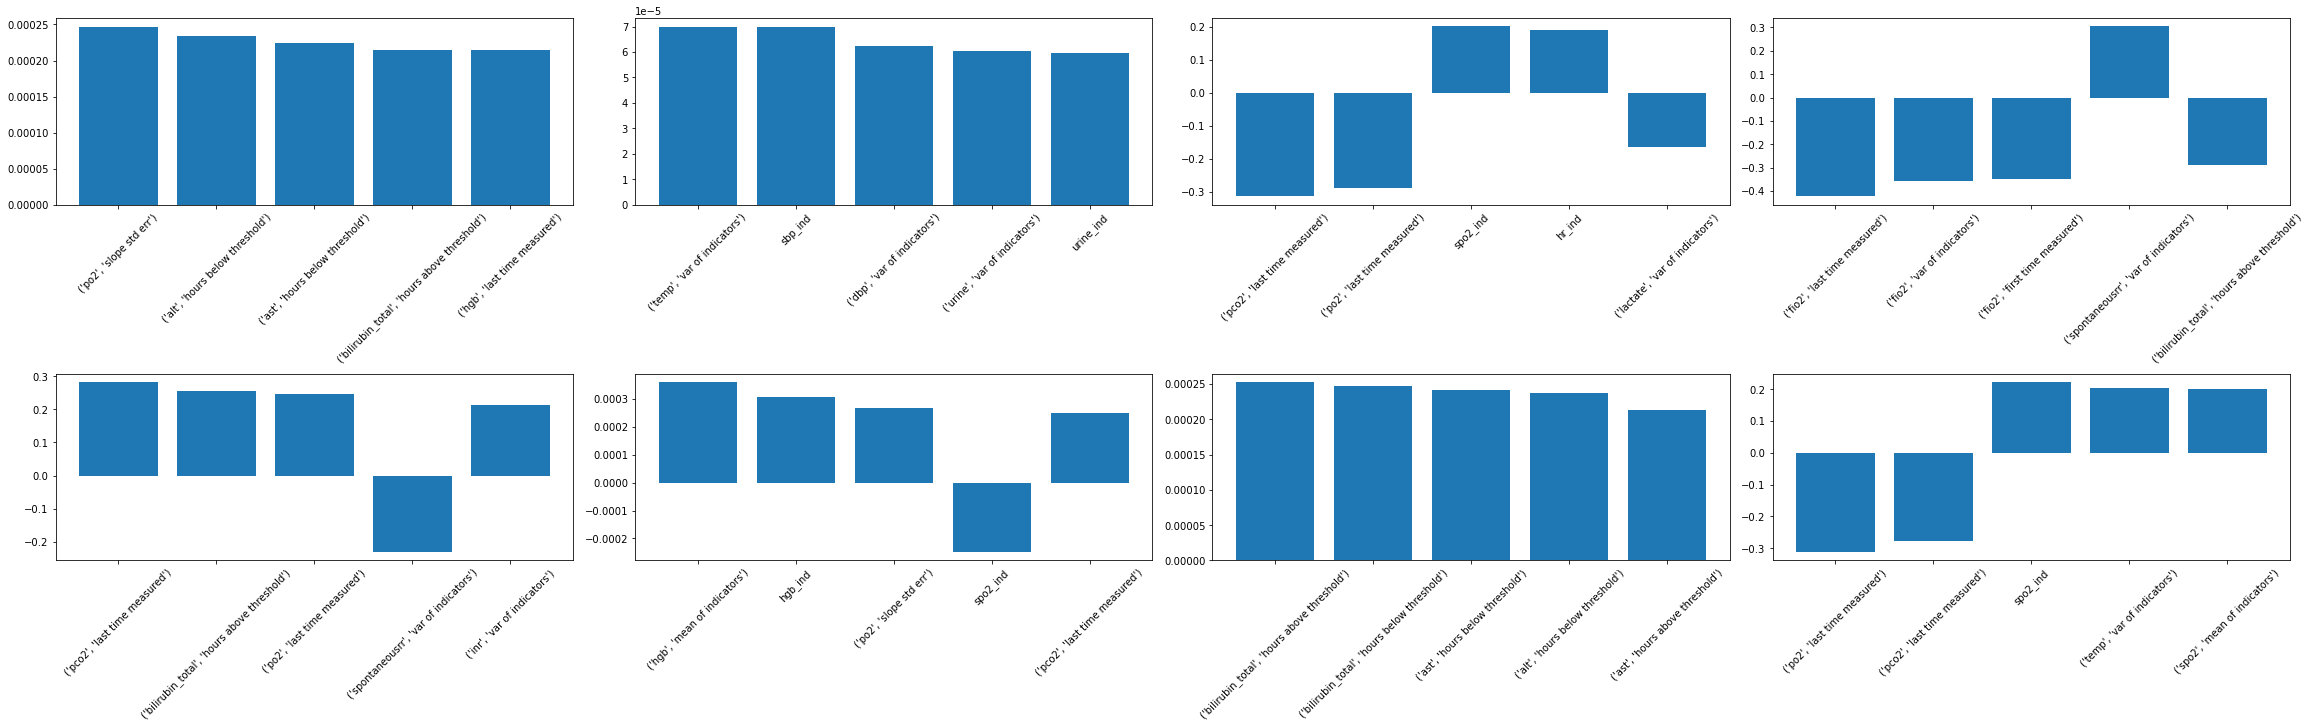

In [75]:
import matplotlib.pyplot as plt
    

for i in range(8):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    plt.clf()
    if (i < 4):
        fig, axs = plt.subplots(1, i+1,squeeze=False,figsize=(4*(i+1),4),constrained_layout=True)
    else:
        fig, axs = plt.subplots(2, 4,figsize=(4*(i+1),10),constrained_layout=True)
    for j in range(i+1):
        concepts = list(map(str,map(getConcept,concept_weights_tot_raw_sorted[i][j][:5])))
        weights = concept_weights_tot_raw_avg[i][j][concept_weights_tot_raw_sorted[i][j][:5]]
        if (j<4):
            axs[0, j].bar(concepts, weights)
            axs[0, j].set_xticklabels(concepts, rotation=45)
        else:
            axs[1, j-4].bar(concepts, weights)
            axs[1, j-4].set_xticklabels(concepts, rotation=45)
    plt.show()

## Add L1 regularization to model (incorrect)

In [15]:
concept_weights_tot = []
concept_weights_tot_raw = []

train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
for r in range(1,2):
    concept_weights_aggr = []
    concept_weights_aggr_raw = []
    for c in range(1,11):
        concept_weights=[]
        concept_weights_raw=[]
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(row)
        for row in bottleneck_top5_all[r-1][c-1]:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]

            # initialize model
            logregbottleneck = initializeModel(c)

            # load trained models
#             if r==1:
#                 logregbottleneck.fit(train_loader, val_loader, p_weight, 
#                      save_model_path = "./models/LOS-6-600/bottleneck_c{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(row[0],row[1],row[2],row[3],row[4]), 
#                      epochs=1000, 
#                      save_every_n_epochs=10)
#             else:
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r{}_c{}_alpha_{}_tau_{}_optlr_{}_optwd_{}_l1lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4],row[5]), 
                 epochs=1000, 
                 save_every_n_epochs=10)

            # get weights
            weights, weights_raw = getWeights(logregbottleneck.model)
            concept_weights.append(weights)
            concept_weights_raw.append(weights_raw)

        # aggregate concept weights for each # of concepts
        concept_weights_aggr.append(concept_weights)
        concept_weights_aggr_raw.append(concept_weights_raw)
    
    # aggregate concept weights for each train/test split
    concept_weights_tot.append(concept_weights_aggr)
    concept_weights_tot_raw.append(concept_weights_aggr_raw)

in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_alpha_0.01_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_alpha_0.0001_tau_0.1_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_alpha_0.1_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_alpha_0.0001_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_alpha_0.1_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_alpha_0.0001_tau_0.1_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_alpha_0.0001_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_alpha_0.1_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_alpha_1e-05_tau_0.1_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_alpha_0.1_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_alpha_0.01_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_alpha_1e-06_tau_100_optlr_0.0001_optwd_0.001_l1lambda_1e-05.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_alpha_1e-05_tau_0.1_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_alpha_0.1_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_alpha_0.1_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_alpha_0.0001_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_alpha_0.01_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_alpha_0.1_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_alpha_0.0001_tau_100_optlr_0.0001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_alpha_0_tau_10_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_alpha_0.01_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_alpha_0.1_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_alpha_1e-05_tau_0.1_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_alpha_0.0001_tau_0.1_optlr_0.001_optwd_0.001_l1lambda_0.01.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_alpha_0.1_tau_10_optlr_0.0001_optwd_0_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_alpha_0.0001_tau_100_optlr_0.0001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_alpha_0.0001_tau_20_optlr_0.001_optwd_0.001_l1lambda_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_alpha_0.01_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c9_alpha_0.1_tau_20_optlr_0.0001_optwd_0_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c9_alpha_0.1_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c9_alpha_0_tau_10_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c9_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c9_alpha_0.0001_tau_100_optlr_0.0001_optwd_0.001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c10_alpha_1e-06_tau_0.1_optlr_0.0001_optwd_1e-05_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c10_alpha_1e-05_tau_0.1_optlr_0.0001_optwd_0_l1lambda_0.01.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c10_alpha_0_tau_10_optlr_0.0001_optwd_0.0001_l1lambda_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c10_alpha_0.1_tau_40_optlr_0.01_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c10_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001_l1lambda_0.1.pt


0it [00:00, ?it/s]


In [10]:
# BASELINE: get top 5 models from hyperparameter scan
baseline_top5 = []
baseline_top5_aucs = []

for r in range(1,2):
    file = open('./models/old-models/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
        baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top5.append(sorted_baseline_rows[-5:])
    baseline_top5_aucs.append(sorted_baseline_rows[-5:][:,4])

In [9]:
# BOTTLENECK: get top 5 models from hyperparameter scan

bottleneck_top5_all = []
bottleneck_top5_aucs_all = []
for r in range(1,2):
    bottleneck_top5 = []
    bottleneck_top5_aucs = []
    for c in range(1,11):
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,6])]
        bottleneck_top5.append(sorted_bottleneck_rows[-5:])
        bottleneck_top5_aucs.append(sorted_bottleneck_rows[-5:][:,6])
    bottleneck_top5_all.append(bottleneck_top5)
    bottleneck_top5_aucs_all.append(bottleneck_top5_aucs)

NameError: name 'bottleneck_top5_aucs_all' is not defined

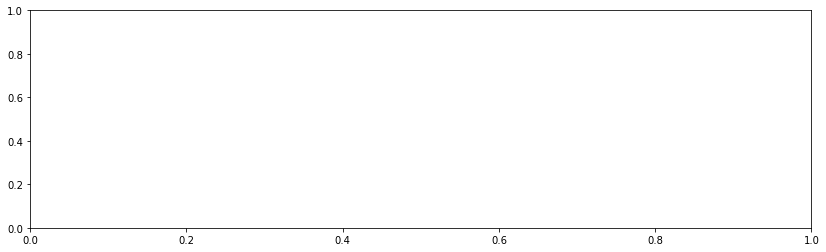

In [12]:
fig, (ax1) = plt.subplots(1, 1,figsize=(14,4))
# fig.suptitle('Across 3 train/test splits')

ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,:,4])
ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[0][4],10), '-r', label='baseline auc')
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 1 model")

# ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,:,4])
# ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[1][4],10), '-r', label='baseline auc')
# ax2.set_xlabel("# of concepts")
# ax2.set_ylabel("AUC")
# ax2.set_title("# of Concepts vs. AUC for top 1 model")

# ax3.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[2,:,4])
# ax3.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[2][4],10), '-r', label='baseline auc')
# ax3.set_xlabel("# of concepts")
# ax3.set_ylabel("AUC")
# ax3.set_title("# of Concepts vs. AUC for top 1 model")

In [14]:
# BOTTLENECK: get models from hyperparameter scan

bottleneck_top1_all = []
bottleneck_top1_aucs_all = []
for r in range(1,2):
    bottleneck_top1 = []
    bottleneck_top1_aucs = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/no-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(-bottleneck_rows[:,3])]
        bottleneck_top1.append(sorted_bottleneck_rows[0])
        bottleneck_top1_aucs.append(sorted_bottleneck_rows[0][3])
    bottleneck_top1_all.append(bottleneck_top1)
    bottleneck_top1_aucs_all.append(bottleneck_top1_aucs)

In [17]:
bottleneck_top1_aucs_all

[[0.7331439802746276,
  0.7342554004018131,
  0.7331502067179173,
  0.7344338917761137,
  0.7328617148455012,
  0.7364284291098676,
  0.7316050110415595,
  0.7315479353114053]]

Text(0.5, 1.0, '# of Concepts vs. AUC for top 1 model')

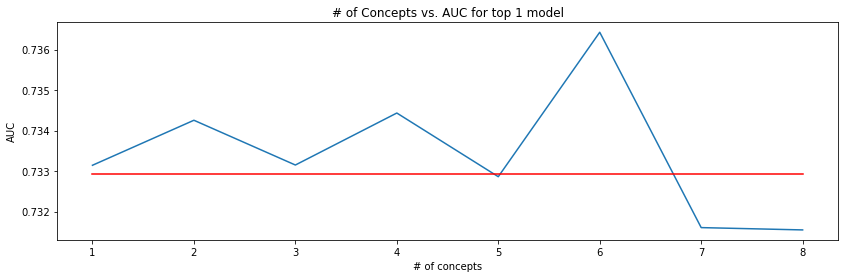

In [17]:
fig, (ax1) = plt.subplots(1, 1,figsize=(14,4))
# fig.suptitle('Across 3 train/test splits')

ax1.plot(np.arange(1,9),np.array(bottleneck_top1_aucs_all)[0])
ax1.plot(np.arange(1,9), np.repeat(baseline_top5_aucs[0][4],8), '-r', label='baseline auc')
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 1 model")

### Test L1 Regularization

In [67]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
logregbottleneck = initializeModel(2)

logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/bottleneck_r1_c2_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.0001.pt", 
                     epochs=1000, 
                     save_every_n_epochs=10)

in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r1_c2_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


In [70]:
print(getAUC(logregbottleneck.model,X_test,y_test))
L1_reg = torch.tensor(0.)
for name, param in logregbottleneck.named_parameters():
    print(name)
    print(param)
#     if "bottleneck.weight" in name:
#         bottleneck_weights = param
#         L1_reg = L1_reg + torch.norm(param, 1)
print(torch.sum(sum(bottleneck_weights>1e-10)))
L1_reg

0.755443926260725
model.cutoff_times
Parameter containing:
tensor([[     0.0000,     -0.0000,     -0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,     -0.0000,     -0.0000,
             -0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,
             -0.0000,     -0.0000,      0.0000,     -0.0000,     -0.0000,
             -0.0000,      0.0000,     -0.0000,     -0.0000,      0.0000,
              0.0000,     -0.0000,     -0.0000,      0.0000,     -0.0000,
              0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,     -0.0118,      0.1149,      0.0900,     -0.0057,
             -0.0072,     -0.0043,     -0.0050,     -

tensor(0.)

In [69]:
logregbottleneck.named_parameters()

<generator object Module.named_parameters at 0x2b24205b4b30>

In [12]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
logregbottleneck = initializeModel(1)

vals_to_init = init_cutoffs_randomly(changing_dim * 9)
logregbottleneck_reg = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                            changing_dim,
                                                                            9,                     
                                                                            1,
                                                                            True,
                                                                            init_cutoffs_randomly, 
                                                                            init_rand_lower_thresholds, 
                                                                            init_rand_upper_thresholds,
                                                                            cutoff_times_temperature=0.1,
                                                                            cutoff_times_init_values=vals_to_init,
                                                                            alpha = 0.0001,
                                                                            tau = 0.1,
                                                                            opt_lr = 0.0001,
                                                                            opt_weight_decay = 0.0001,
                                                                           l1_lambda=0.001)
logregbottleneck_reg.cuda()

logregbottleneck_reg.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/bottleneck_reg1_r1_c1_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.0001.pt", 
                     epochs=1000, 
                     save_every_n_epochs=10)

  0%|                                                                                           | 0/1000 [00:00<?, ?it/s]

in init bottleneck test
self.num_concepts
1
in init bottleneck test
self.num_concepts
1
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
la

  0%|                                                                                   | 1/1000 [00:00<14:36,  1.14it/s]

lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001

  0%|▏                                                                                  | 2/1000 [00:01<14:36,  1.14it/s]

lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001

  0%|▏                                                                                  | 3/1000 [00:02<14:33,  1.14it/s]

lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda

  0%|▏                                                                                  | 3/1000 [00:02<15:56,  1.04it/s]


0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001
lambda
0.001


KeyboardInterrupt: 

In [11]:
print(getAUC(logregbottleneck_reg.model,X_test,y_test))
L1_reg = torch.tensor(0.)
for name, param in logregbottleneck_reg.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
        L1_reg = L1_reg + torch.norm(param, 1)
print(torch.sum(sum(bottleneck_weights>1e-10)))
print(L1_reg)

0.7278176739278992
tensor(180, device='cuda:0')
tensor(35.0661, grad_fn=<AddBackward0>)


# 1-10 Concepts Gridsearch

In [59]:
# BASELINE: get top 5 models from hyperparameter scan
baseline_top5 = []
baseline_top5_aucs = []

for r in range(1,4):
    file = open('./models/LOS-6-600/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
        baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top5.append(sorted_baseline_rows[-5:])
    baseline_top5_aucs.append(sorted_baseline_rows[-5:][:,4])

In [9]:
baseline_rows.shape

(10, 5)

In [60]:
# BOTTLENECK: get top 5 models from hyperparameter scan

bottleneck_top5_all = []
bottleneck_top5_aucs_all = []
for r in range(1,4):
    bottleneck_top5 = []
    bottleneck_top5_aucs = []
    for c in range(1,11):
        file = open('./models/LOS-6-600/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,5])]
        bottleneck_top5.append(sorted_bottleneck_rows[-5:])
        bottleneck_top5_aucs.append(sorted_bottleneck_rows[-5:][:,5])
    bottleneck_top5_all.append(bottleneck_top5)
    bottleneck_top5_aucs_all.append(bottleneck_top5_aucs)

In [11]:
bottleneck_top5_aucs_all

[[array([0.72846585, 0.7300017 , 0.73248398, 0.732897  , 0.73293851]),
  array([0.73083189, 0.73098133, 0.73176067, 0.73260436, 0.73343766]),
  array([0.73107888, 0.73174303, 0.7324186 , 0.73265832, 0.73342728]),
  array([0.73028708, 0.73177416, 0.73251615, 0.73278181, 0.7352371 ]),
  array([0.73161746, 0.73182813, 0.73184784, 0.73298106, 0.73314917]),
  array([0.73181048, 0.73214256, 0.7323086 , 0.7325919 , 0.73318653]),
  array([0.7311619 , 0.73152407, 0.73162784, 0.73193086, 0.73252341]),
  array([0.73186756, 0.73236983, 0.73294785, 0.73313049, 0.73347087]),
  array([0.73202115, 0.73232417, 0.73242586, 0.73286275, 0.7328669 ]),
  array([0.73180737, 0.73197548, 0.73217058, 0.73222973, 0.73250681])],
 [array([0.71692721, 0.71930779, 0.71974571, 0.72076477, 0.72499875]),
  array([0.71833646, 0.71854816, 0.71937835, 0.71947797, 0.71981005]),
  array([0.72089968, 0.72109166, 0.72167176, 0.72452762, 0.72477253]),
  array([0.72217195, 0.72343177, 0.72422252, 0.72537857, 0.72564008]),
  arr

Text(0.5, 1.0, '# of Concepts vs. AUC for top 1 model')

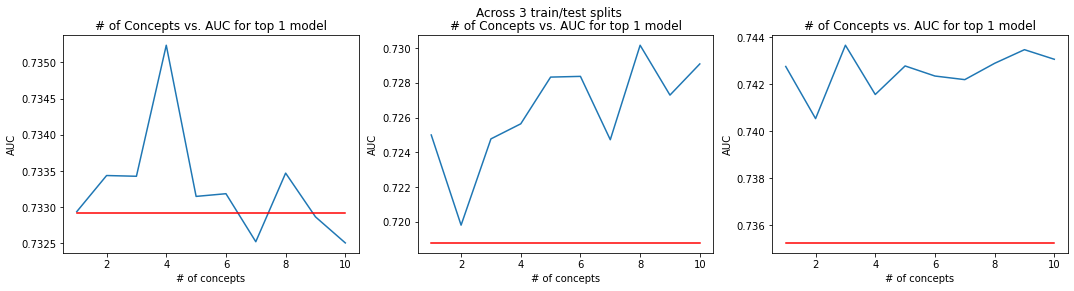

In [61]:
# Top 1 model AUC (individual test splits)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(18,4))
fig.suptitle('Across 3 train/test splits')

ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,:,4])
ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[0][4],10), '-r', label='baseline auc')
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 1 model")

ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,:,4])
ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[1][4],10), '-r', label='baseline auc')
ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 1 model")

ax3.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[2,:,4])
ax3.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[2][4],10), '-r', label='baseline auc')
ax3.set_xlabel("# of concepts")
ax3.set_ylabel("AUC")
ax3.set_title("# of Concepts vs. AUC for top 1 model")

# ax4.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[3,:,4])
# ax4.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[3][4],10), '-r', label='baseline auc')
# ax4.set_xlabel("# of concepts")
# ax4.set_ylabel("AUC")
# ax4.set_title("# of Concepts vs. AUC for top 1 model")


Text(0.5, 1.0, '# of Concepts vs. AUC for top 1 model')

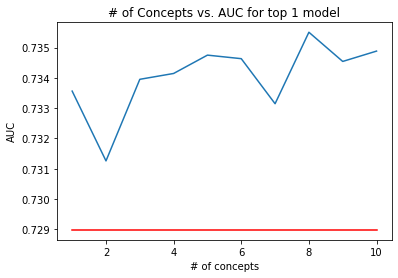

In [62]:
# Top 1 model AUC averaged across train/test splits

plt.plot(np.arange(1,11),np.mean(np.array(bottleneck_top5_aucs_all),axis=0)[:,4])
plt.plot(np.arange(1,11), np.repeat(np.mean(baseline_top5_aucs,axis=0)[4],10), '-r', label='baseline auc')
plt.xlabel("# of concepts")
plt.ylabel("AUC")
plt.title("# of Concepts vs. AUC for top 1 model")

Text(0.5, 1.0, '# of Concepts vs. AUC for top 5 models')

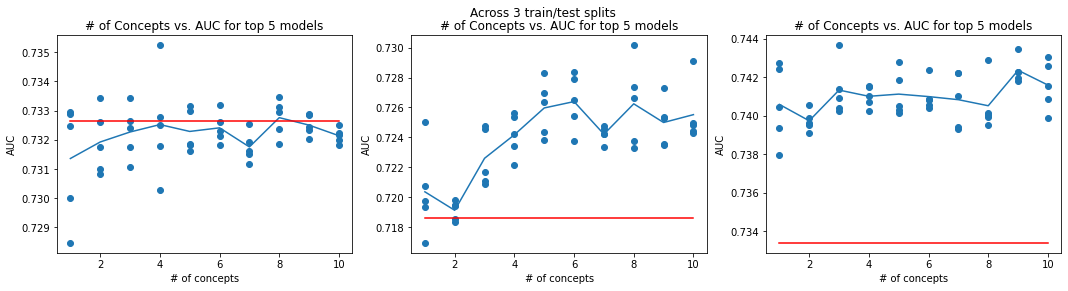

In [63]:
# Top 5 models AUCs

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(18,4))
fig.suptitle('Across 3 train/test splits')

bottleneck_top5_aucs_avg=np.mean(np.array(bottleneck_top5_aucs_all),axis=2)
baseline_top5_aucs_avg=np.mean(np.array(baseline_top5_aucs),axis=1)
ax1.plot(np.arange(1,11),bottleneck_top5_aucs_avg[0])
ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[0],10), '-r', label='baseline auc')
ax1.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[0])
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 5 models")

ax2.plot(np.arange(1,11),bottleneck_top5_aucs_avg[1])
ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[1],10), '-r', label='baseline auc')
ax2.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[1])
ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 5 models")

ax3.plot(np.arange(1,11),bottleneck_top5_aucs_avg[2])
ax3.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[2],10), '-r', label='baseline auc')
ax3.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[2])
ax3.set_xlabel("# of concepts")
ax3.set_ylabel("AUC")
ax3.set_title("# of Concepts vs. AUC for top 5 models")

# ax4.plot(np.arange(1,11),bottleneck_top5_aucs_avg[3])
# ax4.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[3],10), '-r', label='baseline auc')
# ax4.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[3])
# ax4.set_xlabel("# of concepts")
# ax4.set_ylabel("AUC")
# ax4.set_title("# of Concepts vs. AUC for top 5 models")

## Assign Concept Meanings

In [64]:
summary_dict = {0:'mean', 1:'var', 2:'ever measured', 3:'mean of indicators', 4: 'var of indicators', 5:'# switches', 6:'slope', 7:'slope std err', 8:'first time measured', 9:'last time measured', 10:'hours above threshold', 11:'hours below threshold'}
def getConcept(c):
    if c < 66:
        # raw feature
        return data_cols[c]
    else:
        # summary statistic of feature
        c = c-66
        summary = c//28
        feature = c % 28
        return data_cols[feature], summary_dict[summary]

In [65]:
concept_weights_tot = []
concept_weights_tot_raw = []

train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
for r in range(1,4):
    concept_weights_aggr = []
    concept_weights_aggr_raw = []
    for c in range(1,11):
        concept_weights=[]
        concept_weights_raw=[]
        file = open('./models/LOS-6-600/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(row)
        for row in bottleneck_top5_all[r-1][c-1]:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]

            # initialize model
            logregbottleneck = initializeModel(c)

            # load trained models
#             if r==1:
#                 logregbottleneck.fit(train_loader, val_loader, p_weight, 
#                      save_model_path = "./models/LOS-6-600/bottleneck_c{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(row[0],row[1],row[2],row[3],row[4]), 
#                      epochs=1000, 
#                      save_every_n_epochs=10)
#             else:
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/bottleneck_r{}_c{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                 epochs=1000, 
                 save_every_n_epochs=10)

            # get weights
            weights, weights_raw = getWeights(logregbottleneck.model)
            concept_weights.append(weights)
            concept_weights_raw.append(weights_raw)

        # aggregate concept weights for each # of concepts
        concept_weights_aggr.append(concept_weights)
        concept_weights_aggr_raw.append(concept_weights_raw)
    
    # aggregate concept weights for each train/test split
    concept_weights_tot.append(concept_weights_aggr)
    concept_weights_tot_raw.append(concept_weights_aggr_raw)

in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r1_c1_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r1_c1_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r1_c1_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r1_c1_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r1_c1_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r1_c2_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r1_c2_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r1_c2_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r1_c2_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r1_c2_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r1_c3_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r1_c3_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r1_c3_alpha_0.01_tau_1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r1_c3_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r1_c3_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r1_c4_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r1_c4_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r1_c4_alpha_0.1_tau_0.1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r1_c4_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r1_c4_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r1_c5_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r1_c5_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r1_c5_alpha_0.01_tau_1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r1_c5_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r1_c5_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r1_c6_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r1_c6_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r1_c6_alpha_0.01_tau_1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r1_c6_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r1_c6_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r1_c7_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r1_c7_alpha_0.01_tau_1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r1_c7_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r1_c7_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r1_c7_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r1_c8_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r1_c8_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r1_c8_alpha_0.01_tau_1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r1_c8_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r1_c8_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r1_c9_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r1_c9_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r1_c9_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r1_c9_alpha_0.1_tau_0.1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r1_c9_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r1_c10_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r1_c10_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r1_c10_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r1_c10_alpha_0.1_tau_0.1_optlr_0.0001_optwd_0.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r1_c10_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r2_c1_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r2_c1_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r2_c1_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r2_c1_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r2_c1_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r2_c2_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r2_c2_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r2_c2_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r2_c2_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r2_c2_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r2_c3_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r2_c3_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r2_c3_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r2_c3_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r2_c3_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r2_c4_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r2_c4_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r2_c4_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r2_c4_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r2_c4_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r2_c5_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r2_c5_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r2_c5_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r2_c5_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r2_c5_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r2_c6_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r2_c6_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r2_c6_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r2_c6_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r2_c6_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r2_c7_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r2_c7_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r2_c7_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r2_c7_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r2_c7_alpha_0_tau_0.1_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r2_c8_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r2_c8_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r2_c8_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r2_c8_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r2_c8_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r2_c9_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r2_c9_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r2_c9_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r2_c9_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r2_c9_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r2_c10_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r2_c10_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r2_c10_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r2_c10_alpha_0.01_tau_10_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r2_c10_alpha_0.0001_tau_100_optlr_0.001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r3_c1_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r3_c1_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r3_c1_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r3_c1_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
1
Loaded model from ./models/LOS-6-600/bottleneck_r3_c1_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r3_c2_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r3_c2_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r3_c2_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r3_c2_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
2
Loaded model from ./models/LOS-6-600/bottleneck_r3_c2_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r3_c3_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r3_c3_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r3_c3_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r3_c3_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
3
Loaded model from ./models/LOS-6-600/bottleneck_r3_c3_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r3_c4_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r3_c4_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r3_c4_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r3_c4_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
4
Loaded model from ./models/LOS-6-600/bottleneck_r3_c4_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r3_c5_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r3_c5_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r3_c5_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r3_c5_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
5
Loaded model from ./models/LOS-6-600/bottleneck_r3_c5_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r3_c6_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r3_c6_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r3_c6_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r3_c6_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
6
Loaded model from ./models/LOS-6-600/bottleneck_r3_c6_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r3_c7_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r3_c7_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r3_c7_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r3_c7_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
7
Loaded model from ./models/LOS-6-600/bottleneck_r3_c7_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r3_c8_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r3_c8_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r3_c8_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r3_c8_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
8
Loaded model from ./models/LOS-6-600/bottleneck_r3_c8_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r3_c9_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r3_c9_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r3_c9_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r3_c9_alpha_0.001_tau_40_optlr_0.01_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
9
Loaded model from ./models/LOS-6-600/bottleneck_r3_c9_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r3_c10_alpha_0.001_tau_1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r3_c10_alpha_0.01_tau_10_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r3_c10_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r3_c10_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init bottleneck test
self.num_concepts
10
Loaded model from ./models/LOS-6-600/bottleneck_r3_c10_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


In [66]:
concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)
concept_weights_tot_raw_sorted = []
for i in range(concept_weights_tot_raw_avg.shape[0]):
    concept_weights_tot_raw_sorted.append(np.argsort(-concept_weights_tot_raw_avg[i], axis=1))
for i in range(len(concept_weights_tot_raw_sorted)):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    for j in range(i+1):
#         print(concept_weights_tot_raw_sorted[i][j][:5])
        print(list(map(getConcept,concept_weights_tot_raw_sorted[i][j][:5])))
        for k in range(1,6):
            print(concept_weights_tot_raw_avg[i][j][concept_weights_tot_raw_sorted[i][j][402-k]])
    print("\n")

Top 5 features associated with 1 concepts:
[('po2', 'first time measured'), ('pco2', 'first time measured'), ('inr', 'hours below threshold'), ('inr', 'hours above threshold'), 'inr_ind']
-0.032959558
-0.032620344
-0.031222314
-0.0306167
-0.028903753


Top 5 features associated with 2 concepts:
[('fio2', 'last time measured'), ('bilirubin_total', 'slope std err'), ('fio2', 'var of indicators'), ('glucose', 'var of indicators'), ('GCS', 'var of indicators')]
-0.16622041
-0.13405484
-0.13396652
-0.106778145
-0.1039087
[('fio2', 'var of indicators'), ('GCS', 'var of indicators'), ('temp', 'slope std err'), ('inr', 'var of indicators'), ('lactate', 'hours below threshold')]
-0.21804717
-0.19481675
-0.17572497
-0.14039469
-0.13988951


Top 5 features associated with 3 concepts:
['GCS_ind', ('hr', 'var of indicators'), ('bilirubin_total', 'slope std err'), ('inr', 'var of indicators'), ('lactate', 'hours below threshold')]
-0.11503031
-0.10494421
-0.097945526
-0.08141223
-0.0800585
[('glucos

/tmp/ipykernel_89196/3830921803.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)


In [81]:
concept_weights_tot_raw_avg_1 =np.mean(np.array(concept_weights_tot_raw[0]),axis=1)
concept_weights_tot_raw_sorted_1 = []
for i in range(concept_weights_tot_raw_avg_1.shape[0]):
    concept_weights_tot_raw_sorted_1.append(np.argsort(-concept_weights_tot_raw_avg_1[i], axis=1))
for i in range(len(concept_weights_tot_raw_sorted_1)):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    for j in range(i+1):
#         print(concept_weights_tot_raw_sorted[i][j][:5])
        print(list(map(getConcept,concept_weights_tot_raw_sorted_1[i][j][:5])))
    print("\n")

Top 5 features associated with 1 concepts:
[('fio2', 'first time measured'), ('inr', 'hours below threshold'), ('magnesium', 'slope std err'), ('bilirubin_total', 'first time measured'), ('inr', 'hours above threshold')]


Top 5 features associated with 2 concepts:
[('bilirubin_total', 'slope std err'), ('fio2', 'last time measured'), ('glucose', 'var of indicators'), ('inr', 'hours above threshold'), ('inr', 'hours below threshold')]
[('GCS', 'var of indicators'), ('spo2', 'mean of indicators'), ('temp', 'slope std err'), ('GCS', 'mean of indicators'), ('spontaneousrr', 'var of indicators')]


Top 5 features associated with 3 concepts:
[('fio2', 'var of indicators'), ('inr', 'var of indicators'), ('fio2', 'hours below threshold'), ('fio2', 'hours above threshold'), ('po2', 'first time measured')]
[('inr', 'hours below threshold'), ('glucose', 'var of indicators'), 'urine_ind', ('magnesium', 'hours above threshold'), ('inr', 'hours above threshold')]
[('GCS', 'var of indicators'), ('ur

/tmp/ipykernel_231503/901536980.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concept_weights_tot_raw_avg_1 =np.mean(np.array(concept_weights_tot_raw[0]),axis=1)


In [80]:
len(concept_weights_tot_raw_avg_1)

1

# LOS 24-72 Hours

# 1-10 Concepts Gridsearch

In [14]:
# BASELINE: get top 5 models from hyperparameter scan
baseline_top5 = []
baseline_top5_aucs = []

for r in range(1,4):
    file = open('../../interpretable-timeseries/mortality/old-models/vasopressor_gridsearch/vasopressor_baseline_gridsearch_r_{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
            baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top5.append(sorted_baseline_rows[-5:])
    baseline_top5_aucs.append(sorted_baseline_rows[-5:][:,4])

In [16]:
baseline_top5_aucs

[array([0.58011628, 0.58085271, 0.58674419, 0.58775194, 0.59418605]),
 array([0.69119769, 0.69124923, 0.6955267 , 0.69789734, 0.69903113]),
 array([0.78252788, 0.78565394, 0.78565394, 0.81319703, 0.81708347])]

In [12]:
# BOTTLENECK: get top 5 models from hyperparameter scan

bottleneck_top5_all = []
bottleneck_top5_aucs_all = []
for r in range(1,4):
    bottleneck_top5 = []
    bottleneck_top5_aucs = []
    for c in range(1,11):
        file = open('../../interpretable-timeseries/mortality/old-models/vasopressor_gridsearch/vasopressor_bottleneck_r_{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,5])]
        bottleneck_top5.append(sorted_bottleneck_rows[-5:])
        bottleneck_top5_aucs.append(sorted_bottleneck_rows[-5:][:,5])
    bottleneck_top5_all.append(bottleneck_top5)
    bottleneck_top5_aucs_all.append(bottleneck_top5_aucs)

In [17]:
bottleneck_top5_aucs_all

[[array([0.58062016, 0.59      , 0.59472868, 0.59875969, 0.60170543]),
  array([0.59837209, 0.60093023, 0.60449612, 0.60496124, 0.60825581]),
  array([0.58085271, 0.59189922, 0.60007752, 0.6020155 , 0.60302326]),
  array([0.62031008, 0.62062016, 0.62271318, 0.62922481, 0.65631783]),
  array([0.60465116, 0.60604651, 0.60953488, 0.64403101, 0.65403101]),
  array([0.59945736, 0.60511628, 0.61658915, 0.63689922, 0.66744186]),
  array([0.60426357, 0.60658915, 0.61263566, 0.6172093 , 0.66674419]),
  array([0.59914729, 0.6224031 , 0.63550388, 0.64736434, 0.67108527]),
  array([0.62100775, 0.62410853, 0.62620155, 0.64286822, 0.65073643]),
  array([0.61263566, 0.62286822, 0.62534884, 0.62790698, 0.62891473])],
 [array([0.71170893, 0.7154195 , 0.72150072, 0.72964337, 0.73531231]),
  array([0.71634714, 0.717584  , 0.72026386, 0.72314987, 0.72345908]),
  array([0.7183055 , 0.7237683 , 0.7244898 , 0.7252113 , 0.73840445]),
  array([0.72572665, 0.73263245, 0.73572459, 0.7378891 , 0.74324881]),
  arr

## Plot AUCs

Text(0.5, 1.0, '# of Concepts vs. AUC for top 1 model')

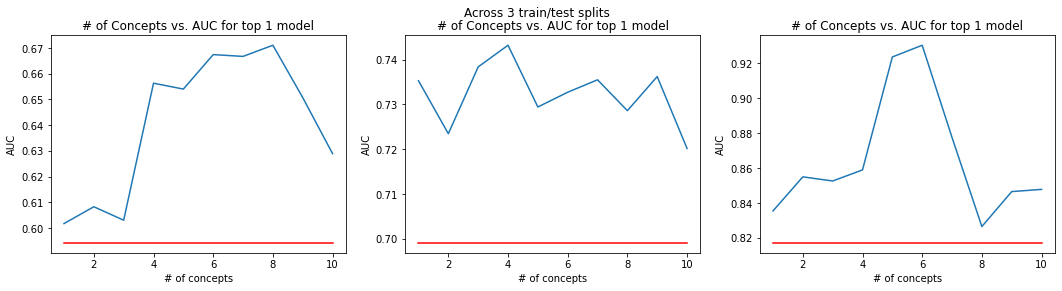

In [15]:
# Top 1 model AUC (individual test splits)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(18,4))
fig.suptitle('Across 3 train/test splits')

ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,:,4])
ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[0][4],10), '-r', label='baseline auc')
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 1 model")

ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,:,4])
ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[1][4],10), '-r', label='baseline auc')
ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 1 model")

ax3.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[2,:,4])
ax3.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[2][4],10), '-r', label='baseline auc')
ax3.set_xlabel("# of concepts")
ax3.set_ylabel("AUC")
ax3.set_title("# of Concepts vs. AUC for top 1 model")


Text(0.5, 1.0, '# of Concepts vs. AUC for top 1 model')

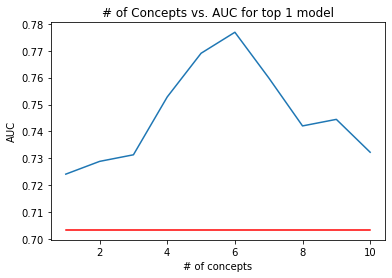

In [29]:
plt.plot(np.arange(1,11),np.mean(np.array(bottleneck_top5_aucs_all),axis=0)[:,4])
plt.plot(np.arange(1,11), np.repeat(np.mean(baseline_top5_aucs,axis=0)[4],10), '-r', label='baseline auc')
plt.xlabel("# of concepts")
plt.ylabel("AUC")
plt.title("# of Concepts vs. AUC for top 1 model")

Text(0.5, 1.0, '# of Concepts vs. AUC for top 5 models')

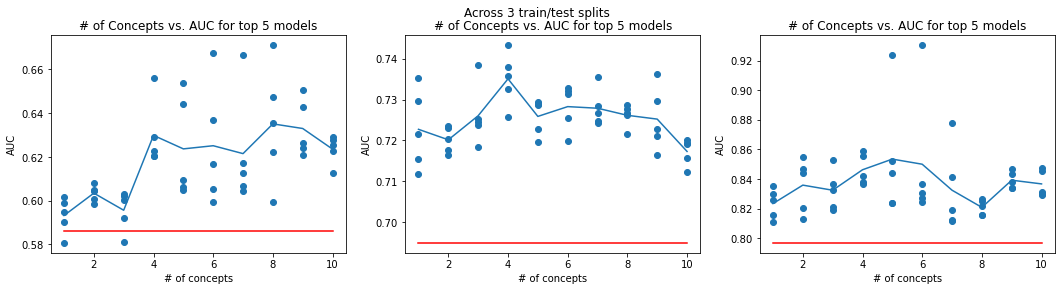

In [30]:
# Top 5 models AUCs

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(18,4))
fig.suptitle('Across 3 train/test splits')

bottleneck_top5_aucs_avg=np.mean(np.array(bottleneck_top5_aucs_all),axis=2)
baseline_top5_aucs_avg=np.mean(np.array(baseline_top5_aucs),axis=1)
ax1.plot(np.arange(1,11),bottleneck_top5_aucs_avg[0])
ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[0],10), '-r', label='baseline auc')
ax1.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[0])
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 5 models")

ax2.plot(np.arange(1,11),bottleneck_top5_aucs_avg[1])
ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[1],10), '-r', label='baseline auc')
ax2.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[1])
ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 5 models")

ax3.plot(np.arange(1,11),bottleneck_top5_aucs_avg[2])
ax3.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[2],10), '-r', label='baseline auc')
ax3.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[2])
ax3.set_xlabel("# of concepts")
ax3.set_ylabel("AUC")
ax3.set_title("# of Concepts vs. AUC for top 5 models")

Text(0.5, 1.0, '# of Concepts vs. AUC for top 5 models')

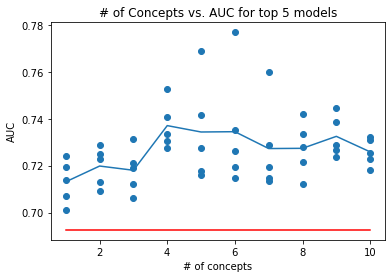

In [31]:
bottleneck_top5_aucs_avg=np.mean(np.array(bottleneck_top5_aucs_all),axis=0)
baseline_top5_aucs_avg=np.mean(np.array(baseline_top5_aucs))
plt.plot(np.arange(1,11),np.mean(bottleneck_top5_aucs_avg,axis=1))
plt.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg,10), '-r', label='baseline auc')
plt.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_avg)
plt.xlabel("# of concepts")
plt.ylabel("AUC")
plt.title("# of Concepts vs. AUC for top 5 models")

## Assign Concept Meanings

In [9]:
summary_dict = {0:'mean', 1:'var', 2:'ever measured', 3:'mean of indicators', 4: 'var of indicators', 5:'# switches', 6:'slope', 7:'slope std err', 8:'first time measured', 9:'last time measured', 10:'hours above threshold', 11:'hours below threshold'}
def getConcept(c):
    if c < 66:
        # raw feature
        return data_cols[c]
    else:
        # summary statistic of feature
        c = c-66
        summary = c//28
        feature = c % 28
        return data_cols[feature], summary_dict[summary]

In [17]:
concept_weights_tot = []
concept_weights_tot_raw = []

train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
for r in range(1,4):
    concept_weights_aggr = []
    concept_weights_aggr_raw = []
    for c in range(1,11):
        concept_weights=[]
        concept_weights_raw=[]
        file = open('./models/gridsearch/vasopressor/vasopressor_bottleneck_r_{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(row)
        for row in bottleneck_top5_all[r-1][c-1]:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]

            # initialize model
            logregbottleneck = initializeModel(c)

            # load trained models
            if r==1:
                logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/gridsearch/vasopressor/bottleneck_c{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(row[0],row[1],row[2],row[3],row[4]), 
                     epochs=1000, 
                     save_every_n_epochs=10)
            else:
                logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/gridsearch/vasopressor/bottleneck_r{}_c{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                     epochs=1000, 
                     save_every_n_epochs=10)

            # get weights
            weights, weights_raw = getWeights(logregbottleneck.model)
            concept_weights.append(weights)
            concept_weights_raw.append(weights_raw)

        # aggregate concept weights for each # of concepts
        concept_weights_aggr.append(concept_weights)
        concept_weights_aggr_raw.append(concept_weights_raw)
    
    # aggregate concept weights for each train/test split
    concept_weights_tot.append(concept_weights_aggr)
    concept_weights_tot_raw.append(concept_weights_aggr_raw)


['1', '0.001', '20.0', '0.0001', '0.0001', '0.5129457364341086']


ValueError: invalid literal for int() with base 10: '0.001'

in init bottleneck test
self.num_concepts
3
Loaded model from ./models/gridsearch/vasopressor/bottleneck_c3_alpha_0.1_tau_100_optlr_1e-05_optwd_0.0001.pt


0it [00:00, ?it/s]


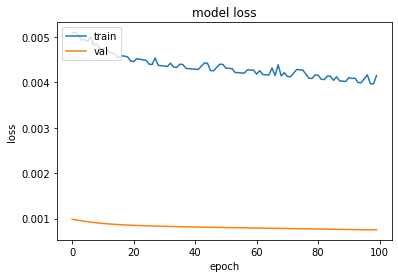

In [39]:
logregbottleneck = initializeModel(3)
logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/gridsearch/vasopressor/bottleneck_c3_alpha_0.1_tau_100_optlr_1e-05_optwd_0.0001.pt".format(row[0],row[1],row[2],row[3],row[4]), 
                     epochs=1000, 
                     save_every_n_epochs=10)
plt.plot(logregbottleneck.train_losses)
plt.plot(logregbottleneck.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
concept_weights_tot_raw_avg = np.mean(np.mean(np.array(concept_weights_tot_raw), axis=0), axis=1)
concept_weights_tot_raw_sorted = []
for i in range(concept_weights_tot_raw_avg.shape[0]):
    concept_weights_tot_raw_sorted.append(np.argsort(-concept_weights_tot_raw_avg[i], axis=1))
for i in range(len(concept_weights_tot_raw_sorted)):
    print("Top 5 features associated with " +  str(i+1) + " concepts:")
    for j in range(i+1):
#         print(concept_weights_tot_raw_sorted[i][j][:5])
        print(list(map(getConcept,concept_weights_tot_raw_sorted[i][j][:5])))
    print("\n")

/n/home07/carissawu/.conda/envs/nj/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home07/carissawu/.conda/envs/nj/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AxisError: axis 1 is out of bounds for array of dimension 0

In [24]:
logregbottleneck = initializeModel(2)
logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/gridsearch/undersampling/bottleneck_r1_c2_alpha_0_tau_100_optlr_0.1_optwd_0.0001.pt", 
                     epochs=1000, 
                     save_every_n_epochs=10)
logregbottleneck.model

in init bottleneck test
self.num_concepts
2
Loaded model from ./models/gridsearch/undersampling/bottleneck_r1_c2_alpha_0_tau_100_optlr_0.1_optwd_0.0001.pt


0it [00:00, ?it/s]


LogisticRegressionWithSummariesAndBottleneck(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (sigmoid_for_switches): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (sigmoid): Sigmoid()
  (bottleneck): Linear(in_features=402, out_features=2, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): Linear(in_features=2, out_features=2, bias=True)
)

In [34]:
logregbottleneck.model.bottleneck.weight.cpu().detach().numpy()

array([[ 3.08984920e-04,  2.76966515e-04, -5.32459118e-04,
        -4.66864381e-04,  1.65971520e-04,  5.05394361e-04,
         1.48471054e-06,  1.55985224e-04, -2.42762922e-04,
        -3.33130592e-03,  2.97757273e-04, -2.56701285e-04,
        -1.10668484e-02,  3.66444886e-03,  2.39573419e-04,
         1.48156410e-04, -2.65033392e-04, -3.03447392e-04,
        -6.72183931e-04, -2.70981021e-04,  2.90756958e-04,
         1.49443396e-03,  1.42461783e-03, -2.57345382e-04,
        -7.87253957e-03,  1.77112513e-03, -2.91097909e-04,
         2.17829621e-03, -1.19904630e-01,  2.62672105e-03,
         8.98300391e-03, -2.82167941e-01, -1.20049946e-01,
        -1.19904630e-01, -2.92342454e-01, -3.13532174e-01,
         8.04891065e-02,  4.51547429e-02,  1.81349053e-04,
         1.73549459e-04,  1.74613912e-02,  1.77410751e-04,
        -3.85515217e-04,  1.58633031e-02,  8.34204172e-09,
        -3.85514693e-04,  1.81835756e-04,  1.93244472e-04,
         2.05711869e-04,  1.86679987e-04,  1.24408178e-1

# 1-10 Concepts Gridsearch & Bootstrap

In [11]:
# BOTTLENECK: get top 5 models from hyperparameter scan

bottleneck_top5_all = []
bottleneck_top5_aucs_all = []
for r in range(1,3):
    bottleneck_top5_split = []
    bottleneck_top5_aucs_split = []
    for s in range(1,4):
        bottleneck_top5 = []
        bottleneck_top5_aucs = []
        for c in range(1,11):
            file = open('./models/gridsearch/vasopressor/vasopressor_bottleneck_r{}_s{}_c{}_gridsearch.csv'.format(r,s,c))
            csvreader = csv.reader(file)
            header = []
            header = next(csvreader)
            bottleneck_rows = []
            for row in csvreader:
                    bottleneck_rows.append(np.array(row).astype(float))
            bottleneck_rows = np.array(bottleneck_rows)
            sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,5])]
            bottleneck_top5.append(sorted_bottleneck_rows[-5:])
            bottleneck_top5_aucs.append(sorted_bottleneck_rows[-5:][:,5])
        bottleneck_top5_split.append(bottleneck_top5)
        bottleneck_top5_aucs_split.append(bottleneck_top5_aucs)
    bottleneck_top5_all.append(bottleneck_top5_split)
    bottleneck_top5_aucs_all.append(bottleneck_top5_aucs_split)

In [12]:
bottleneck_top5_aucs_all[0]

[[array([0.60077519, 0.60325581, 0.60620155, 0.62511628, 0.62860465]),
  array([0.59213178, 0.59992248, 0.60147287, 0.60224806, 0.60426357]),
  array([0.5979845 , 0.60093023, 0.61170543, 0.61806202, 0.61976744]),
  array([0.58449612, 0.58922481, 0.59565891, 0.60186047, 0.61484496]),
  array([0.59550388, 0.59589147, 0.59767442, 0.62744186, 0.64089147]),
  array([0.60976744, 0.62310078, 0.62403101, 0.62697674, 0.64794574]),
  array([0.59364341, 0.59968992, 0.60426357, 0.60542636, 0.62856589]),
  array([0.60248062, 0.6075969 , 0.61162791, 0.62511628, 0.6279845 ]),
  array([0.6120155 , 0.61713178, 0.62767442, 0.64352713, 0.64953488]),
  array([0.59372093, 0.60333333, 0.60616279, 0.60918605, 0.60984496])],
 [array([0.58      , 0.58434109, 0.58511628, 0.58542636, 0.61100775]),
  array([0.59728682, 0.59844961, 0.60503876, 0.60600775, 0.60728682]),
  array([0.60573643, 0.60728682, 0.6120155 , 0.6196124 , 0.65899225]),
  array([0.59476744, 0.60116279, 0.61031008, 0.61581395, 0.63127907]),
  arr

Text(0.5, 1.0, '# of Concepts vs. AUC for top 1 model')

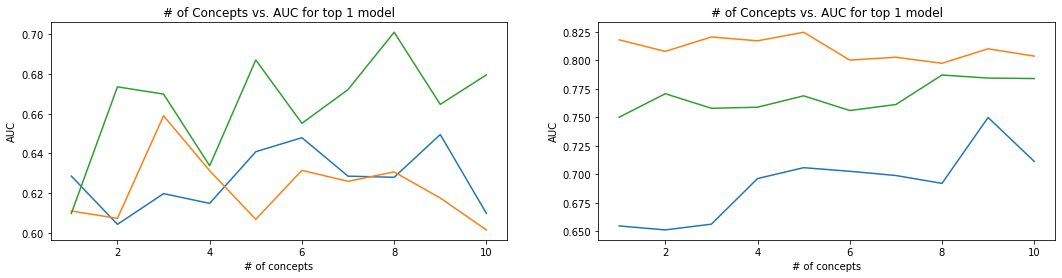

In [13]:
# Top 1 model AUC (individual test splits)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,4))
# fig.suptitle('Across 3 train/test splits')

ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,0,:,4])
ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,1,:,4])
ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,2,:,4])
# plt.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,3,:,4])

ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 1 model")

ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,0,:,4])
ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,1,:,4])
ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,2,:,4])
# plt.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,3,:,4])

ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 1 model")


Text(0.5, 1.0, '# of Concepts vs. AUC for top 5 models')

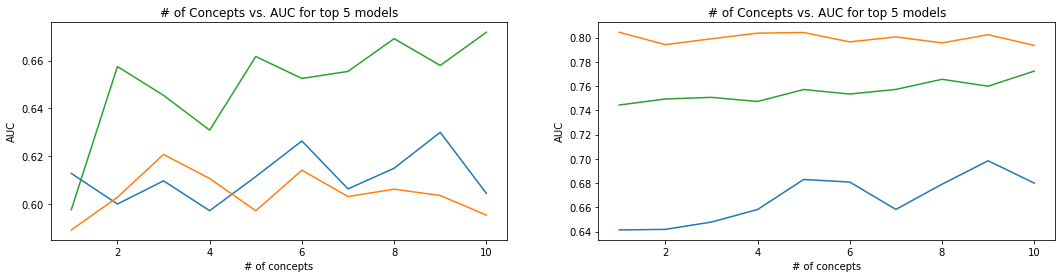

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,4))

bottleneck_top5_aucs_avg=np.mean(np.array(bottleneck_top5_aucs_all),axis=3)
ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[0][0])
ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[0][1])
ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[0][2])
# ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[0][3])

ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 5 models")

ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[1][0])
ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[1][1])
ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[1][2])
# ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_avg)[0][3])

ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 5 models")

# 1-10 Concepts Gridsearch & sampling techniques

In [20]:
# BASELINE: get top 5 models from hyperparameter scan
baseline_top5 = []
baseline_top5_aucs = []

for r in range(1,7):
    file = open('./models/gridsearch/undersampling/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
            baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top5.append(sorted_baseline_rows[-5:])
    baseline_top5_aucs.append(sorted_baseline_rows[-5:][:,4])

In [7]:
baseline_top5_aucs

[array([0.59573643, 0.59937984, 0.60868217, 0.61534884, 0.62829457]),
 array([0.67480932, 0.67511853, 0.67769532, 0.67882911, 0.67893218]),
 array([0.72617438, 0.7267658 , 0.72710375, 0.7274417 , 0.73107469]),
 array([0.86887462, 0.86946604, 0.87005745, 0.87377492, 0.87842176]),
 array([0.71422432, 0.71494055, 0.71501218, 0.71515542, 0.72364274]),
 array([0.67090219, 0.67103212, 0.67908741, 0.68521983, 0.68953331])]

In [21]:
# BOTTLENECK: get top 5 models from hyperparameter scan

bottleneck_top5_all = []
bottleneck_top5_aucs_all = []
for r in range(1,5):
    bottleneck_top5 = []
    bottleneck_top5_aucs = []
    for c in range(1,11):
        file = open('./models/gridsearch/undersampling/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,5])]
        bottleneck_top5.append(sorted_bottleneck_rows[-5:])
        bottleneck_top5_aucs.append(sorted_bottleneck_rows[-5:][:,5])
    bottleneck_top5_all.append(bottleneck_top5)
    bottleneck_top5_aucs_all.append(bottleneck_top5_aucs)

In [14]:
bottleneck_top5_aucs_all

[[array([0.5944186 , 0.60387597, 0.60825581, 0.60910853, 0.62003876]),
  array([0.58565891, 0.58968992, 0.60992248, 0.61096899, 0.66748062]),
  array([0.6227907 , 0.63193798, 0.63972868, 0.64263566, 0.70965116]),
  array([0.60577519, 0.60689922, 0.61903101, 0.62515504, 0.66953488]),
  array([0.63984496, 0.64643411, 0.64705426, 0.64906977, 0.66364341]),
  array([0.61465116, 0.62418605, 0.62503876, 0.64379845, 0.66434109]),
  array([0.61034884, 0.61573643, 0.61868217, 0.62224806, 0.62333333]),
  array([0.62054264, 0.62612403, 0.63717054, 0.6629845 , 0.69193798]),
  array([0.61844961, 0.62209302, 0.63953488, 0.64728682, 0.66387597]),
  array([0.65418605, 0.68186047, 0.68767442, 0.68937984, 0.70069767])],
 [array([0.67728303, 0.6786745 , 0.68022057, 0.68583797, 0.68661101]),
  array([0.67553082, 0.682282  , 0.68434343, 0.68697176, 0.69459905]),
  array([0.67326324, 0.68470418, 0.69099155, 0.69130076, 0.7621109 ]),
  array([0.68779633, 0.69655741, 0.71727479, 0.72531437, 0.74881468]),
  arr

Text(0.5, 1.0, '# of Concepts vs. AUC for top 1 model')

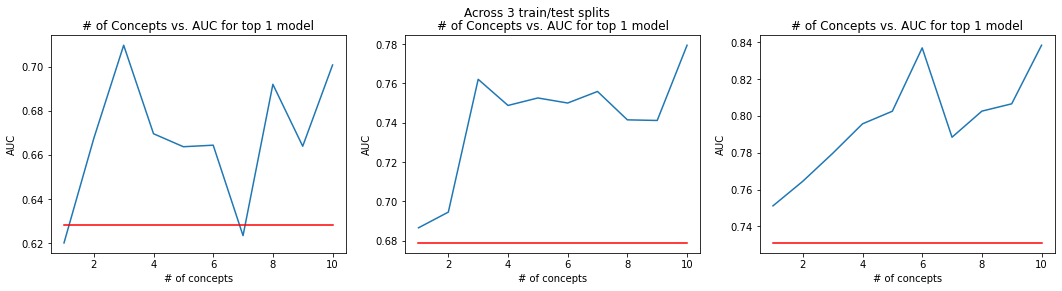

In [23]:
# Top 1 model AUC (individual test splits)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(18,4))
fig.suptitle('Across 3 train/test splits')

ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,:,4])
ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[0][4],10), '-r', label='baseline auc')
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 1 model")

ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,:,4])
ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[1][4],10), '-r', label='baseline auc')
ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 1 model")

ax3.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[2,:,4])
ax3.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[2][4],10), '-r', label='baseline auc')
ax3.set_xlabel("# of concepts")
ax3.set_ylabel("AUC")
ax3.set_title("# of Concepts vs. AUC for top 1 model")

# ax4.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[3,:,4])
# ax4.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[3][4],10), '-r', label='baseline auc')
# ax4.set_xlabel("# of concepts")
# ax4.set_ylabel("AUC")
# ax4.set_title("# of Concepts vs. AUC for top 1 model")


Text(0.5, 1.0, '# of Concepts vs. AUC for top 5 models')

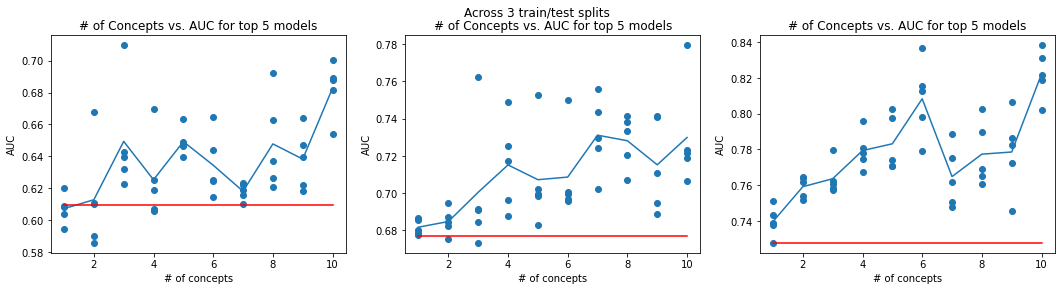

In [25]:
# Top 5 models AUCs

fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(18,4))
fig.suptitle('Across 3 train/test splits')

bottleneck_top5_aucs_avg=np.mean(np.array(bottleneck_top5_aucs_all),axis=2)
baseline_top5_aucs_avg=np.mean(np.array(baseline_top5_aucs),axis=1)
ax1.plot(np.arange(1,11),bottleneck_top5_aucs_avg[0])
ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[0],10), '-r', label='baseline auc')
ax1.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[0])
ax1.set_xlabel("# of concepts")
ax1.set_ylabel("AUC")
ax1.set_title("# of Concepts vs. AUC for top 5 models")

ax2.plot(np.arange(1,11),bottleneck_top5_aucs_avg[1])
ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[1],10), '-r', label='baseline auc')
ax2.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[1])
ax2.set_xlabel("# of concepts")
ax2.set_ylabel("AUC")
ax2.set_title("# of Concepts vs. AUC for top 5 models")

ax3.plot(np.arange(1,11),bottleneck_top5_aucs_avg[2])
ax3.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[2],10), '-r', label='baseline auc')
ax3.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[2])
ax3.set_xlabel("# of concepts")
ax3.set_ylabel("AUC")
ax3.set_title("# of Concepts vs. AUC for top 5 models")

# ax4.plot(np.arange(1,11),bottleneck_top5_aucs_avg[3])
# ax4.plot(np.arange(1,11), np.repeat(baseline_top5_aucs_avg[3],10), '-r', label='baseline auc')
# ax4.scatter(np.repeat(np.array([np.arange(1,11)]),5, axis=1),bottleneck_top5_aucs_all[3])
# ax4.set_xlabel("# of concepts")
# ax4.set_ylabel("AUC")
# ax4.set_title("# of Concepts vs. AUC for top 5 models")

# 1-10 Concepts Gridsearch Consistent Hyperparams

In [14]:
# BASELINE: get top 5 models from hyperparameter scan
baseline_top5 = []
baseline_top5_aucs = []
baseline_top5_ind = []

for r in range(1,3):
    file = open('./models/gridsearch/undersampling/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
            baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top5.append(sorted_baseline_rows[-5:])
    baseline_top5_aucs.append(sorted_baseline_rows[-5:][:,4])
    baseline_top5_ind.append(np.argsort(baseline_rows[:,4])[-5:])

In [20]:
baseline_top5_ind

[array([27,  5, 37, 31,  3]), array([ 0, 11, 23, 29,  6])]

In [25]:
# BOTTLENECK: get top 5 models from hyperparameter scan

bottleneck_top5_all = []
bottleneck_top5_aucs_all = []
for r in range(1,3):
    bottleneck_top5 = []
    bottleneck_top5_aucs = []
    for c in range(1,11):
        file = open('./models/gridsearch/undersampling/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        bottleneck_top5.append(bottleneck_rows)
        bottleneck_top5_aucs.append(bottleneck_rows[:,5])
#         bottleneck_top5.append(bottleneck_rows[baseline_top5_ind[r-1]])
#         bottleneck_top5_aucs.append(bottleneck_rows[baseline_top5_ind[r-1]][:,5])
    bottleneck_top5_all.append(bottleneck_top5)
    bottleneck_top5_aucs_all.append(bottleneck_top5_aucs)

In [26]:
bottleneck_top5_aucs_all

[[array([0.50503876, 0.56949612, 0.56050388, 0.5444186 , 0.56860465]),
  array([0.5       , 0.49135659, 0.5255814 , 0.55751938, 0.53918605]),
  array([0.53775194, 0.51139535, 0.5796124 , 0.45600775, 0.52251938]),
  array([0.57682171, 0.55899225, 0.57926357, 0.5472093 , 0.58472868]),
  array([0.59131783, 0.5748062 , 0.63984496, 0.57410853, 0.58065891]),
  array([0.58534884, 0.59658915, 0.62418605, 0.57744186, 0.5394186 ]),
  array([0.5696124 , 0.5744186 , 0.61573643, 0.60348837, 0.47162791]),
  array([0.58813953, 0.58387597, 0.58914729, 0.55337209, 0.52418605]),
  array([0.58325581, 0.58263566, 0.59015504, 0.58081395, 0.57496124]),
  array([0.59953488, 0.58930233, 0.57271318, 0.57503876, 0.5       ])],
 [array([0.66460524, 0.56158524, 0.59029066, 0.67728303, 0.61343022]),
  array([0.54030097, 0.57823129, 0.69459905, 0.67429396, 0.54195011]),
  array([0.46243043, 0.6701711 , 0.5861678 , 0.55761699, 0.64084725]),
  array([0.5380334 , 0.53607504, 0.57812822, 0.59472274, 0.64357864]),
  arr

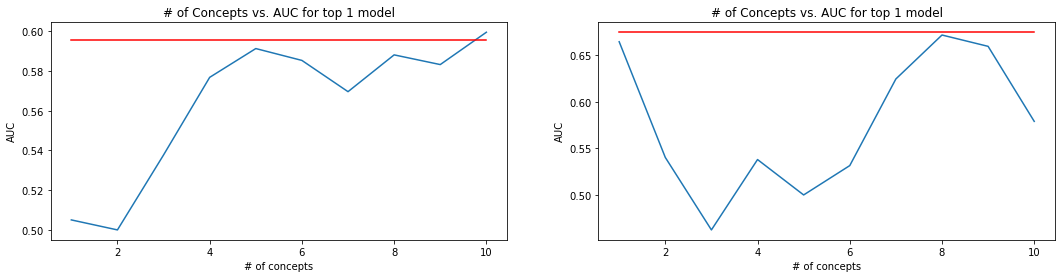

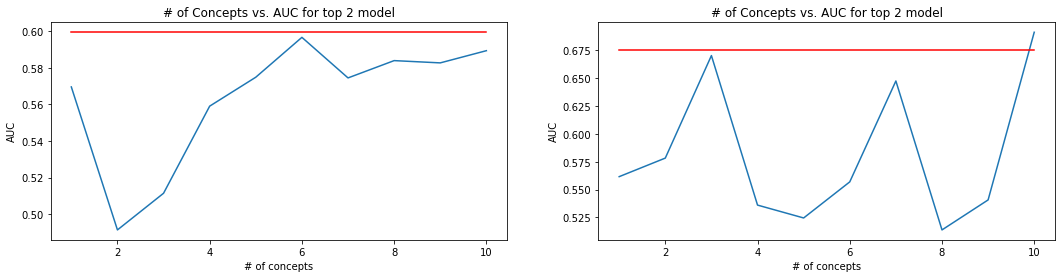

In [30]:
for i in range(2):
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,4))
    ax1.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[0,:,i])
#     ax1.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[0][i],10), '-r', label='baseline auc')
    ax1.set_xlabel("# of concepts")
    ax1.set_ylabel("AUC")
    ax1.set_title("# of Concepts vs. AUC for top {} model".format(i+1))

    ax2.plot(np.arange(1,11),np.array(bottleneck_top5_aucs_all)[1,:,i])
#     ax2.plot(np.arange(1,11), np.repeat(baseline_top5_aucs[1][i],10), '-r', label='baseline auc')
    ax2.set_xlabel("# of concepts")
    ax2.set_ylabel("AUC")
    ax2.set_title("# of Concepts vs. AUC for top {} model".format(i+1))

### Test bootstrapping

In [55]:
# TEST STRATIFY
# ensure data is split in a stratified fashion 
y_1 = list(filter(lambda label: label == [0,1], Y_logits))
y_0 = list(filter(lambda label: label == [1,0], Y_logits))
print("Proportion of positives total")
print(len(y_1)/len(Y_logits))

for r in range(1,3):
    # ,stratify= Y_logits
    X_train, X_test, y_train, y_test = train_test_split(X_np, Y_logits, test_size = 0.15, random_state = r,stratify= Y_logits)
    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    y_train_1 = list(filter(lambda label: label == [0,1], y_train))
    y_train_0 = list(filter(lambda label: label == [1,0], y_train))
    y_val_1 = list(filter(lambda label: label == [0,1], y_val))
    y_val_0 = list(filter(lambda label: label == [1,0], y_val))
    y_test_1 = list(filter(lambda label: label == [0,1], y_test))
    y_test_0 = list(filter(lambda label: label == [1,0], y_test))
    print("Proportion of positives in train")
    print(len(y_train_1)/len(y_train))
    print("Proportion of positives in val")
    print(len(y_val_1)/len(y_val))
    print("Proportion of positives in test")
    print(len(y_test_1)/len(y_test))
    print("\n")

Proportion of positives total
0.09825102880658436
Proportion of positives in train
0.09825059101654847
Proportion of positives in val
0.09833585476550681
Proportion of positives in test
0.09815687955422203


Proportion of positives in train
0.09825059101654847
Proportion of positives in val
0.09833585476550681
Proportion of positives in test
0.09815687955422203




In [5]:
# TEST BOOTSTRAP
# bootstrap split within train/val/test
np.random.seed(1)
boot_ind_train = np.random.choice(range(len(X_train)),int(np.round(0.7*len(X_train))))
X_train_boot = X_train[boot_ind_train]
y_train_boot = [y_train[i] for i in boot_ind_train]

boot_ind_val = np.random.choice(range(len(X_val)),int(np.round(0.7*len(X_val))))
X_val_boot = X_val[boot_ind_val]
y_val_boot = [y_val[i] for i in boot_ind_val]

boot_ind_test = np.random.choice(range(len(X_test)),int(np.round(0.7*len(X_test))))
X_test_boot = X_test[boot_ind_test]
y_test_boot = [y_test[i] for i in boot_ind_test]

print(len(list(filter(lambda label: label == [0,1], y_train_boot))))
print(len(list(filter(lambda label: label == [0,1], y_val_boot))))
print(len(list(filter(lambda label: label == [0,1], y_test_boot))))

32
9
8


In [78]:
# TEST SAMPLING TECHNIQUES
# undersampling and oversampling combination
random.seed
y_train_0 = [idx for idx, label in enumerate(y_train) if label == [1,0]]
y_train_1 = [idx for idx, label in enumerate(y_train) if label == [0,1]]
train_ind_1 = np.random.choice(y_train_1,int(np.round(0.1*len(X_train))))
train_ind_0 = random.sample(y_train_0,int(np.round(0.4*len(X_train))))
X_train = X_train[np.concatenate([train_ind_1,train_ind_0])]
y_train = [y_train[i] for i in np.concatenate([train_ind_1,train_ind_0])]

[2373,
 678,
 794,
 1882,
 605,
 1062,
 682,
 1875,
 1152,
 508,
 1926,
 1988,
 702,
 1271,
 1104,
 842,
 1705,
 1990,
 2199,
 2376,
 2103,
 2133,
 1934,
 1685,
 896,
 1381,
 1348,
 542,
 2356,
 2055,
 1146,
 1665,
 511,
 1520,
 1735,
 1222,
 1829,
 2211,
 2108,
 2032,
 1799,
 1308,
 2177,
 1846,
 650,
 2245,
 1281,
 1668,
 1140,
 1463,
 1034,
 1105,
 510,
 1971,
 1469,
 2141,
 1610,
 729,
 2320,
 1471,
 2452,
 1951,
 622,
 872,
 1038,
 1870,
 1932,
 1204,
 2007,
 1266,
 1775,
 2026,
 869,
 918,
 700,
 656,
 900,
 831,
 1874,
 1264,
 2162,
 818,
 1059,
 1611,
 2096,
 2186,
 1300,
 527,
 520,
 2308,
 493,
 1267,
 726,
 1749,
 1086,
 944,
 815,
 990,
 1689,
 2430,
 1390,
 1879,
 2102,
 2100,
 867,
 701,
 2254,
 2111,
 1364,
 1019,
 910,
 2280,
 912,
 2309,
 816,
 1708,
 1964,
 2449,
 2093,
 1811,
 2261,
 1077,
 770,
 797,
 1385,
 1329,
 827,
 856,
 746,
 626,
 1489,
 1809,
 2201,
 1356,
 559,
 1180,
 2282,
 723,
 1546,
 1305,
 1626,
 1428,
 1839,
 2139,
 718,
 938,
 1719,
 969,
 2159,
 7

In [36]:
# test sampling of hyperparameters

arr_alpha = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
arr_tau = [0.1, 1, 10, 20, 40, 60, 100]
arr_opt_lr = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
arr_opt_weight_decay = [0, 1e-5, 1e-4, 1e-3]

for r in range(2):
    random.seed(1)
#     for n in range(2):
#         print(random.choice(arr_alpha))
#         print(random.choice(arr_tau))
#         print(random.choice(arr_opt_lr))
#         print(random.choice(arr_opt_weight_decay))
#         print()

print("***")
for r in range(2):
    for c in range(2):
        random.seed(1)
#         for n in range(2):
#             print(random.choice(arr_alpha))
#             print(random.choice(arr_tau))
#             print(random.choice(arr_opt_lr))
#             print(random.choice(arr_opt_weight_decay))
#             print()


***
